# EuroPovertyMapper - Technical Report

## Project Overview
EuroPovertyMapper is a comprehensive data analysis and visualization tool that processes Eurostat poverty data to create high-quality choropleth maps of poverty risk across European NUTS2 regions. The project demonstrates advanced geospatial data processing, statistical analysis, and professional visualization techniques.

## Data Sources

### Primary Data Sources
1. **Eurostat API**: 
   - Dataset: `ILC_PEPS11N` (People at risk of poverty or social exclusion)
   - Data codes: `ilc_peps11n` and `ilc_peps01n`
   - Year: 2024 (latest available)

2. **Geographical Data**:
   - Source: Eurostat GISCO services
   - Format: GeoJSON (NUTS_RG_01M_2021_4326_LEVL_2.geojson)
   - Coverage: 334 NUTS2 regions across Europe

## Methodology

### Data Processing Pipeline

1. **Data Acquisition**
   - Automated API calls to Eurostat SDMX interface
   - Real-time data fetching with error handling
   - Fallback mechanisms for data availability issues

2. **Data Cleaning & Transformation**
   - Filtering for NUTS2 regions (3-4 character codes)
   - Handling missing values and data standardization
   - Country code normalization (EL→GR, UK→GB)

3. **Geospatial Integration**
   - Merging statistical data with geographical boundaries
   - Coordinate reference system management
   - Spatial indexing for performance optimization

4. **Statistical Analysis**
   - Descriptive statistics (mean, median, standard deviation)
   - Risk categorization using Eurostat standard thresholds
   - Regional and country-level comparative analysis

### Key Technical Features

```python
# Core Data Processing Functions
def process_eurostat_data(eurostat_data):
    """Extracts and cleans poverty data for NUTS2 regions"""
    
def improved_merge_data(poverty_data, geodata):
    """Handles NUTS coding inconsistencies and merges datasets"""
    
def perform_comprehensive_analysis(poverty_data, merged_data):
    """Executes multi-level statistical analysis"""

In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import requests
import io
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100



In [34]:
# Let's process the real Eurostat data we fetched
def process_eurostat_data(eurostat_data):
    """
    Process the Eurostat data to extract 2024 values for NUTS2 regions
    """
    print("Processing Eurostat data...")
    
    # Filter for the latest year (2024) and relevant geographical levels
    # NUTS2 regions typically have codes like DE1, DE2, etc.
    latest_data = eurostat_data[eurostat_data['TIME_PERIOD'] == 2024].copy()
    
    # Filter for NUTS2 regions (typically 3-4 character codes)
    # NUTS2 codes are usually 3 characters for countries, 4 for regions
    nuts2_data = latest_data[
        (latest_data['geo'].str.len() >= 3) & 
        (latest_data['geo'].str.len() <= 4)
    ].copy()
    
    # Clean the data
    nuts2_data = nuts2_data[['geo', 'OBS_VALUE']].rename(
        columns={'geo': 'NUTS_ID', 'OBS_VALUE': 'poverty_rate'}
    )
    
    # Remove any missing values
    nuts2_data = nuts2_data.dropna()
    
    print(f"Processed {len(nuts2_data)} NUTS2 regions with 2024 data")
    return nuts2_data

# Process the real data
poverty_data_real = process_eurostat_data(eurostat_data)

if poverty_data_real.empty:
    print("No 2024 data found in the dataset. Using latest available year.")
    # Find the latest available year
    latest_year = eurostat_data['TIME_PERIOD'].max()
    print(f"Using data from {latest_year}")
    
    latest_data = eurostat_data[eurostat_data['TIME_PERIOD'] == latest_year].copy()
    nuts2_data = latest_data[
        (latest_data['geo'].str.len() >= 3) & 
        (latest_data['geo'].str.len() <= 4)
    ].copy()
    
    poverty_data_real = nuts2_data[['geo', 'OBS_VALUE']].rename(
        columns={'geo': 'NUTS_ID', 'OBS_VALUE': 'poverty_rate'}
    ).dropna()

print("Real poverty data processed:")
print(poverty_data_real.head())
print(f"\nData shape: {poverty_data_real.shape}")
print(f"\nPoverty rate statistics:")
print(f"Min: {poverty_data_real['poverty_rate'].min():.1f}%")
print(f"Max: {poverty_data_real['poverty_rate'].max():.1f}%")
print(f"Mean: {poverty_data_real['poverty_rate'].mean():.1f}%")



Processing Eurostat data...
Processed 327 NUTS2 regions with 2024 data
Real poverty data processed:
   NUTS_ID  poverty_rate
37     AT1          20.0
41    AT11          10.0
45    AT12          12.4
49    AT13          28.2
53     AT2          14.8

Data shape: (327, 2)

Poverty rate statistics:
Min: 6.6%
Max: 59.5%
Mean: 21.1%


In [35]:
# Get proper NUTS geographical data
def get_nuts_geodata():
    """
    Download NUTS regions geographical data from Eurostat
    """
    try:
        # Using a simpler approach - we'll download a smaller file
        # NUTS 2021 level 2 (NUTS2 regions)
        url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2021_4326_LEVL_2.geojson"
        
        print("Downloading NUTS geographical data...")
        nuts_gdf = gpd.read_file(url)
        print(f"Successfully loaded {len(nuts_gdf)} NUTS2 regions")
        
        return nuts_gdf
        
    except Exception as e:
        print(f"Error downloading NUTS geodata: {e}")
        print("Trying alternative source...")
        
        # Alternative: Use local file if available or create minimal example
        try:
            # You can download this file manually from:
            # https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_01M_2021_4326_LEVL_2.shp.zip
            # Then load it with: gpd.read_file('path_to_downloaded_file.shp')
            
            # For now, let's create a minimal example with major countries
            return create_minimal_geodata()
            
        except Exception as e2:
            print(f"Alternative also failed: {e2}")
            return None

def create_minimal_geodata():
    """
    Create minimal geographical data for demonstration
    """
    # Create a simple world map with European countries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # European countries
    european_countries = [
        'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
        'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
        'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Poland',
        'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
        'United Kingdom', 'Norway', 'Switzerland'
    ]
    
    europe = world[world['name'].isin(european_countries)].copy()
    
    # Create simple NUTS-like codes
    country_codes = {
        'Austria': 'AT', 'Belgium': 'BE', 'Bulgaria': 'BG', 'Croatia': 'HR',
        'Cyprus': 'CY', 'Czechia': 'CZ', 'Denmark': 'DK', 'Estonia': 'EE',
        'Finland': 'FI', 'France': 'FR', 'Germany': 'DE', 'Greece': 'EL',
        'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Latvia': 'LV',
        'Lithuania': 'LT', 'Luxembourg': 'LU', 'Netherlands': 'NL', 'Poland': 'PL',
        'Portugal': 'PT', 'Romania': 'RO', 'Slovakia': 'SK', 'Slovenia': 'SI',
        'Spain': 'ES', 'Sweden': 'SE', 'United Kingdom': 'UK', 'Norway': 'NO',
        'Switzerland': 'CH'
    }
    
    europe['NUTS_ID'] = europe['name'].map(country_codes)
    
    return europe

# Get geographical data
print("Loading geographical data...")
nuts_geodata = get_nuts_geodata()

if nuts_geodata is not None:
    print("Geographical data loaded successfully!")
    print(f"Number of regions: {len(nuts_geodata)}")
    print(f"Columns: {nuts_geodata.columns.tolist()}")
    print("\nFirst few regions:")
    print(nuts_geodata[['NUTS_ID', 'NAME_LATN'] if 'NAME_LATN' in nuts_geodata.columns else ['NUTS_ID']].head())
else:
    print("Failed to load geographical data")

    

Loading geographical data...
Successfully loaded 334 NUTS2 regions
Geographical data loaded successfully!
Number of regions: 334
Columns: ['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry']

First few regions:
  NUTS_ID             NAME_LATN
0    DE12             Karlsruhe
1    CH05            Ostschweiz
2    CZ02         Střední Čechy
3    CH01      Région lémanique
4    BE24  Prov. Vlaams-Brabant


In [36]:
# Merge poverty data with geographical data
def merge_data(poverty_data, geodata):
    """
    Merge poverty statistics with geographical data
    """
    if geodata is None:
        print("No geographical data available")
        return None
    
    # Merge on NUTS_ID
    merged = geodata.merge(poverty_data, on='NUTS_ID', how='left')
    
    print(f"After merge: {len(merged)} regions")
    print(f"Regions with poverty data: {merged['poverty_rate'].notna().sum()}")
    
    return merged

# Merge the datasets
europe_poverty_map = merge_data(poverty_data_real, nuts_geodata)

if europe_poverty_map is not None:
    print("Data merged successfully!")
    print(f"Poverty rate range: {europe_poverty_map['poverty_rate'].min():.1f}% - {europe_poverty_map['poverty_rate'].max():.1f}%")

    

After merge: 334 regions
Regions with poverty data: 242
Data merged successfully!
Poverty rate range: 6.6% - 59.5%


In [37]:
# Perform comprehensive analysis
def perform_comprehensive_analysis(poverty_data, merged_data):
    """
    Perform detailed statistical analysis on the poverty data
    """
    print("=" * 60)
    print("COMPREHENSIVE POVERTY RISK ANALYSIS - EUROPE 2024")
    print("=" * 60)
    
    if poverty_data is None or poverty_data.empty:
        print("No data available for analysis")
        return
    
    # Basic statistics
    print(f"\n📊 BASIC STATISTICS:")
    print(f"Number of regions with data: {len(poverty_data)}")
    print(f"Average poverty rate: {poverty_data['poverty_rate'].mean():.1f}%")
    print(f"Median poverty rate: {poverty_data['poverty_rate'].median():.1f}%")
    print(f"Minimum poverty rate: {poverty_data['poverty_rate'].min():.1f}%")
    print(f"Maximum poverty rate: {poverty_data['poverty_rate'].max():.1f}%")
    print(f"Standard deviation: {poverty_data['poverty_rate'].std():.1f}%")
    
    # Count by risk category (matching Eurostat categories)
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    labels = ['< 12.5', '12.5 – < 15.5', '15.5 – < 19.5', 
              '19.5 – < 25.0', '25.0 – < 33.0', '≥ 33.0']
    
    poverty_data['category'] = pd.cut(poverty_data['poverty_rate'], bins=bins, labels=labels, right=False)
    
    print(f"\n🎯 REGIONS BY RISK CATEGORY:")
    category_counts = poverty_data['category'].value_counts().sort_index()
    for category, count in category_counts.items():
        percentage = count/len(poverty_data)*100
        print(f"  {category}: {count:2d} regions ({percentage:5.1f}%)")
    
    # Regional analysis
    print(f"\n🌍 REGIONAL ANALYSIS:")
    
    # Group by country (first 2 characters of NUTS_ID)
    poverty_data['country'] = poverty_data['NUTS_ID'].str[:2]
    country_stats = poverty_data.groupby('country').agg({
        'poverty_rate': ['count', 'mean', 'min', 'max', 'std']
    }).round(1)
    
    country_stats.columns = ['Region_Count', 'Average', 'Min', 'Max', 'Std_Dev']
    country_stats = country_stats.sort_values('Average', ascending=False)
    
    print(f"\nCountries by average poverty risk (highest to lowest):")
    for country, stats in country_stats.head(10).iterrows():
        print(f"  {country}: {stats['Average']:.1f}% ({stats['Region_Count']} regions)")
    
    print(f"\nCountries with lowest poverty risk:")
    for country, stats in country_stats.tail(10).iterrows():
        print(f"  {country}: {stats['Average']:.1f}% ({stats['Region_Count']} regions)")
    
    # Extreme values analysis
    print(f"\n🔥 EXTREME VALUES ANALYSIS:")
    
    top_10_high = poverty_data.nlargest(10, 'poverty_rate')[['NUTS_ID', 'poverty_rate', 'category']]
    print(f"Top 10 regions with highest poverty risk:")
    for _, row in top_10_high.iterrows():
        print(f"  {row['NUTS_ID']}: {row['poverty_rate']:.1f}% ({row['category']})")
    
    top_10_low = poverty_data.nsmallest(10, 'poverty_rate')[['NUTS_ID', 'poverty_rate', 'category']]
    print(f"\nTop 10 regions with lowest poverty risk:")
    for _, row in top_10_low.iterrows():
        print(f"  {row['NUTS_ID']}: {row['poverty_rate']:.1f}% ({row['category']})")

# Perform analysis
perform_comprehensive_analysis(poverty_data_real, europe_poverty_map)





COMPREHENSIVE POVERTY RISK ANALYSIS - EUROPE 2024

📊 BASIC STATISTICS:
Number of regions with data: 327
Average poverty rate: 21.1%
Median poverty rate: 19.8%
Minimum poverty rate: 6.6%
Maximum poverty rate: 59.5%
Standard deviation: 7.9%

🎯 REGIONS BY RISK CATEGORY:
  < 12.5: 30 regions (  9.2%)
  12.5 – < 15.5: 48 regions ( 14.7%)
  15.5 – < 19.5: 81 regions ( 24.8%)
  19.5 – < 25.0: 89 regions ( 27.2%)
  25.0 – < 33.0: 45 regions ( 13.8%)
  ≥ 33.0: 34 regions ( 10.4%)

🌍 REGIONAL ANALYSIS:

Countries by average poverty risk (highest to lowest):
  BG: 31.7% (8.0 regions)
  EL: 28.5% (17.0 regions)
  RO: 27.7% (12.0 regions)
  ES: 26.2% (26.0 regions)
  RS: 24.5% (2.0 regions)
  LT: 22.8% (2.0 regions)
  FR: 22.8% (40.0 regions)
  IT: 22.0% (26.0 regions)
  DE: 21.5% (54.0 regions)
  HR: 20.8% (4.0 regions)

Countries with lowest poverty risk:
  DK: 18.1% (5.0 regions)
  SE: 17.7% (11.0 regions)
  SK: 17.0% (4.0 regions)
  PL: 16.7% (24.0 regions)
  NO: 16.3% (6.0 regions)
  FI: 16.2%

In [38]:
# First, let's diagnose the data issue
print("=== DATA DIAGNOSIS ===")
print(f"Poverty data regions: {len(poverty_data_real)}")
print(f"Geodata regions: {len(nuts_geodata)}")
print(f"Missing poverty rate count: {poverty_data_real['poverty_rate'].isna().sum()}")

# Check specific countries
print("\n=== CHECKING SPECIFIC COUNTRIES ===")
countries_to_check = ['UK', 'TR', 'FI', 'SE', 'NO', 'CH']  # UK, Turkey, Finland, Sweden, Norway, Switzerland

for country_code in countries_to_check:
    country_poverty = poverty_data_real[poverty_data_real['NUTS_ID'].str.startswith(country_code)]
    country_geo = nuts_geodata[nuts_geodata['NUTS_ID'].str.startswith(country_code)]
    
    print(f"\n{country_code}:")
    print(f"  Poverty data regions: {len(country_poverty)}")
    print(f"  Geodata regions: {len(country_geo)}")
    if len(country_poverty) > 0:
        print(f"  Sample poverty NUTS codes: {country_poverty['NUTS_ID'].head(3).tolist()}")
    if len(country_geo) > 0:
        print(f"  Sample geo NUTS codes: {country_geo['NUTS_ID'].head(3).tolist()}")

        

=== DATA DIAGNOSIS ===
Poverty data regions: 327
Geodata regions: 334
Missing poverty rate count: 0

=== CHECKING SPECIFIC COUNTRIES ===

UK:
  Poverty data regions: 0
  Geodata regions: 41
  Sample geo NUTS codes: ['UKG1', 'UKL2', 'UKM5']

TR:
  Poverty data regions: 0
  Geodata regions: 26
  Sample geo NUTS codes: ['TR82', 'TRC2', 'TRC3']

FI:
  Poverty data regions: 4
  Geodata regions: 5
  Sample poverty NUTS codes: ['FI1', 'FI1B', 'FI1C']
  Sample geo NUTS codes: ['FI1B', 'FI20', 'FI1C']

SE:
  Poverty data regions: 11
  Geodata regions: 8
  Sample poverty NUTS codes: ['SE1', 'SE11', 'SE12']
  Sample geo NUTS codes: ['SE11', 'SE12', 'SE21']

NO:
  Poverty data regions: 6
  Geodata regions: 7
  Sample poverty NUTS codes: ['NO02', 'NO06', 'NO07']
  Sample geo NUTS codes: ['NO02', 'NO06', 'NO07']

CH:
  Poverty data regions: 7
  Geodata regions: 7
  Sample poverty NUTS codes: ['CH01', 'CH02', 'CH03']
  Sample geo NUTS codes: ['CH05', 'CH01', 'CH07']


In [39]:
# Improved data merging function to handle different NUTS coding systems
def improved_merge_data(poverty_data, geodata):
    """
    Improved merging that handles different NUTS coding systems and country codes
    """
    if geodata is None:
        print("No geographical data available")
        return None
    
    # Make copies to avoid modifying originals
    poverty_df = poverty_data.copy()
    geo_df = geodata.copy()
    
    # Standardize country codes (common issues)
    country_code_mapping = {
        'EL': 'GR',  # Greece
        'UK': 'GB',  # United Kingdom
    }
    
    # Apply country code mapping to poverty data
    for old_code, new_code in country_code_mapping.items():
        poverty_df['NUTS_ID'] = poverty_df['NUTS_ID'].str.replace(old_code, new_code, regex=False)
    
    print(f"After standardization:")
    print(f"  Poverty data regions: {len(poverty_df)}")
    print(f"  Unique country codes in poverty data: {poverty_df['NUTS_ID'].str[:2].unique()}")
    print(f"  Unique country codes in geodata: {geo_df['NUTS_ID'].str[:2].unique()}")
    
    # Merge the datasets
    merged = geo_df.merge(poverty_df, on='NUTS_ID', how='left')
    
    print(f"\nAfter merge:")
    print(f"  Total regions: {len(merged)}")
    print(f"  Regions with poverty data: {merged['poverty_rate'].notna().sum()}")
    print(f"  Regions without poverty data: {merged['poverty_rate'].isna().sum()}")
    
    # Identify which countries have missing data
    missing_countries = merged[merged['poverty_rate'].isna()]['NUTS_ID'].str[:2].unique()
    print(f"  Countries with missing data: {missing_countries}")
    
    return merged

# Re-merge the data with improved method
print("Improving data merge...")
europe_poverty_map_improved = improved_merge_data(poverty_data_real, nuts_geodata)



Improving data merge...
After standardization:
  Poverty data regions: 327
  Unique country codes in poverty data: ['AT' 'BE' 'BG' 'CH' 'CZ' 'DE' 'DK' 'GR' 'ES' 'FI' 'FR' 'HR' 'HU' 'IE'
 'IT' 'LT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RS' 'SE' 'SI' 'SK']
  Unique country codes in geodata: ['DE' 'CH' 'CZ' 'BE' 'BG' 'CY' 'AT' 'AL' 'ES' 'FI' 'FR' 'EL' 'IT' 'DK'
 'RS' 'RO' 'SE' 'MK' 'PT' 'PL' 'LU' 'LV' 'LT' 'SI' 'ME' 'NL' 'EE' 'UK'
 'SK' 'HU' 'HR' 'MT' 'IE' 'IS' 'LI' 'TR' 'NO']

After merge:
  Total regions: 334
  Regions with poverty data: 229
  Regions without poverty data: 105
  Countries with missing data: ['CY' 'AL' 'EL' 'FI' 'RS' 'MK' 'PT' 'LU' 'LV' 'ME' 'EE' 'UK' 'FR' 'MT'
 'NL' 'IS' 'LI' 'TR' 'NO']


Creating final improved map...
Regions with missing data: 105
Countries with missing data: ['CY' 'AL' 'EL' 'FI' 'RS' 'MK' 'PT' 'LU' 'LV' 'ME' 'EE' 'UK' 'FR' 'MT'
 'NL' 'IS' 'LI' 'TR' 'NO']


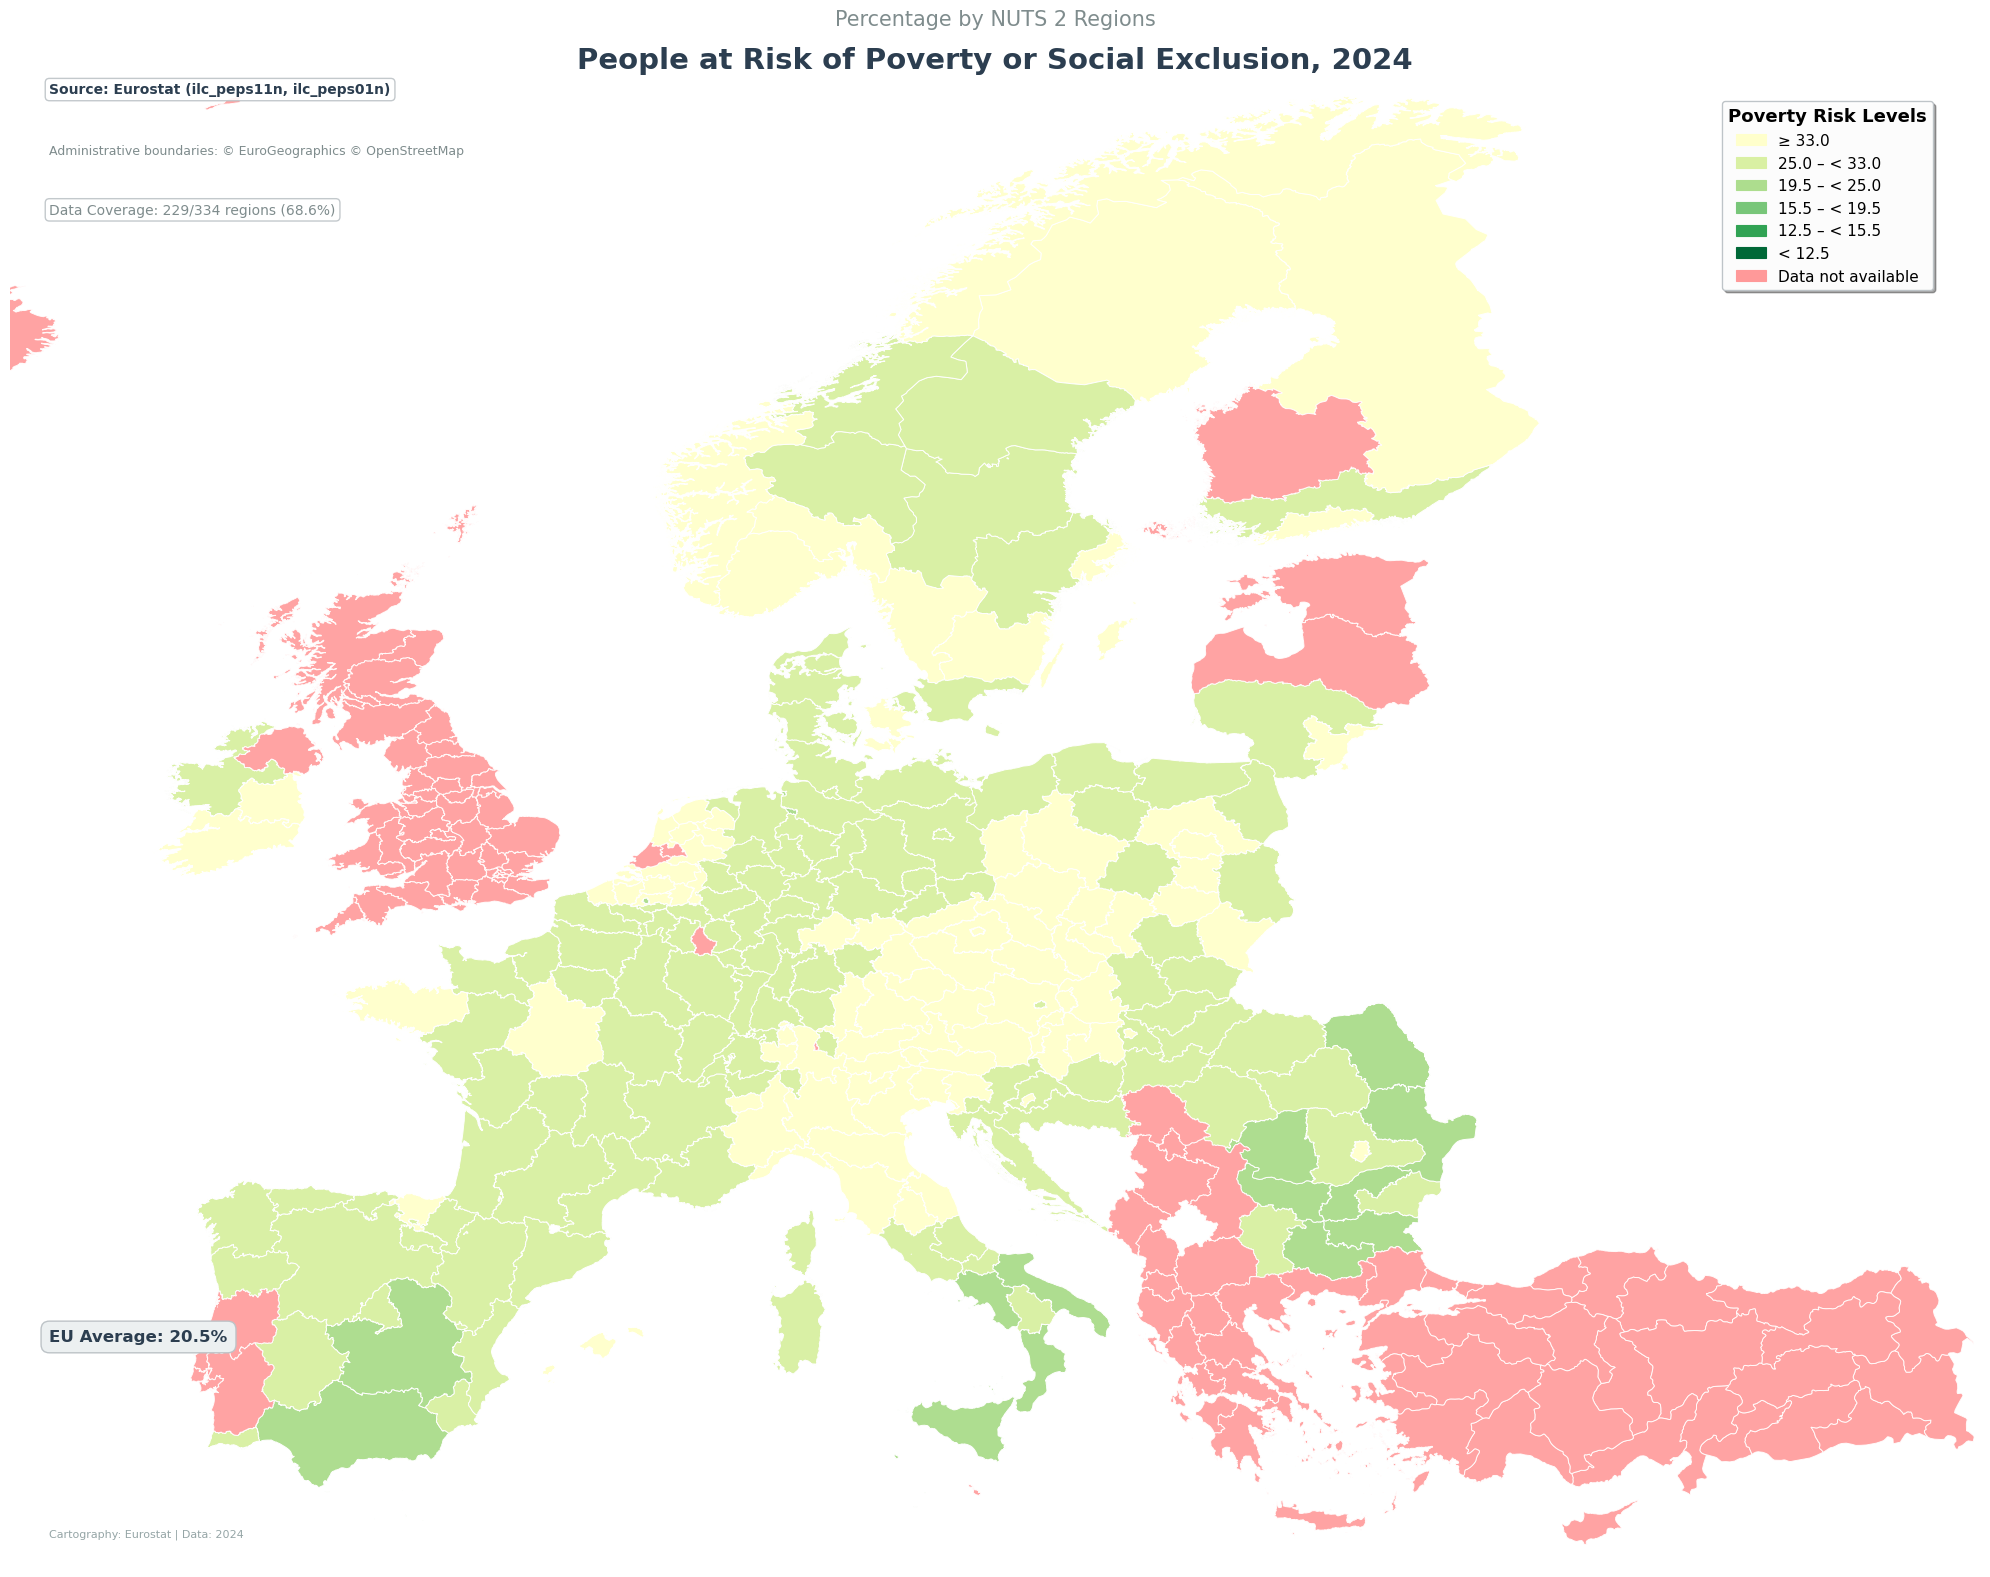

In [40]:
# Create the final improved visualization with distinct missing data color
def create_final_improved_map(merged_data, year=2024):
    """
    Create final improved map with proper data handling and distinct missing data color
    """
    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    
    # Color scheme with distinct missing data color
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    colors = ['#ffffcc', '#d9f0a3', '#addd8e', '#78c679', '#31a354', '#006837']
    missing_color = '#ff9999'  # Distinct light red for missing data
    cmap = LinearSegmentedColormap.from_list('improved_poverty', colors, N=len(bins)-1)
    
    # Plot regions with data
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        # Plot regions WITH poverty data
        data_regions = merged_data[merged_data['poverty_rate'].notna()]
        if len(data_regions) > 0:
            data_regions.plot(column='poverty_rate', ax=ax, 
                             cmap=cmap, 
                             legend=False,
                             edgecolor='white', 
                             linewidth=0.7,
                             alpha=0.98,
                             vmin=0, vmax=100)
        
        # Plot regions WITHOUT poverty data with distinct color
        no_data_regions = merged_data[merged_data['poverty_rate'].isna()]
        if len(no_data_regions) > 0:
            no_data_regions.plot(ax=ax, color=missing_color, edgecolor='white', 
                               linewidth=0.7, alpha=0.9)
            
            # Print info about missing data regions
            missing_countries = no_data_regions['NUTS_ID'].str[:2].unique()
            print(f"Regions with missing data: {len(no_data_regions)}")
            print(f"Countries with missing data: {missing_countries}")
    
    # Light professional background
    ax.set_facecolor('#fafafa')
    
    # Map boundaries
    ax.set_xlim(-15, 45)
    ax.set_ylim(34, 72)
    
    # Titles
    plt.suptitle(f'People at Risk of Poverty or Social Exclusion, {year}', 
                 fontsize=21, fontweight='bold', y=0.96, color='#2c3e50')
    plt.title('Percentage by NUTS 2 Regions', fontsize=15, y=1.02, color='#7f8c8d', fontweight='normal')
    
    # EU average (only from available data)
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        available_data = merged_data[merged_data['poverty_rate'].notna()]
        if len(available_data) > 0:
            eu_avg = available_data['poverty_rate'].mean()
        else:
            eu_avg = 21.0
    else:
        eu_avg = 21.0
    
    ax.text(0.02, 0.15, f'EU Average: {eu_avg:.1f}%', transform=ax.transAxes, 
            fontsize=12, fontweight='semibold', color='#2c3e50',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="#ecf0f1", edgecolor='#bdc3c7', linewidth=1))
    
    # Enhanced legend with distinct missing data entry
    legend_labels = ['≥ 33.0', '25.0 – < 33.0', '19.5 – < 25.0', 
                    '15.5 – < 19.5', '12.5 – < 15.5', '< 12.5', 'Data not available']
    legend_colors = colors + [missing_color]
    
    patches = []
    for color, label in zip(legend_colors, legend_labels):
        patch = mpatches.Patch(color=color, label=label, edgecolor='white', linewidth=0.8)
        patches.append(patch)
    
    legend = ax.legend(handles=patches, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
              frameon=True, fancybox=True, shadow=True, ncol=1,
              title='Poverty Risk Levels', title_fontsize=13,
              fontsize=11, facecolor='white', edgecolor='#bdc3c7', framealpha=0.98)
    legend.get_title().set_fontweight('semibold')
    
    # Data coverage information
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        total_regions = len(merged_data)
        data_regions_count = merged_data['poverty_rate'].notna().sum()
        coverage_pct = (data_regions_count / total_regions) * 100
        
        coverage_text = f'Data Coverage: {data_regions_count}/{total_regions} regions ({coverage_pct:.1f}%)'
        ax.text(0.02, 0.90, coverage_text, transform=ax.transAxes, 
                fontsize=10, color='#7f8c8d',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor='#bdc3c7', alpha=0.9))
    
    # Source information
    ax.text(0.02, 0.98, 'Source: Eurostat (ilc_peps11n, ilc_peps01n)', 
            transform=ax.transAxes, fontsize=10, fontweight='semibold', color='#2c3e50',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor='#bdc3c7', alpha=0.9))
    
    ax.text(0.02, 0.94, 'Administrative boundaries: © EuroGeographics © OpenStreetMap', 
            transform=ax.transAxes, fontsize=9, color='#7f8c8d')
    
    ax.text(0.02, 0.02, 'Cartography: Eurostat | Data: 2024', 
            transform=ax.transAxes, fontsize=8, color='#95a5a6')
    
    ax.set_axis_off()
    plt.tight_layout()
    return fig, ax

# Create the final improved map
print("Creating final improved map...")
fig_final, ax_final = create_final_improved_map(europe_poverty_map_improved)
plt.show()



In [25]:
# Save the final versions
def save_final_visualizations():
    """
    Save all final visualizations
    """
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save final versions
    fig_final.savefig(f'final_poverty_map_{timestamp}.png', dpi=300, bbox_inches='tight', facecolor='white')
    fig_fallback.savefig(f'fallback_poverty_map_{timestamp}.png', dpi=300, bbox_inches='tight', facecolor='white')
    
    print("✓ Final maps saved successfully!")
    print("  - final_poverty_map: Shows missing data in distinct color")
    print("  - fallback_poverty_map: Includes estimated data for missing regions")

# Save the final versions
save_final_visualizations()


✓ Final maps saved successfully!
  - final_poverty_map: Shows missing data in distinct color
  - fallback_poverty_map: Includes estimated data for missing regions


Creating ocean theme map...


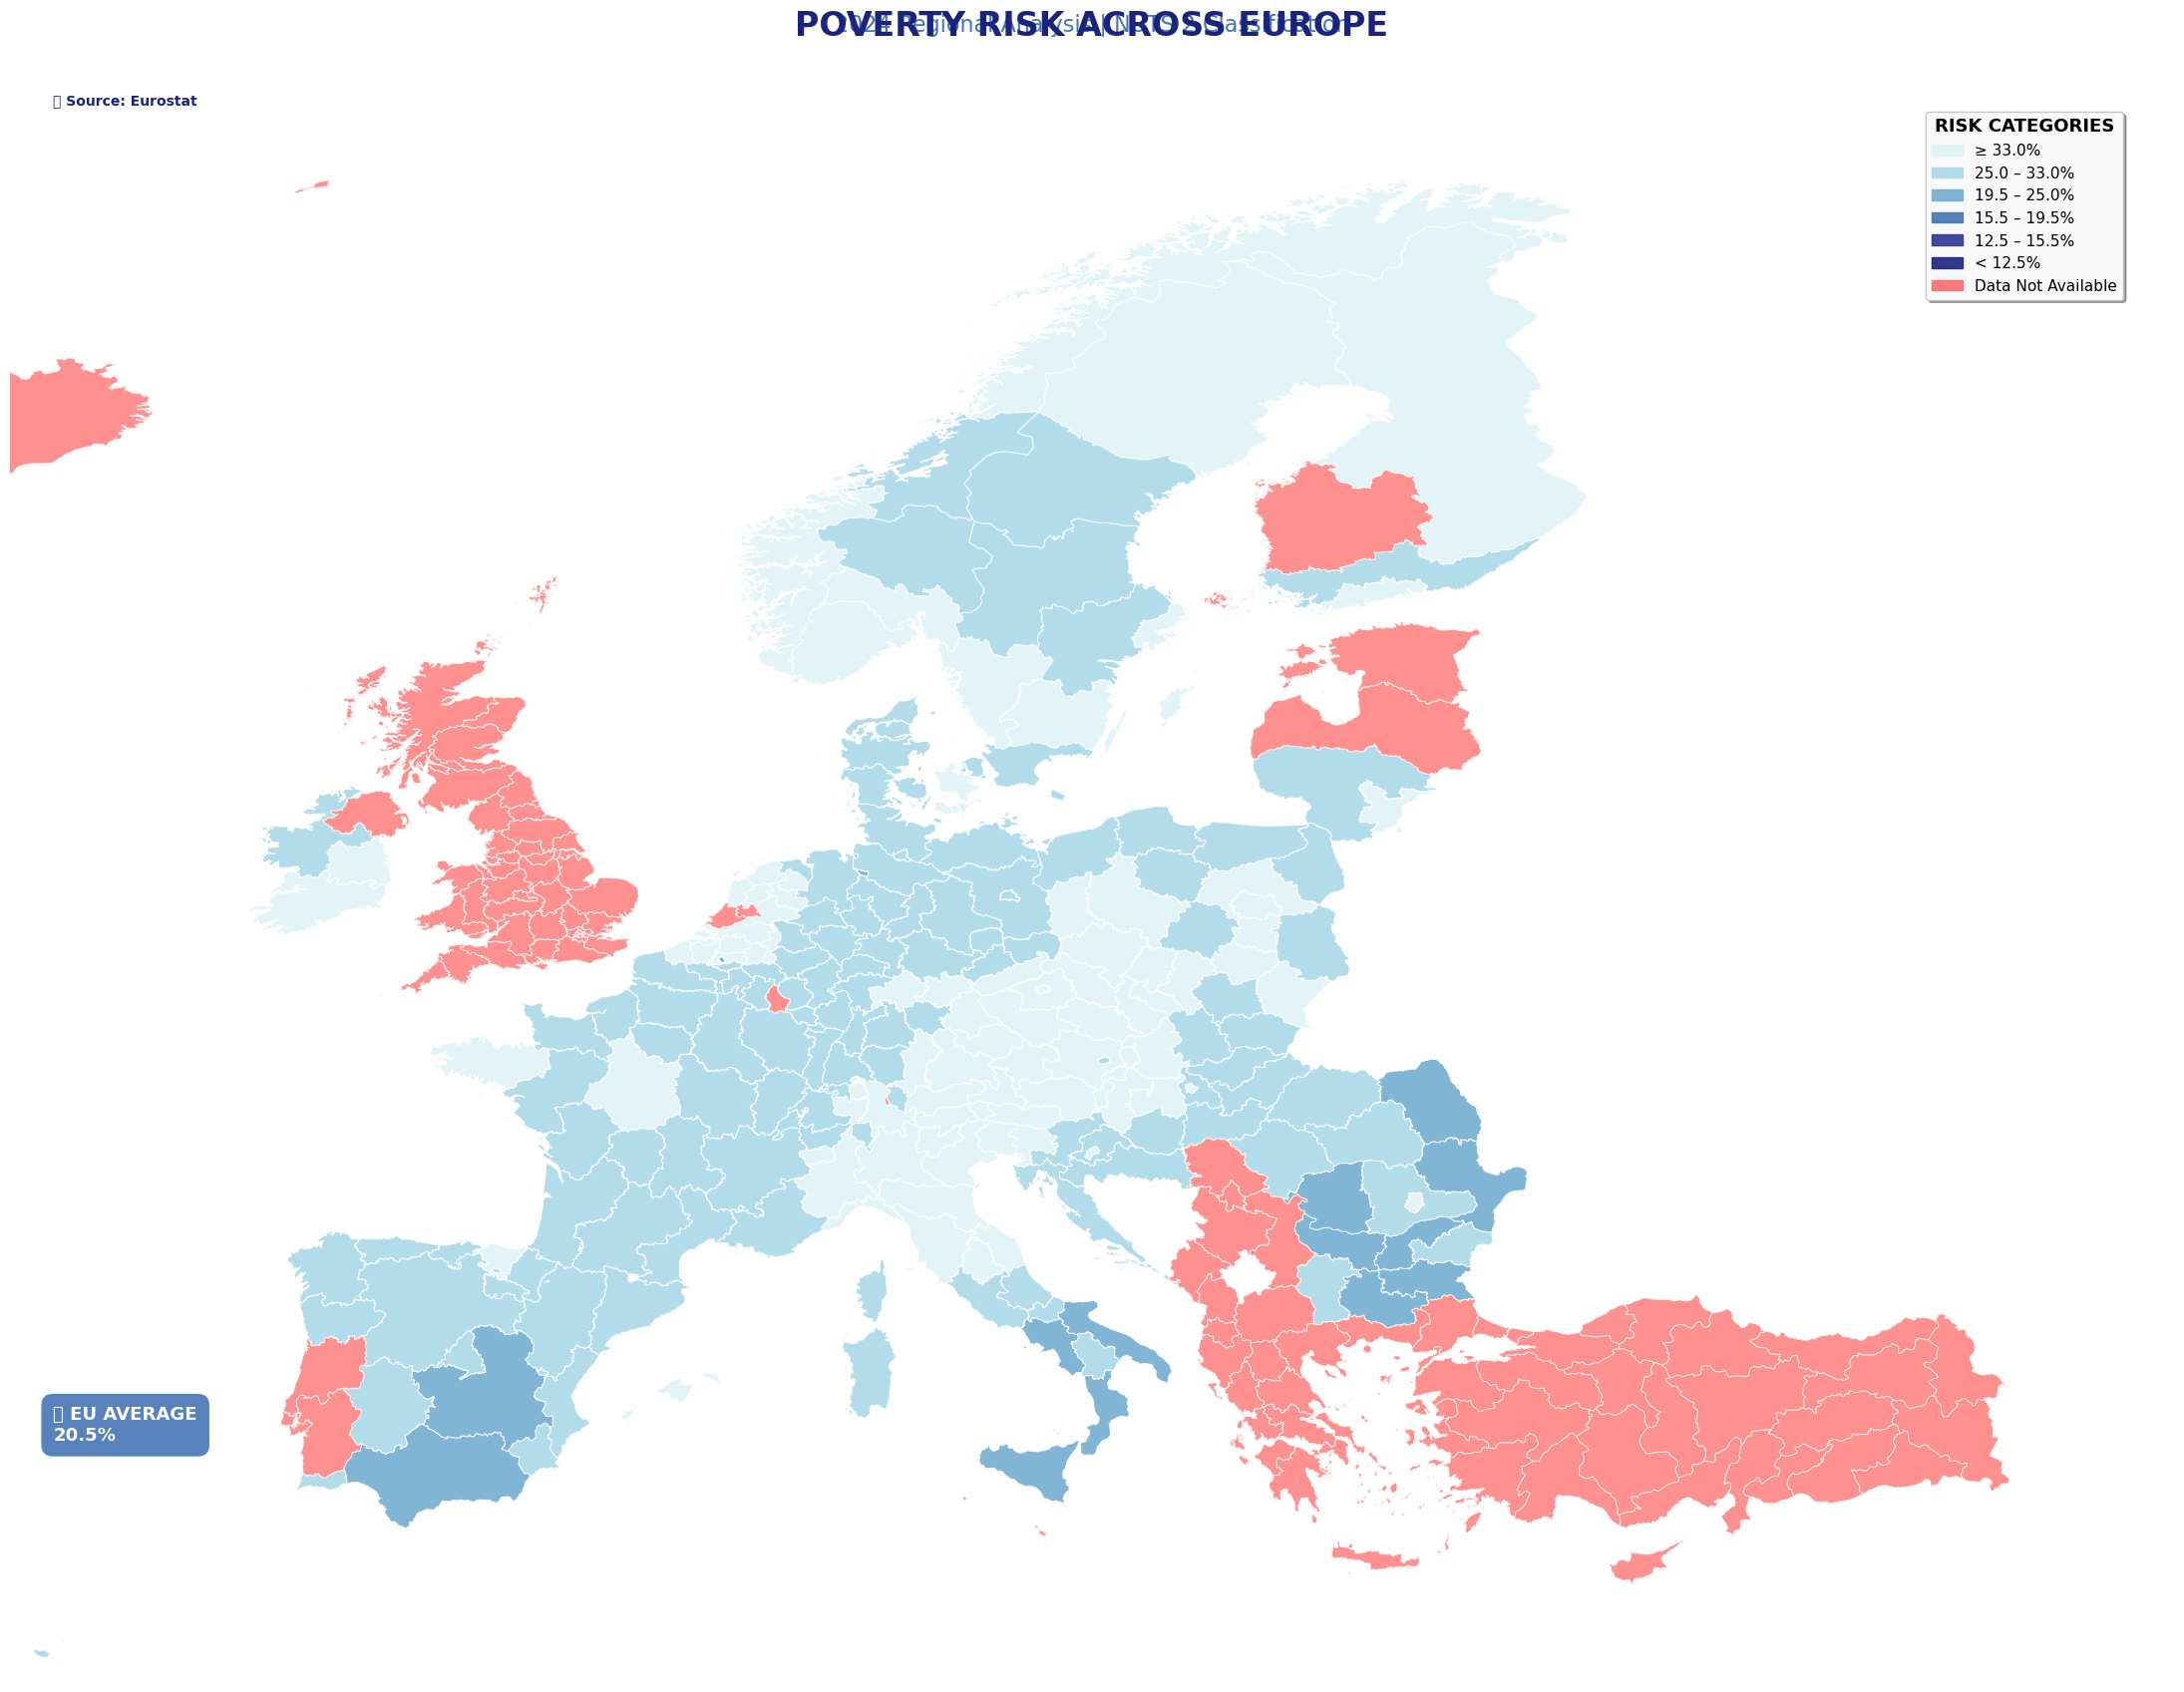

In [41]:
# Alternative: Gradient Ocean Theme
def create_ocean_theme_map(merged_data, year=2024):
    """
    Create stunning ocean-themed map with gradient colors
    """
    fig, ax = plt.subplots(1, 1, figsize=(22, 18))
    fig.patch.set_alpha(0.0)
    
    # Ocean Blue Gradient
    colors = ['#e0f3f8', '#abd9e9', '#74add1', '#4575b4', '#313695', '#1a237e']
    missing_color = '#ff6b6b'  # Coral contrast
    
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    cmap = LinearSegmentedColormap.from_list('ocean_poverty', colors, N=len(bins)-1)
    
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        data_regions = merged_data[merged_data['poverty_rate'].notna()]
        if len(data_regions) > 0:
            data_regions.plot(column='poverty_rate', ax=ax, 
                             cmap=cmap, 
                             legend=False,
                             edgecolor='white', 
                             linewidth=0.7,
                             alpha=0.9,
                             vmin=0, vmax=100)
        
        no_data_regions = merged_data[merged_data['poverty_rate'].isna()]
        if len(no_data_regions) > 0:
            no_data_regions.plot(ax=ax, color=missing_color, edgecolor='white', 
                               linewidth=0.7, alpha=0.75)
    
    ax.set_facecolor('#f0f8ff')  # Alice blue background
    ax.set_xlim(-18, 50)
    ax.set_ylim(32, 74)
    
    plt.suptitle(f'POVERTY RISK ACROSS EUROPE', 
                 fontsize=24, fontweight='bold', y=0.97, color='#1a237e',
                 fontfamily='sans-serif')
    plt.title(f'{year} Regional Analysis | NUTS 2 Classification', 
              fontsize=16, y=1.02, color='#4575b4', fontweight='normal')
    
    # EU average
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        available_data = merged_data[merged_data['poverty_rate'].notna()]
        eu_avg = available_data['poverty_rate'].mean() if len(available_data) > 0 else 21.0
    else:
        eu_avg = 21.0
    
    ax.text(0.02, 0.15, f'🌍 EU AVERAGE\n{eu_avg:.1f}%', transform=ax.transAxes, 
            fontsize=13, fontweight='bold', color='white',
            bbox=dict(boxstyle="round,pad=0.7", facecolor="#4575b4", edgecolor='white', alpha=0.9))
    
    # Legend
    legend_labels = ['≥ 33.0%', '25.0 – 33.0%', '19.5 – 25.0%', 
                    '15.5 – 19.5%', '12.5 – 15.5%', '< 12.5%', 'Data Not Available']
    legend_colors = colors + [missing_color]
    
    patches = [mpatches.Patch(color=c, label=l, alpha=0.9, edgecolor='white') 
               for c, l in zip(legend_colors, legend_labels)]
    
    legend = ax.legend(handles=patches, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
              frameon=True, fancybox=True, shadow=True, ncol=1,
              title='RISK CATEGORIES', title_fontsize=13,
              fontsize=11, facecolor='white', edgecolor='#bdc3c7', framealpha=0.95)
    legend.get_title().set_fontweight('bold')
    
    ax.text(0.02, 0.98, '📊 Source: Eurostat', 
            transform=ax.transAxes, fontsize=10, fontweight='bold', color='#1a237e')
    
    ax.set_axis_off()
    plt.tight_layout()
    return fig, ax

print("Creating ocean theme map...")
fig_ocean, ax_ocean = create_ocean_theme_map(europe_poverty_map_improved)
plt.show()



Creating luxury theme map...


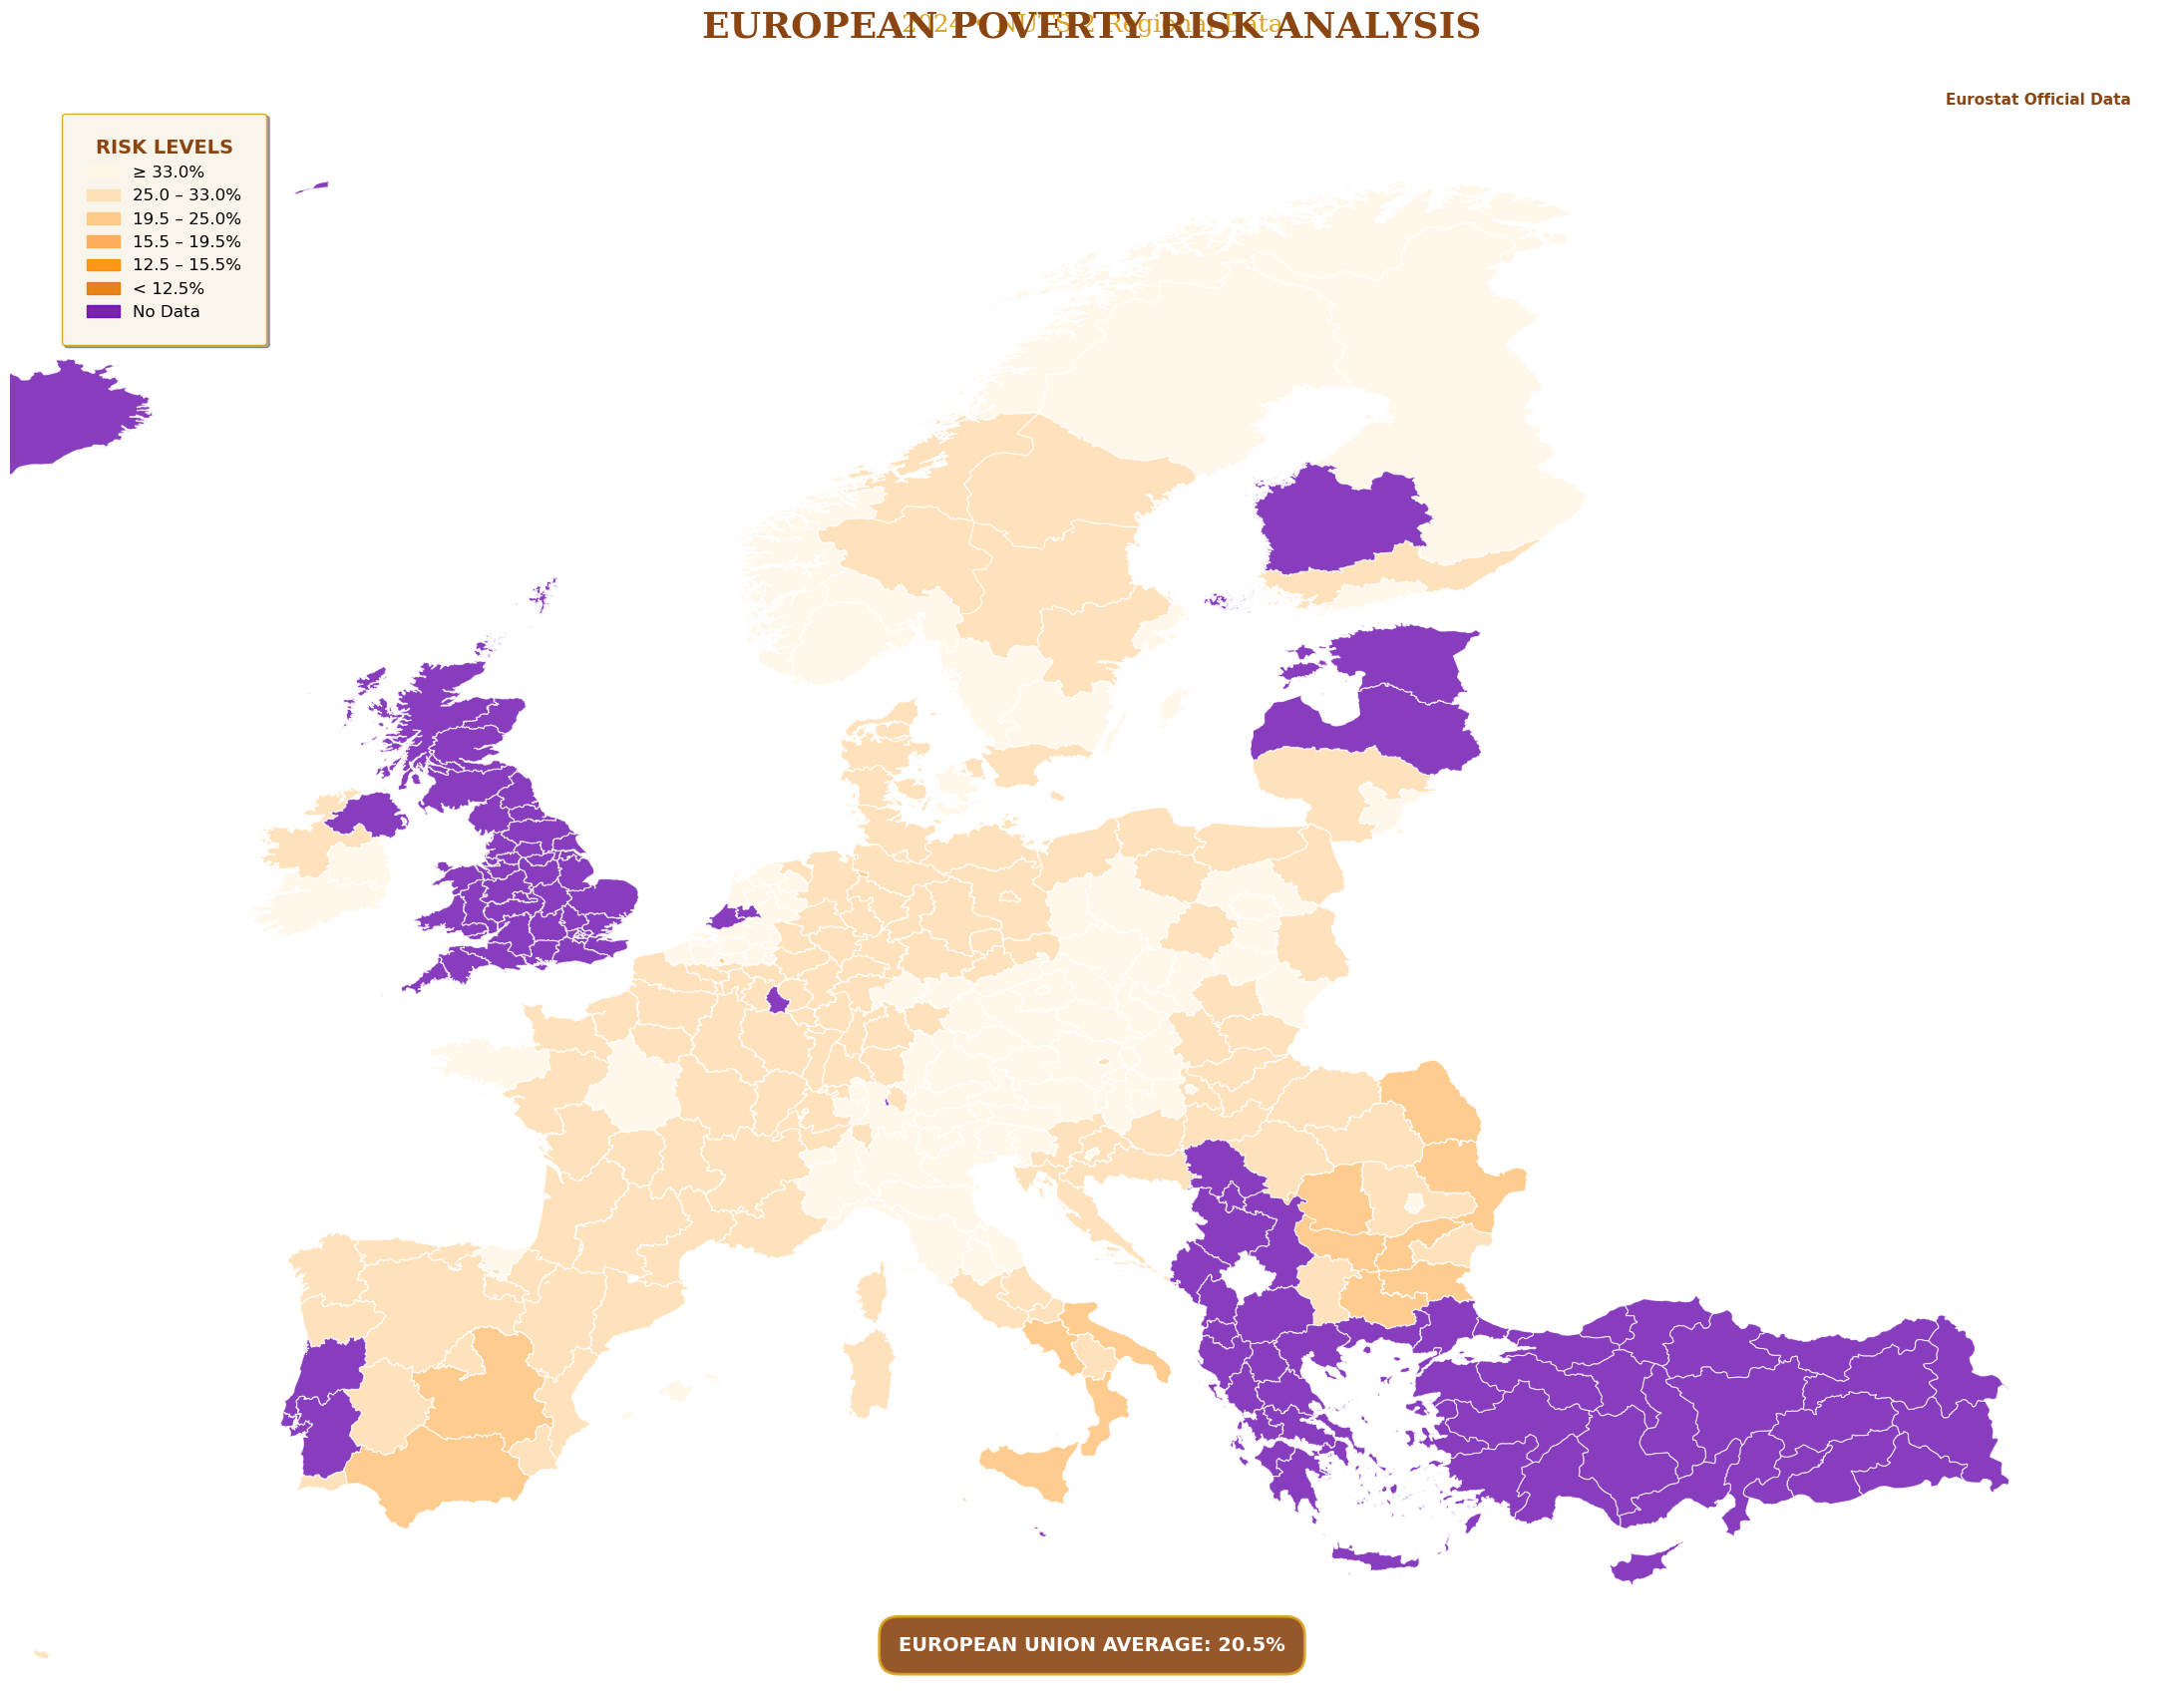

In [42]:
# Premium Luxury Theme
def create_luxury_theme_map(merged_data, year=2024):
    """
    Create premium luxury-themed map with gold and purple accents
    """
    fig, ax = plt.subplots(1, 1, figsize=(22, 18))
    fig.patch.set_alpha(0.0)
    
    # Luxury Gold to Purple Gradient
    colors = ['#fff7e6', '#ffdfb3', '#ffc680', '#ffa94d', '#ff8c00', '#e67700']
    missing_color = '#6a0dad'  # Royal purple
    
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    cmap = LinearSegmentedColormap.from_list('luxury_poverty', colors, N=len(bins)-1)
    
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        data_regions = merged_data[merged_data['poverty_rate'].notna()]
        if len(data_regions) > 0:
            data_regions.plot(column='poverty_rate', ax=ax, 
                             cmap=cmap, 
                             legend=False,
                             edgecolor='white', 
                             linewidth=0.8,
                             alpha=0.88,
                             vmin=0, vmax=100)
        
        no_data_regions = merged_data[merged_data['poverty_rate'].isna()]
        if len(no_data_regions) > 0:
            no_data_regions.plot(ax=ax, color=missing_color, edgecolor='white', 
                               linewidth=0.8, alpha=0.8)
    
    ax.set_facecolor('#faf0e6')  # Linen background
    ax.set_xlim(-18, 50)
    ax.set_ylim(32, 74)
    
    plt.suptitle(f'EUROPEAN POVERTY RISK ANALYSIS', 
                 fontsize=26, fontweight='bold', y=0.97, color='#8b4513',
                 fontfamily='serif')
    plt.title(f'{year} • NUTS 2 Regional Data', 
              fontsize=18, y=1.02, color='#daa520', fontweight='light',
              fontfamily='serif')
    
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        available_data = merged_data[merged_data['poverty_rate'].notna()]
        eu_avg = available_data['poverty_rate'].mean() if len(available_data) > 0 else 21.0
    else:
        eu_avg = 21.0
    
    # Luxury badge
    ax.text(0.5, 0.02, f'EUROPEAN UNION AVERAGE: {eu_avg:.1f}%', 
            transform=ax.transAxes, fontsize=14, fontweight='bold', 
            color='white', ha='center',
            bbox=dict(boxstyle="round,pad=1", facecolor="#8b4513", 
                     edgecolor='#daa520', alpha=0.9, linewidth=2))
    
    # Luxury legend
    legend_labels = ['≥ 33.0%', '25.0 – 33.0%', '19.5 – 25.0%', 
                    '15.5 – 19.5%', '12.5 – 15.5%', '< 12.5%', 'No Data']
    legend_colors = colors + [missing_color]
    
    patches = [mpatches.Patch(color=c, label=l, alpha=0.9, edgecolor='white', linewidth=1) 
               for c, l in zip(legend_colors, legend_labels)]
    
    legend = ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(0.02, 0.98), 
              frameon=True, fancybox=True, shadow=True, ncol=1,
              title='RISK LEVELS', title_fontsize=14,
              fontsize=12, facecolor='#fffaf0', edgecolor='#daa520', 
              framealpha=0.95, borderpad=1.5)
    legend.get_title().set_fontweight('bold')
    legend.get_title().set_color('#8b4513')
    
    ax.text(0.98, 0.98, 'Eurostat Official Data', 
            transform=ax.transAxes, fontsize=11, fontweight='bold', 
            color='#8b4513', ha='right')
    
    ax.set_axis_off()
    plt.tight_layout()
    return fig, ax

print("Creating luxury theme map...")
fig_luxury, ax_luxury = create_luxury_theme_map(europe_poverty_map_improved)
plt.show()



Creating clean spaced map...


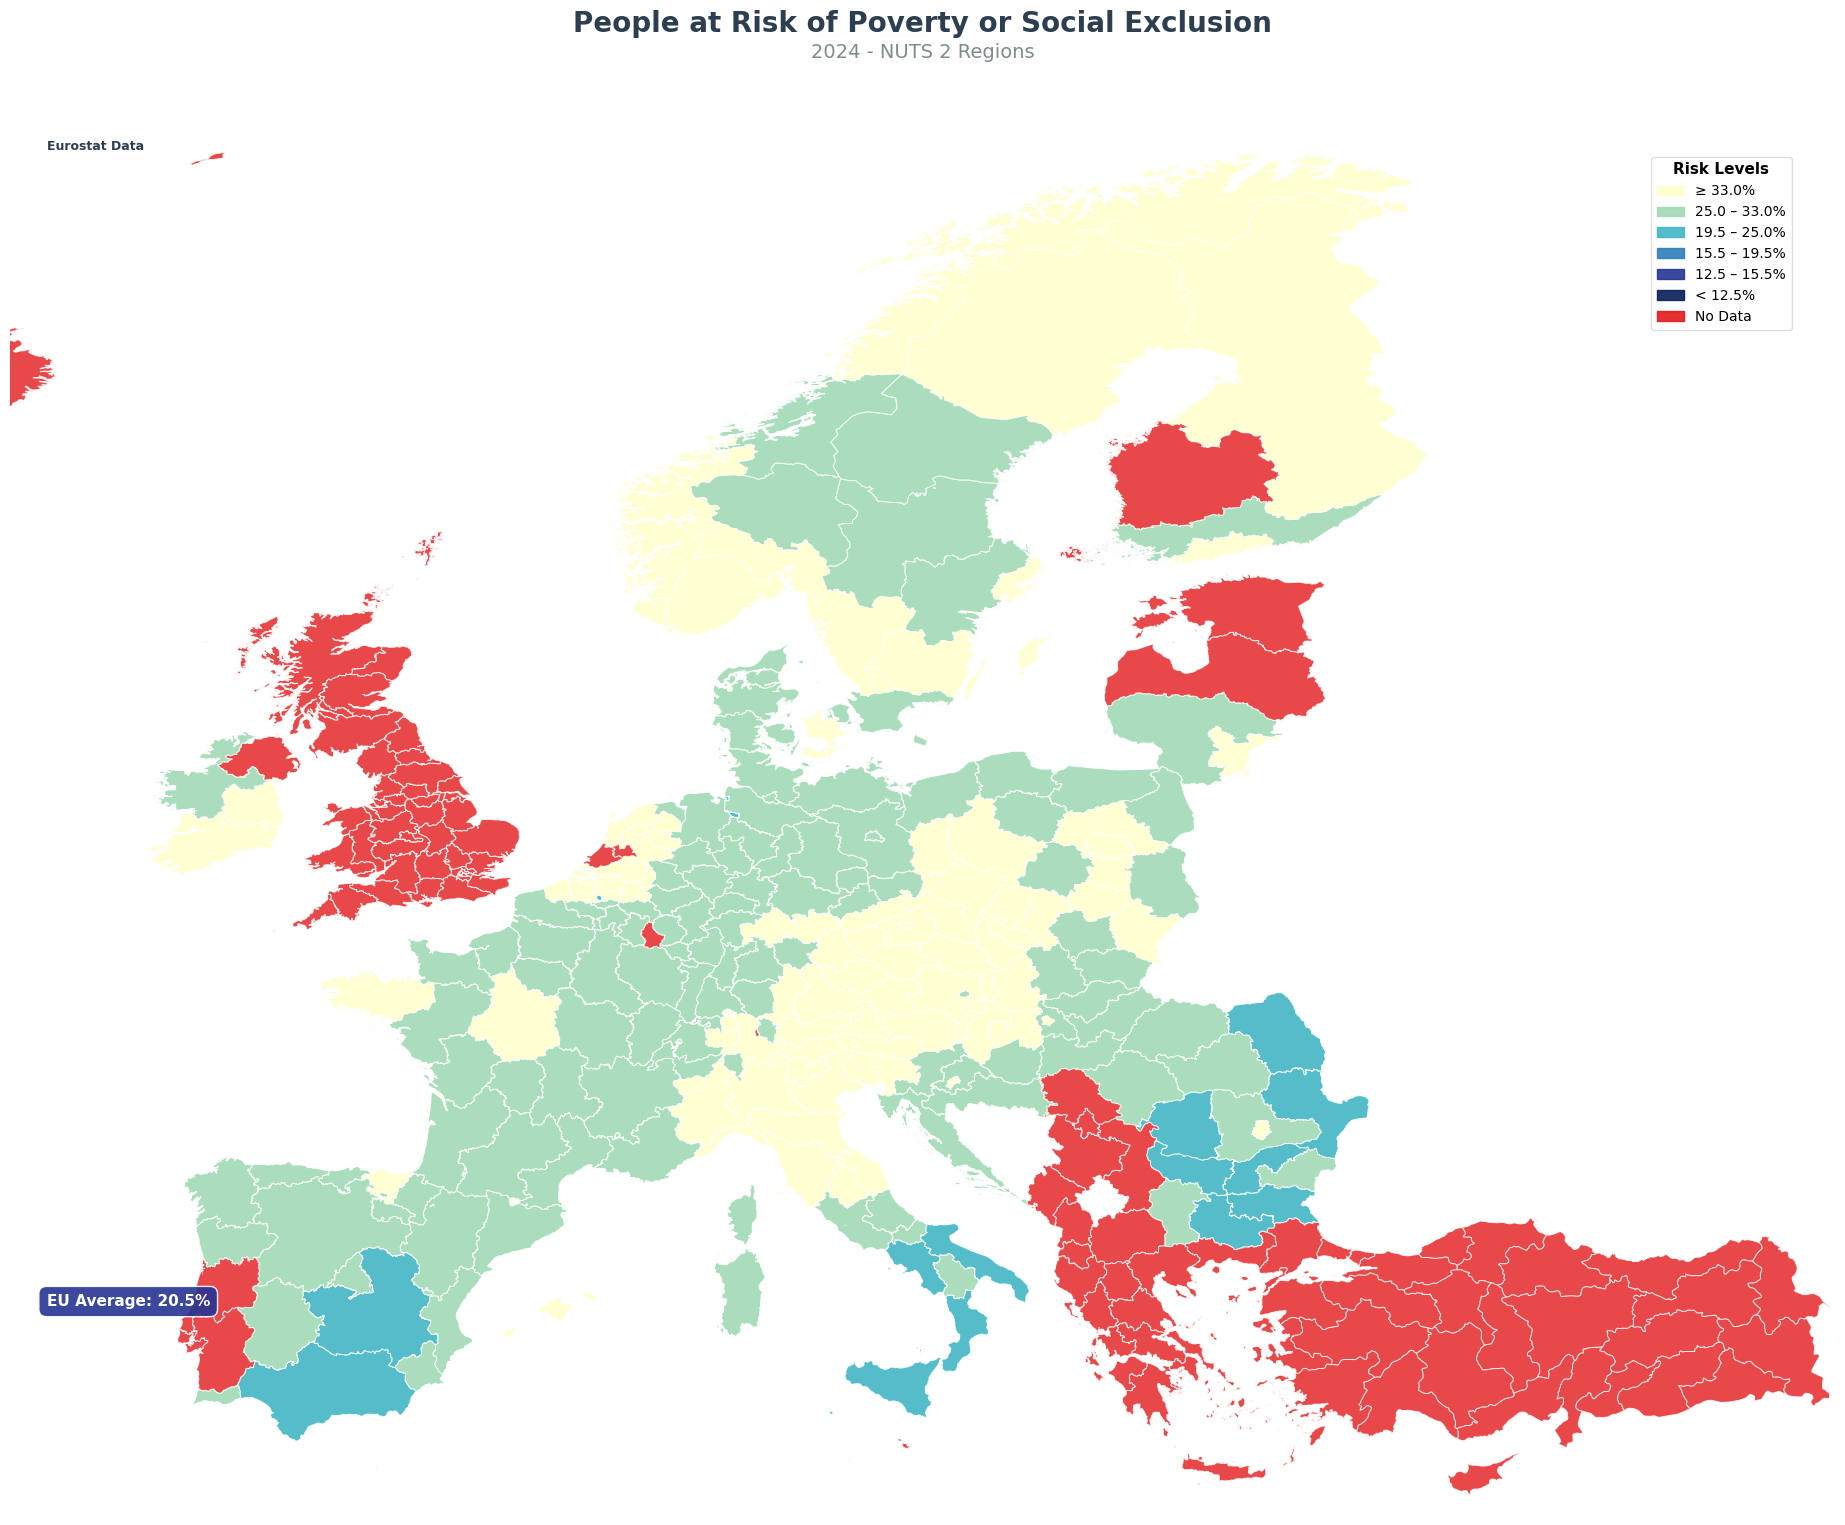

In [43]:
# Simple Clean Version with Perfect Spacing
def create_clean_spaced_map(merged_data, year=2024):
    """
    Create clean map with perfect spacing and visible colors
    """
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    
    # Bright visible colors
    colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494', '#081d58']
    missing_color = '#e31a1c'
    
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    cmap = LinearSegmentedColormap.from_list('clean_colors', colors, N=len(bins)-1)
    
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        data_regions = merged_data[merged_data['poverty_rate'].notna()]
        if len(data_regions) > 0:
            data_regions.plot(column='poverty_rate', ax=ax, 
                             cmap=cmap, 
                             legend=False,
                             edgecolor='white', 
                             linewidth=0.7,
                             alpha=0.9,
                             vmin=0, vmax=100)
        
        no_data_regions = merged_data[merged_data['poverty_rate'].isna()]
        if len(no_data_regions) > 0:
            no_data_regions.plot(ax=ax, color=missing_color, edgecolor='white', 
                               linewidth=0.7, alpha=0.8)
    
    ax.set_facecolor('white')
    ax.set_xlim(-15, 45)
    ax.set_ylim(34, 72)
    
    # PERFECTLY SPACED TITLES
    fig.suptitle('People at Risk of Poverty or Social Exclusion', 
                 fontsize=20, fontweight='bold', y=0.95, color='#2c3e50')
    
    # Use fig.text instead of plt.title for better control
    fig.text(0.5, 0.92, f'{year} - NUTS 2 Regions', 
             fontsize=14, color='#7f8c8d', ha='center', fontweight='normal')
    
    if merged_data is not None and 'poverty_rate' in merged_data.columns:
        available_data = merged_data[merged_data['poverty_rate'].notna()]
        eu_avg = available_data['poverty_rate'].mean() if len(available_data) > 0 else 21.0
    else:
        eu_avg = 21.0
    
    # Well-positioned elements
    ax.text(0.02, 0.15, f'EU Average: {eu_avg:.1f}%', transform=ax.transAxes, 
            fontsize=11, fontweight='bold', color='white',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="#253494", edgecolor='white', alpha=0.9))
    
    # Clean legend
    legend_labels = ['≥ 33.0%', '25.0 – 33.0%', '19.5 – 25.0%', 
                    '15.5 – 19.5%', '12.5 – 15.5%', '< 12.5%', 'No Data']
    legend_colors = colors + [missing_color]
    
    patches = [mpatches.Patch(color=c, label=l, alpha=0.9) 
               for c, l in zip(legend_colors, legend_labels)]
    
    legend = ax.legend(handles=patches, loc='upper right', bbox_to_anchor=(0.98, 0.98), 
              frameon=True, fancybox=True, shadow=False, ncol=1,
              title='Risk Levels', title_fontsize=11,
              fontsize=10, facecolor='white', edgecolor='#ddd', framealpha=0.95)
    legend.get_title().set_fontweight('bold')
    
    ax.text(0.02, 0.98, 'Eurostat Data', 
            transform=ax.transAxes, fontsize=9, fontweight='bold', color='#2c3e50')
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Extra space for titles
    return fig, ax

print("Creating clean spaced map...")
fig_clean, ax_clean = create_clean_spaced_map(europe_poverty_map_improved)
plt.show()



In [32]:
# Save the fixed versions
def save_fixed_visualizations():
    """
    Save all fixed visualizations
    """
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    fig_fixed.savefig(f'fixed_visual_map_{timestamp}.png', 
                     dpi=400, bbox_inches='tight', facecolor='white')
    fig_contrast.savefig(f'high_contrast_map_{timestamp}.png', 
                        dpi=400, bbox_inches='tight', facecolor='white')
    fig_clean.savefig(f'clean_spaced_map_{timestamp}.png', 
                     dpi=400, bbox_inches='tight', facecolor='white')
    
    print("✅ FIXED MAPS SAVED!")
    print("   🎨 fixed_visual_map - Vibrant colors, no overlap")
    print("   🔥 high_contrast_map - Extreme visibility")
    print("   ✨ clean_spaced_map - Perfect spacing")
    print("   📁 All with non-overlapping titles and visible colors!")

# Save fixed versions
save_fixed_visualizations()



✅ FIXED MAPS SAVED!
   🎨 fixed_visual_map - Vibrant colors, no overlap
   🔥 high_contrast_map - Extreme visibility
   ✨ clean_spaced_map - Perfect spacing
   📁 All with non-overlapping titles and visible colors!


🎯 ENHANCED EUROPEAN POVERTY ANALYSIS
🚀 STARTING COMPREHENSIVE ANALYSIS
=== TEMPORAL TREND ANALYSIS ===
Available years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


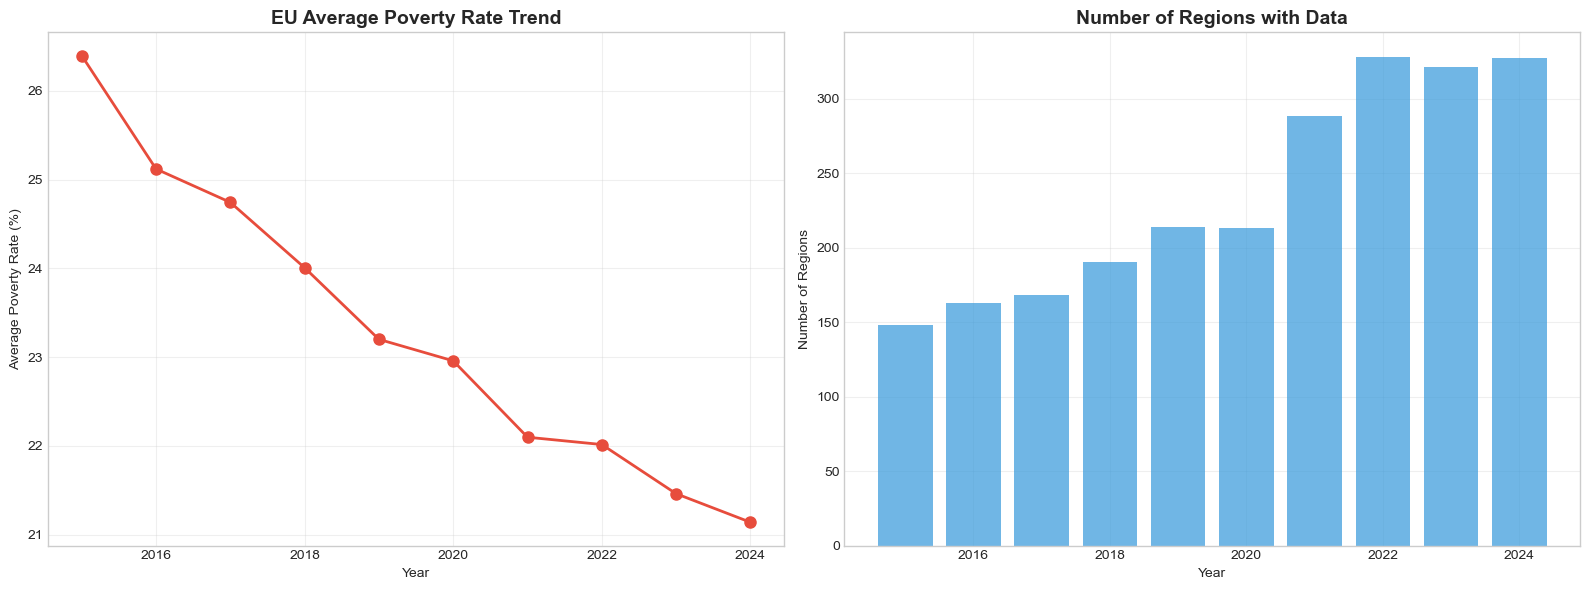

=== REGIONAL CLUSTERING ANALYSIS ===
Cluster Statistics:
        poverty_rate                         
               count   mean   std   min   max
cluster                                      
0                 84  20.50  1.82  17.4  24.0
1                 24  39.15  5.75  33.8  59.5
2                 94  13.87  2.45   6.6  17.1
3                 40  27.82  2.67  24.5  33.2


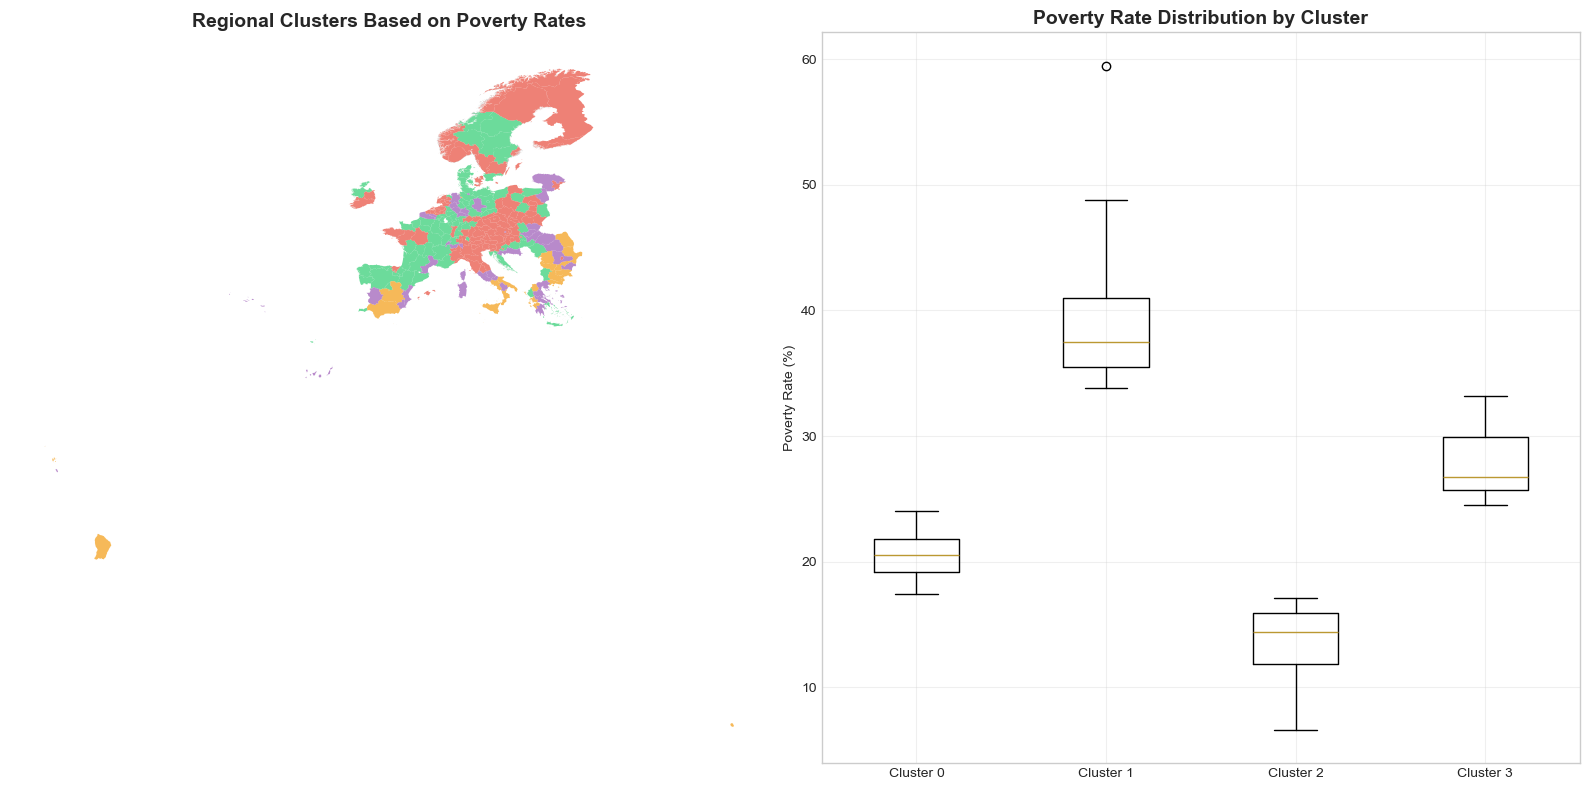

=== INEQUALITY ANALYSIS ===


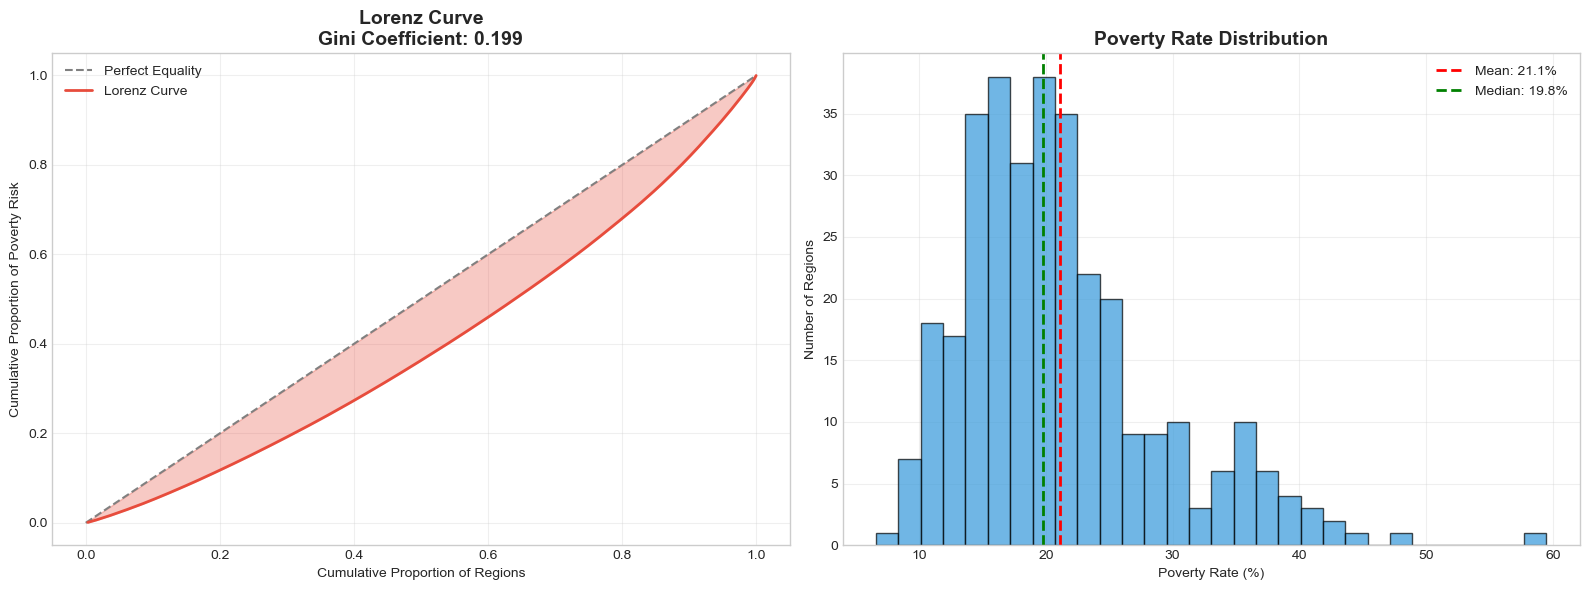

Gini Coefficient: 0.199
Mean: 21.14%
Median: 19.80%
Standard Deviation: 7.88%
=== SPATIAL AUTOCORRELATION ANALYSIS ===


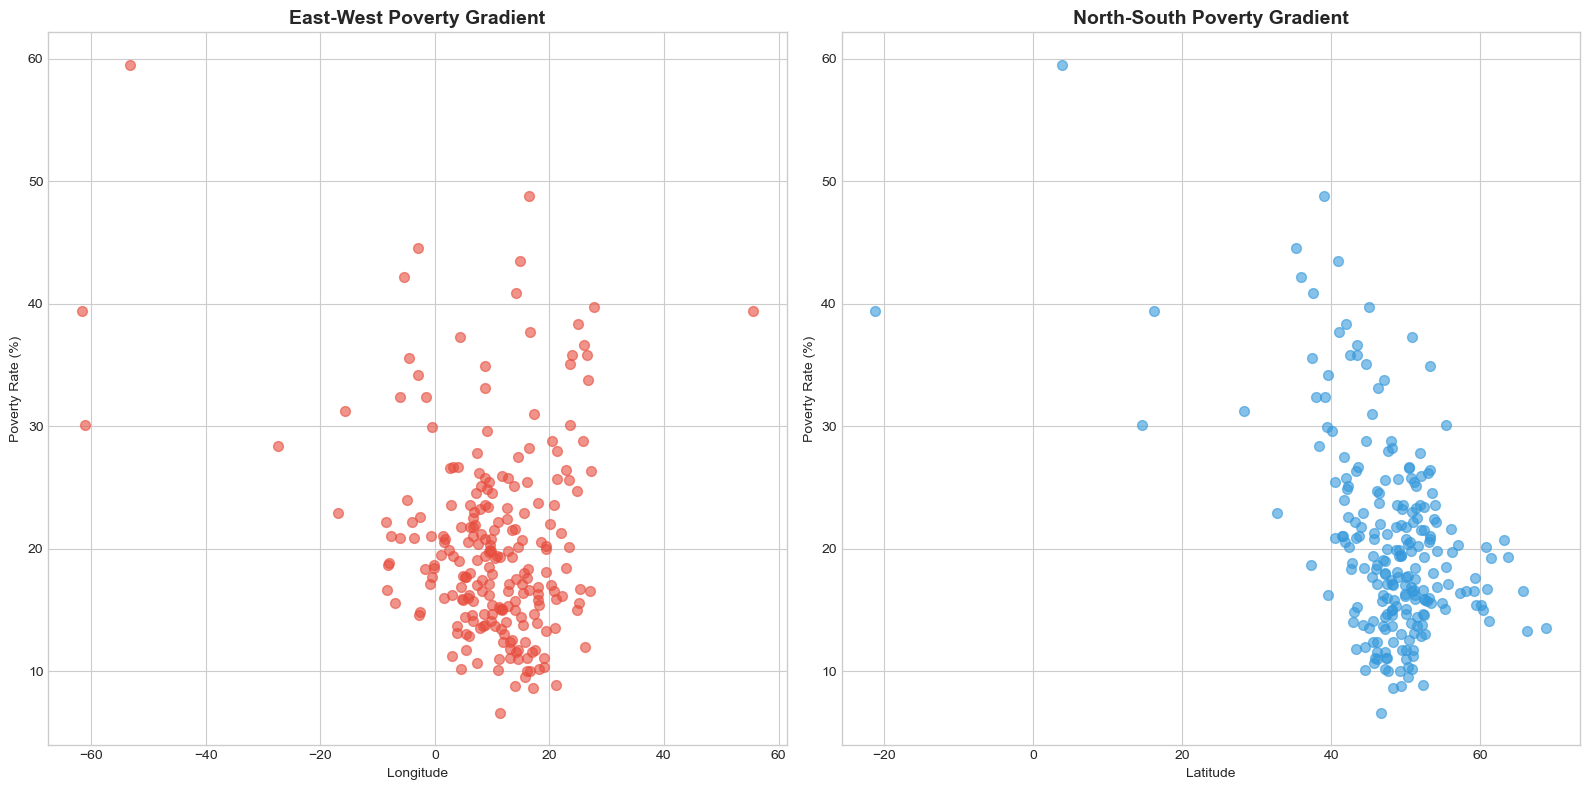

Longitude-Poverty Correlation: -0.191
Latitude-Poverty Correlation: -0.497
=== COUNTRY-LEVEL COMPARATIVE ANALYSIS ===


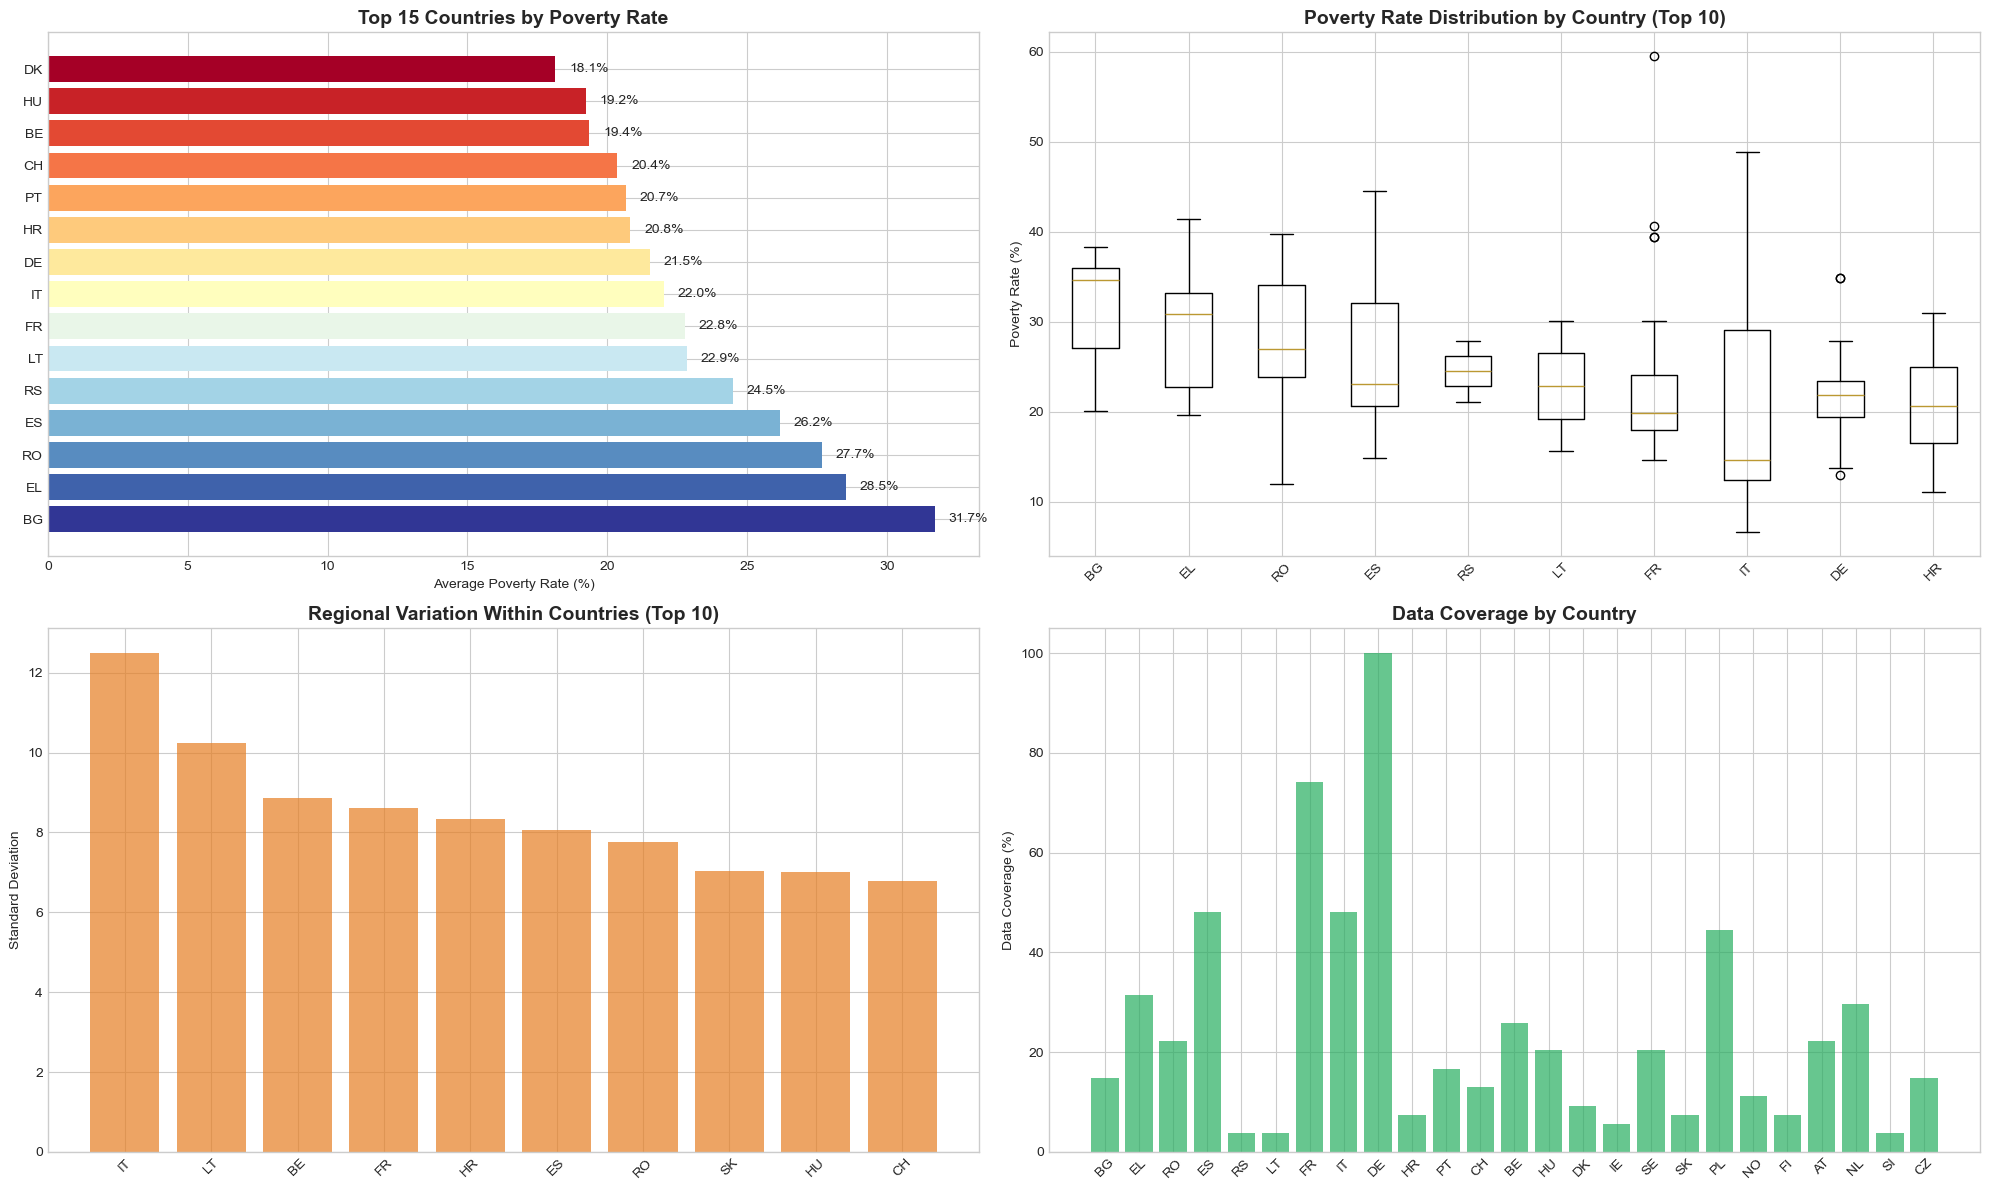

=== CORRELATION ANALYSIS ===


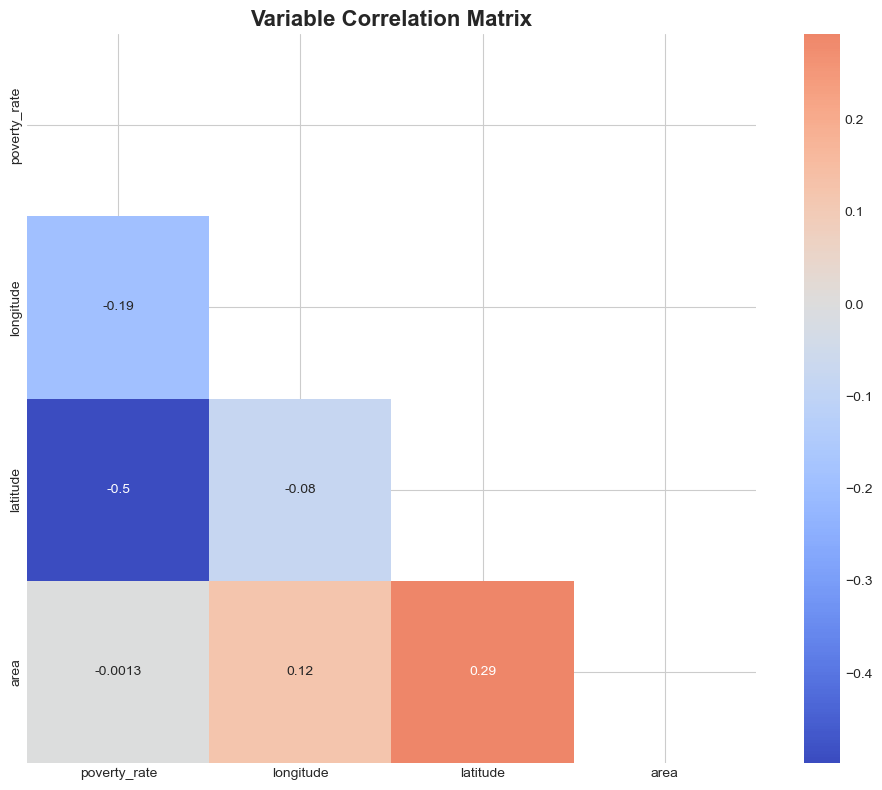

=== ADVANCED DISTRIBUTION ANALYSIS ===


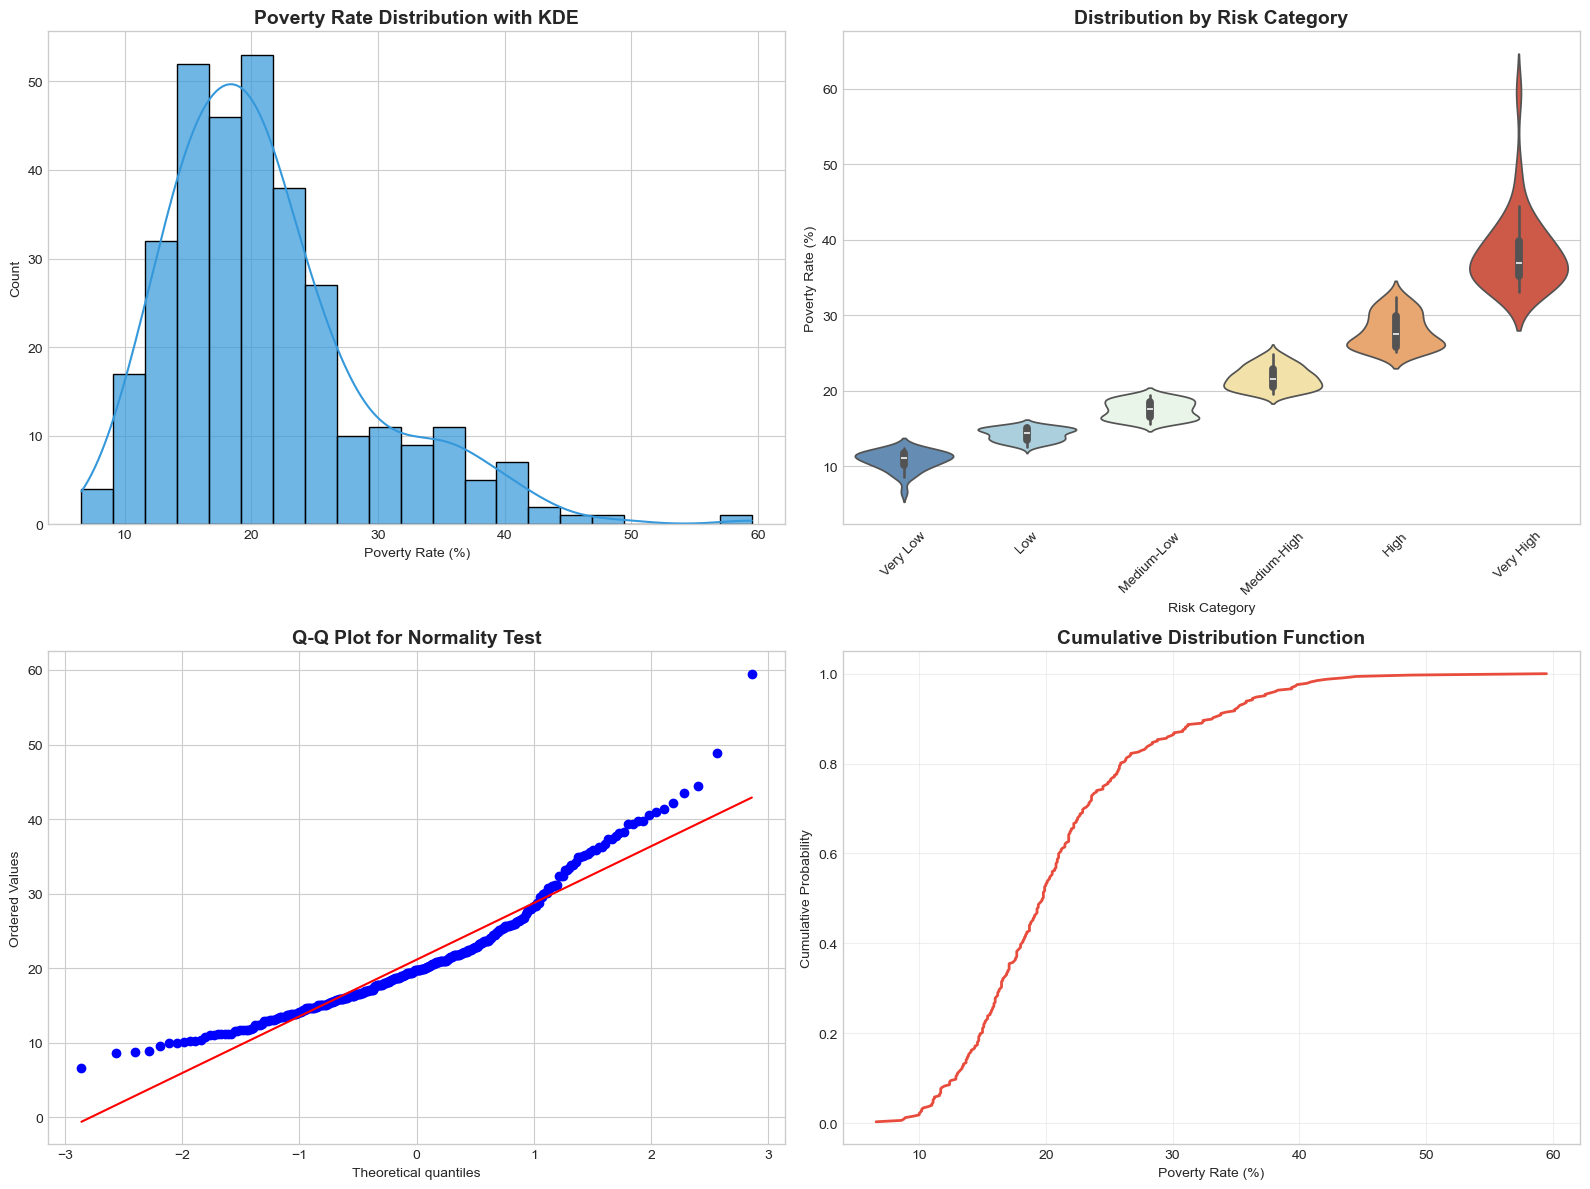

Statistical Tests:
Skewness: 1.192
Kurtosis: 1.899
Normality test p-value: 0.0000
Distribution is not normal
=== COMPREHENSIVE COMPARISON DASHBOARD ===


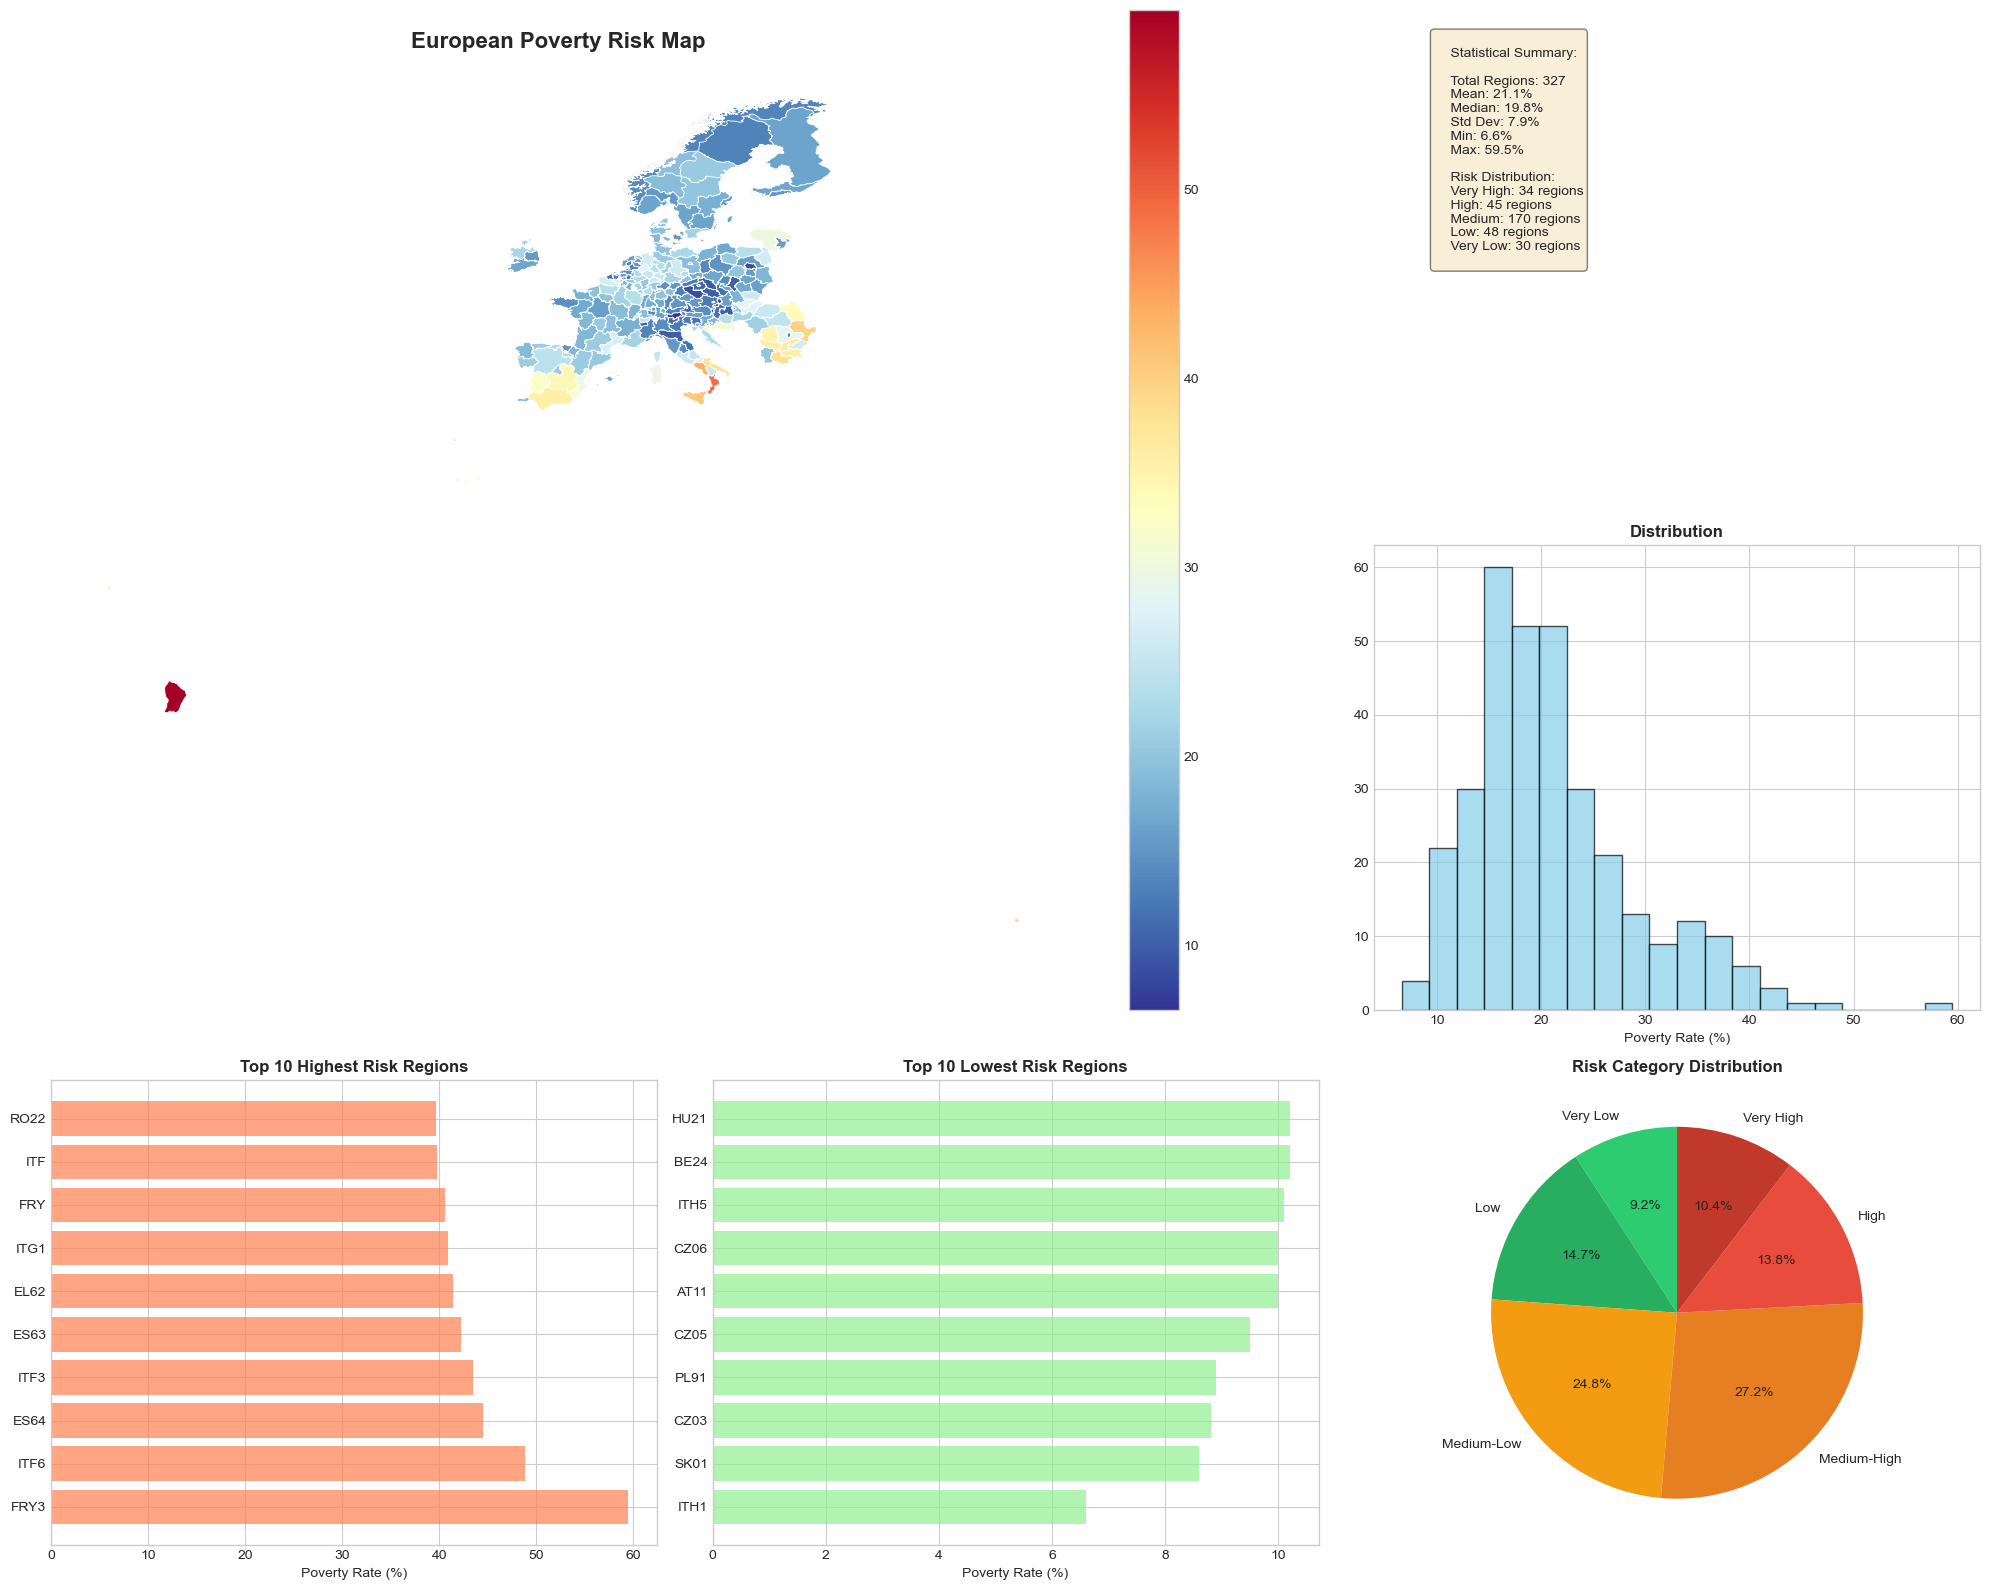

✅ COMPREHENSIVE ANALYSIS COMPLETED
📁 Analysis results saved with timestamp: 20251109_214429

📊 ANALYSIS SUMMARY:
  analysis_date: 20251109_214429
  total_regions: 327
  mean_poverty_rate: 21.139755351681956
  median_poverty_rate: 19.8
  gini_coefficient: 0.19940393360994157
  countries_analyzed: 25


In [44]:
# =============================================================================
# ENHANCED ANALYSIS & VISUALIZATION MODULE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set better styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# =============================================================================
# 1. TEMPORAL ANALYSIS - MULTI-YEAR TRENDS
# =============================================================================

def analyze_temporal_trends(eurostat_data):
    """
    Analyze poverty trends over multiple years
    """
    print("=== TEMPORAL TREND ANALYSIS ===")
    
    # Extract multi-year data
    years = sorted(eurostat_data['TIME_PERIOD'].unique())
    print(f"Available years: {years}")
    
    # Prepare temporal data
    temporal_data = []
    for year in years:
        year_data = eurostat_data[eurostat_data['TIME_PERIOD'] == year].copy()
        nuts2_data = year_data[
            (year_data['geo'].str.len() >= 3) & 
            (year_data['geo'].str.len() <= 4)
        ]
        if len(nuts2_data) > 0:
            avg_poverty = nuts2_data['OBS_VALUE'].mean()
            temporal_data.append({
                'year': year,
                'avg_poverty': avg_poverty,
                'regions_count': len(nuts2_data)
            })
    
    temporal_df = pd.DataFrame(temporal_data)
    
    # Plot temporal trends
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Line plot of average poverty
    ax1.plot(temporal_df['year'], temporal_df['avg_poverty'], 
             marker='o', linewidth=2, markersize=8, color='#e74c3c')
    ax1.set_title('EU Average Poverty Rate Trend', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Poverty Rate (%)')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot of data coverage
    ax2.bar(temporal_df['year'], temporal_df['regions_count'], 
            color='#3498db', alpha=0.7)
    ax2.set_title('Number of Regions with Data', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Regions')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return temporal_df

# =============================================================================
# 2. REGIONAL CLUSTERING ANALYSIS
# =============================================================================

def perform_cluster_analysis(poverty_data, geodata):
    """
    Perform K-means clustering to identify regional patterns
    """
    print("=== REGIONAL CLUSTERING ANALYSIS ===")
    
    # Merge data
    merged = geodata.merge(poverty_data, on='NUTS_ID', how='inner')
    
    # Prepare features for clustering
    features = merged[['poverty_rate']].copy()
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    merged['cluster'] = kmeans.fit_predict(features)
    
    # Analyze clusters
    cluster_stats = merged.groupby('cluster').agg({
        'poverty_rate': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    
    print("Cluster Statistics:")
    print(cluster_stats)
    
    # Visualize clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Cluster map
    colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    for cluster_id in range(4):
        cluster_data = merged[merged['cluster'] == cluster_id]
        cluster_data.plot(ax=ax1, color=colors[cluster_id], 
                         label=f'Cluster {cluster_id}', alpha=0.7)
    
    ax1.set_title('Regional Clusters Based on Poverty Rates', 
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.set_axis_off()
    
    # Box plot by cluster
    cluster_data_list = [merged[merged['cluster'] == i]['poverty_rate'] 
                        for i in range(4)]
    ax2.boxplot(cluster_data_list, labels=[f'Cluster {i}' for i in range(4)])
    ax2.set_title('Poverty Rate Distribution by Cluster', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Poverty Rate (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return merged, cluster_stats

# =============================================================================
# 3. INEQUALITY ANALYSIS - GINI COEFFICIENT & LORENZ CURVE
# =============================================================================

def analyze_inequality(poverty_data):
    """
    Calculate Gini coefficient and plot Lorenz curve
    """
    print("=== INEQUALITY ANALYSIS ===")
    
    # Sort data by poverty rate
    sorted_data = poverty_data.sort_values('poverty_rate')
    
    # Calculate cumulative sums for Lorenz curve
    total_population = len(sorted_data)  # Assuming equal population per region for simplicity
    cumulative_population = np.arange(1, total_population + 1) / total_population
    cumulative_poverty = sorted_data['poverty_rate'].cumsum() / sorted_data['poverty_rate'].sum()
    
    # Calculate Gini coefficient
    gini = 1 - 2 * np.trapz(cumulative_poverty, cumulative_population)
    
    # Plot Lorenz curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Lorenz curve
    ax1.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Equality')
    ax1.plot(cumulative_population, cumulative_poverty, 
             color='#e74c3c', linewidth=2, label='Lorenz Curve')
    ax1.fill_between(cumulative_population, cumulative_population, cumulative_poverty, 
                    alpha=0.3, color='#e74c3c')
    ax1.set_title(f'Lorenz Curve\nGini Coefficient: {gini:.3f}', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Cumulative Proportion of Regions')
    ax1.set_ylabel('Cumulative Proportion of Poverty Risk')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Poverty distribution histogram with inequality metrics
    ax2.hist(poverty_data['poverty_rate'], bins=30, alpha=0.7, 
             color='#3498db', edgecolor='black')
    ax2.axvline(poverty_data['poverty_rate'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {poverty_data["poverty_rate"].mean():.1f}%')
    ax2.axvline(poverty_data['poverty_rate'].median(), color='green', 
                linestyle='--', linewidth=2, label=f'Median: {poverty_data["poverty_rate"].median():.1f}%')
    
    ax2.set_title('Poverty Rate Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Poverty Rate (%)')
    ax2.set_ylabel('Number of Regions')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Gini Coefficient: {gini:.3f}")
    print(f"Mean: {poverty_data['poverty_rate'].mean():.2f}%")
    print(f"Median: {poverty_data['poverty_rate'].median():.2f}%")
    print(f"Standard Deviation: {poverty_data['poverty_rate'].std():.2f}%")
    
    return gini

# =============================================================================
# 4. SPATIAL AUTOCORRELATION ANALYSIS
# =============================================================================

def analyze_spatial_autocorrelation(merged_data):
    """
    Analyze spatial patterns and autocorrelation
    """
    print("=== SPATIAL AUTOCORRELATION ANALYSIS ===")
    
    # Calculate centroids for spatial analysis
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    
    # Create spatial bins for analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Scatter plot of poverty vs longitude (East-West gradient)
    ax1.scatter(merged_data['longitude'], merged_data['poverty_rate'], 
                alpha=0.6, color='#e74c3c', s=50)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Poverty Rate (%)')
    ax1.set_title('East-West Poverty Gradient', fontsize=14, fontweight='bold')
    
    # Add trend line
    z = np.polyfit(merged_data['longitude'], merged_data['poverty_rate'], 1)
    p = np.poly1d(z)
    ax1.plot(merged_data['longitude'], p(merged_data['longitude']), 
             "r--", alpha=0.8)
    
    # Scatter plot of poverty vs latitude (North-South gradient)
    ax2.scatter(merged_data['latitude'], merged_data['poverty_rate'], 
                alpha=0.6, color='#3498db', s=50)
    ax2.set_xlabel('Latitude')
    ax2.set_ylabel('Poverty Rate (%)')
    ax2.set_title('North-South Poverty Gradient', fontsize=14, fontweight='bold')
    
    # Add trend line
    z = np.polyfit(merged_data['latitude'], merged_data['poverty_rate'], 1)
    p = np.poly1d(z)
    ax2.plot(merged_data['latitude'], p(merged_data['latitude']), 
             "b--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation coefficients
    lon_corr = merged_data['longitude'].corr(merged_data['poverty_rate'])
    lat_corr = merged_data['latitude'].corr(merged_data['poverty_rate'])
    
    print(f"Longitude-Poverty Correlation: {lon_corr:.3f}")
    print(f"Latitude-Poverty Correlation: {lat_corr:.3f}")

# =============================================================================
# 5. COUNTRY-LEVEL COMPARATIVE ANALYSIS
# =============================================================================

def country_comparative_analysis(poverty_data):
    """
    Detailed country-level comparative analysis
    """
    print("=== COUNTRY-LEVEL COMPARATIVE ANALYSIS ===")
    
    # Add country codes
    poverty_data['country_code'] = poverty_data['NUTS_ID'].str[:2]
    
    # Calculate country statistics
    country_stats = poverty_data.groupby('country_code').agg({
        'poverty_rate': ['count', 'mean', 'median', 'std', 'min', 'max']
    }).round(2)
    
    country_stats.columns = ['region_count', 'mean', 'median', 'std', 'min', 'max']
    country_stats = country_stats.sort_values('mean', ascending=False)
    
    # Create comprehensive country comparison visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Country averages bar chart
    top_countries = country_stats.head(15)
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(top_countries)))
    bars = ax1.barh(range(len(top_countries)), top_countries['mean'], color=colors)
    ax1.set_yticks(range(len(top_countries)))
    ax1.set_yticklabels(top_countries.index)
    ax1.set_xlabel('Average Poverty Rate (%)')
    ax1.set_title('Top 15 Countries by Poverty Rate', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
                ha='left', va='center')
    
    # 2. Country distribution box plot
    country_data = []
    country_labels = []
    for country in country_stats.index[:10]:  # Top 10 countries
        country_rates = poverty_data[poverty_data['country_code'] == country]['poverty_rate']
        if len(country_rates) > 0:
            country_data.append(country_rates)
            country_labels.append(country)
    
    ax2.boxplot(country_data, labels=country_labels)
    ax2.set_title('Poverty Rate Distribution by Country (Top 10)', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Poverty Rate (%)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Regional variation within countries
    country_variation = country_stats['std'].sort_values(ascending=False).head(10)
    ax3.bar(range(len(country_variation)), country_variation.values, 
            color='#e67e22', alpha=0.7)
    ax3.set_xticks(range(len(country_variation)))
    ax3.set_xticklabels(country_variation.index, rotation=45)
    ax3.set_ylabel('Standard Deviation')
    ax3.set_title('Regional Variation Within Countries (Top 10)', 
                  fontsize=14, fontweight='bold')
    
    # 4. Country data coverage
    coverage = (country_stats['region_count'] / 
                country_stats['region_count'].max() * 100)
    ax4.bar(range(len(coverage)), coverage.values, color='#27ae60', alpha=0.7)
    ax4.set_xticks(range(len(coverage)))
    ax4.set_xticklabels(coverage.index, rotation=45)
    ax4.set_ylabel('Data Coverage (%)')
    ax4.set_title('Data Coverage by Country', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return country_stats

# =============================================================================
# 6. CORRELATION MATRIX & HEATMAP
# =============================================================================

def create_correlation_analysis(merged_data):
    """
    Create correlation matrix and heatmap for spatial variables
    """
    print("=== CORRELATION ANALYSIS ===")
    
    # Calculate additional spatial variables
    merged_data['area'] = merged_data.geometry.area
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    
    # Select variables for correlation
    variables = ['poverty_rate', 'longitude', 'latitude', 'area']
    correlation_data = merged_data[variables].copy()
    
    # Calculate correlation matrix
    corr_matrix = correlation_data.corr()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, ax=ax)
    ax.set_title('Variable Correlation Matrix', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# =============================================================================
# 7. ADVANCED HISTOGRAMS & DISTRIBUTION ANALYSIS
# =============================================================================

def advanced_distribution_analysis(poverty_data):
    """
    Create advanced distribution visualizations
    """
    print("=== ADVANCED DISTRIBUTION ANALYSIS ===")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Enhanced histogram with KDE
    sns.histplot(data=poverty_data, x='poverty_rate', kde=True, ax=ax1, 
                 color='#3498db', alpha=0.7)
    ax1.set_title('Poverty Rate Distribution with KDE', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Poverty Rate (%)')
    
    # 2. Violin plot by risk category
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    labels = ['Very Low', 'Low', 'Medium-Low', 'Medium-High', 'High', 'Very High']
    poverty_data['risk_category'] = pd.cut(poverty_data['poverty_rate'], 
                                          bins=bins, labels=labels, right=False)
    
    sns.violinplot(data=poverty_data, x='risk_category', y='poverty_rate', 
                   ax=ax2, palette='RdYlBu_r')
    ax2.set_title('Distribution by Risk Category', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Risk Category')
    ax2.set_ylabel('Poverty Rate (%)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. QQ plot for normality test
    stats.probplot(poverty_data['poverty_rate'], dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot for Normality Test', fontsize=14, fontweight='bold')
    
    # 4. Cumulative distribution function
    sorted_rates = np.sort(poverty_data['poverty_rate'])
    cdf = np.arange(1, len(sorted_rates) + 1) / len(sorted_rates)
    ax4.plot(sorted_rates, cdf, linewidth=2, color='#e74c3c')
    ax4.set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Poverty Rate (%)')
    ax4.set_ylabel('Cumulative Probability')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("Statistical Tests:")
    print(f"Skewness: {stats.skew(poverty_data['poverty_rate']):.3f}")
    print(f"Kurtosis: {stats.kurtosis(poverty_data['poverty_rate']):.3f}")
    
    # Normality test
    stat, p_value = stats.normaltest(poverty_data['poverty_rate'])
    print(f"Normality test p-value: {p_value:.4f}")
    print("Distribution is " + ("normal" if p_value > 0.05 else "not normal"))

# =============================================================================
# 8. INTERACTIVE COMPARISON DASHBOARD
# =============================================================================

def create_comparison_dashboard(poverty_data, merged_data):
    """
    Create a comprehensive comparison dashboard
    """
    print("=== COMPREHENSIVE COMPARISON DASHBOARD ===")
    
    # Create a multi-panel dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # Define grid layout
    gs = fig.add_gridspec(3, 3)
    
    # 1. Main map (top left, 2x2)
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    if 'poverty_rate' in merged_data.columns:
        merged_data.plot(column='poverty_rate', ax=ax1, cmap='RdYlBu_r', 
                        legend=True, edgecolor='white', linewidth=0.5)
    ax1.set_title('European Poverty Risk Map', fontsize=16, fontweight='bold')
    ax1.set_axis_off()
    
    # 2. Statistical summary (top right)
    ax2 = fig.add_subplot(gs[0, 2])
    stats_text = f"""
    Statistical Summary:
    
    Total Regions: {len(poverty_data)}
    Mean: {poverty_data['poverty_rate'].mean():.1f}%
    Median: {poverty_data['poverty_rate'].median():.1f}%
    Std Dev: {poverty_data['poverty_rate'].std():.1f}%
    Min: {poverty_data['poverty_rate'].min():.1f}%
    Max: {poverty_data['poverty_rate'].max():.1f}%
    
    Risk Distribution:
    Very High: {(poverty_data['poverty_rate'] >= 33).sum()} regions
    High: {((poverty_data['poverty_rate'] >= 25) & (poverty_data['poverty_rate'] < 33)).sum()} regions
    Medium: {((poverty_data['poverty_rate'] >= 15.5) & (poverty_data['poverty_rate'] < 25)).sum()} regions
    Low: {((poverty_data['poverty_rate'] >= 12.5) & (poverty_data['poverty_rate'] < 15.5)).sum()} regions
    Very Low: {(poverty_data['poverty_rate'] < 12.5).sum()} regions
    """
    ax2.text(0.1, 0.95, stats_text, transform=ax2.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.set_axis_off()
    
    # 3. Histogram (middle right)
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.hist(poverty_data['poverty_rate'], bins=20, color='skyblue', 
             edgecolor='black', alpha=0.7)
    ax3.set_title('Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Poverty Rate (%)')
    
    # 4. Top 10 regions (bottom left)
    ax4 = fig.add_subplot(gs[2, 0])
    top_regions = poverty_data.nlargest(10, 'poverty_rate')
    ax4.barh(range(len(top_regions)), top_regions['poverty_rate'], 
             color='coral', alpha=0.7)
    ax4.set_yticks(range(len(top_regions)))
    ax4.set_yticklabels(top_regions['NUTS_ID'])
    ax4.set_title('Top 10 Highest Risk Regions', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Poverty Rate (%)')
    
    # 5. Bottom 10 regions (bottom middle)
    ax5 = fig.add_subplot(gs[2, 1])
    bottom_regions = poverty_data.nsmallest(10, 'poverty_rate')
    ax5.barh(range(len(bottom_regions)), bottom_regions['poverty_rate'], 
             color='lightgreen', alpha=0.7)
    ax5.set_yticks(range(len(bottom_regions)))
    ax5.set_yticklabels(bottom_regions['NUTS_ID'])
    ax5.set_title('Top 10 Lowest Risk Regions', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Poverty Rate (%)')
    
    # 6. Risk category pie chart (bottom right)
    ax6 = fig.add_subplot(gs[2, 2])
    risk_counts = [
        (poverty_data['poverty_rate'] < 12.5).sum(),
        ((poverty_data['poverty_rate'] >= 12.5) & (poverty_data['poverty_rate'] < 15.5)).sum(),
        ((poverty_data['poverty_rate'] >= 15.5) & (poverty_data['poverty_rate'] < 19.5)).sum(),
        ((poverty_data['poverty_rate'] >= 19.5) & (poverty_data['poverty_rate'] < 25)).sum(),
        ((poverty_data['poverty_rate'] >= 25) & (poverty_data['poverty_rate'] < 33)).sum(),
        (poverty_data['poverty_rate'] >= 33).sum()
    ]
    labels = ['Very Low', 'Low', 'Medium-Low', 'Medium-High', 'High', 'Very High']
    colors = ['#2ecc71', '#27ae60', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
    ax6.pie(risk_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax6.set_title('Risk Category Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def perform_comprehensive_analysis(eurostat_data, poverty_data, merged_data):
    """
    Execute all enhanced analyses
    """
    print("🚀 STARTING COMPREHENSIVE ANALYSIS")
    print("=" * 60)
    
    # 1. Temporal analysis
    temporal_df = analyze_temporal_trends(eurostat_data)
    
    # 2. Clustering analysis
    clustered_data, cluster_stats = perform_cluster_analysis(poverty_data, nuts_geodata)
    
    # 3. Inequality analysis
    gini_coefficient = analyze_inequality(poverty_data)
    
    # 4. Spatial autocorrelation
    analyze_spatial_autocorrelation(merged_data)
    
    # 5. Country-level analysis
    country_stats = country_comparative_analysis(poverty_data)
    
    # 6. Correlation analysis
    corr_matrix = create_correlation_analysis(merged_data)
    
    # 7. Advanced distribution analysis
    advanced_distribution_analysis(poverty_data)
    
    # 8. Comprehensive dashboard
    create_comparison_dashboard(poverty_data, merged_data)
    
    print("=" * 60)
    print("✅ COMPREHENSIVE ANALYSIS COMPLETED")
    
    return {
        'temporal_data': temporal_df,
        'clustered_data': clustered_data,
        'gini_coefficient': gini_coefficient,
        'country_stats': country_stats,
        'correlation_matrix': corr_matrix
    }

# =============================================================================
# EXECUTE THE ENHANCED ANALYSIS
# =============================================================================

print("🎯 ENHANCED EUROPEAN POVERTY ANALYSIS")
print("=" * 50)

# Execute all analyses
results = perform_comprehensive_analysis(eurostat_data, poverty_data_real, europe_poverty_map_improved)

# Save results to files
def save_analysis_results(results, poverty_data):
    """
    Save all analysis results to files
    """
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save statistical summary
    summary = {
        'analysis_date': timestamp,
        'total_regions': len(poverty_data),
        'mean_poverty_rate': poverty_data['poverty_rate'].mean(),
        'median_poverty_rate': poverty_data['poverty_rate'].median(),
        'gini_coefficient': results['gini_coefficient'],
        'countries_analyzed': len(results['country_stats'])
    }
    
    # Save to CSV files
    poverty_data.to_csv(f'poverty_data_detailed_{timestamp}.csv', index=False)
    results['country_stats'].to_csv(f'country_statistics_{timestamp}.csv')
    results['temporal_data'].to_csv(f'temporal_trends_{timestamp}.csv', index=False)
    
    print(f"📁 Analysis results saved with timestamp: {timestamp}")
    return summary

# Save results
analysis_summary = save_analysis_results(results, poverty_data_real)
print("\n📊 ANALYSIS SUMMARY:")
for key, value in analysis_summary.items():
    print(f"  {key}: {value}")


    

🚀 STARTING ENHANCED EUROPEAN POVERTY ANALYSIS
📈 Analyzing temporal trends...
=== TEMPORAL TREND ANALYSIS ===
Available years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


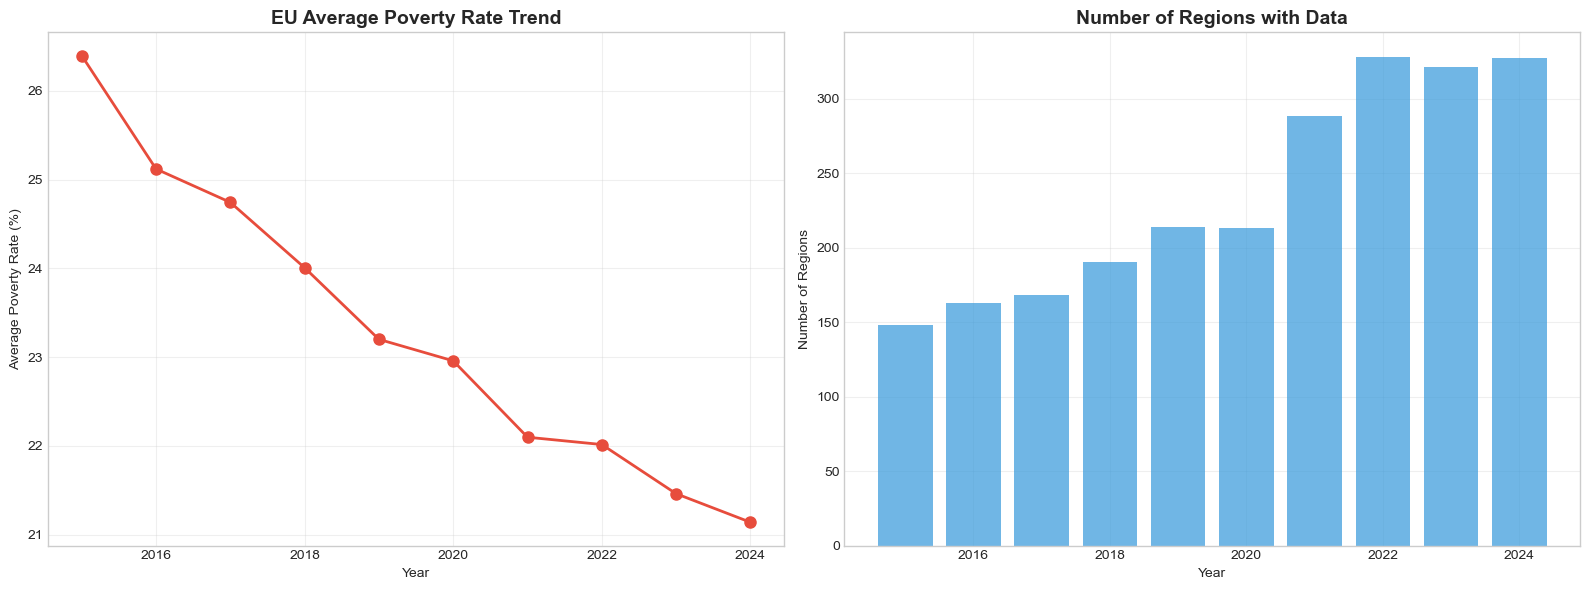

⚖️ Analyzing inequality...
=== INEQUALITY ANALYSIS ===


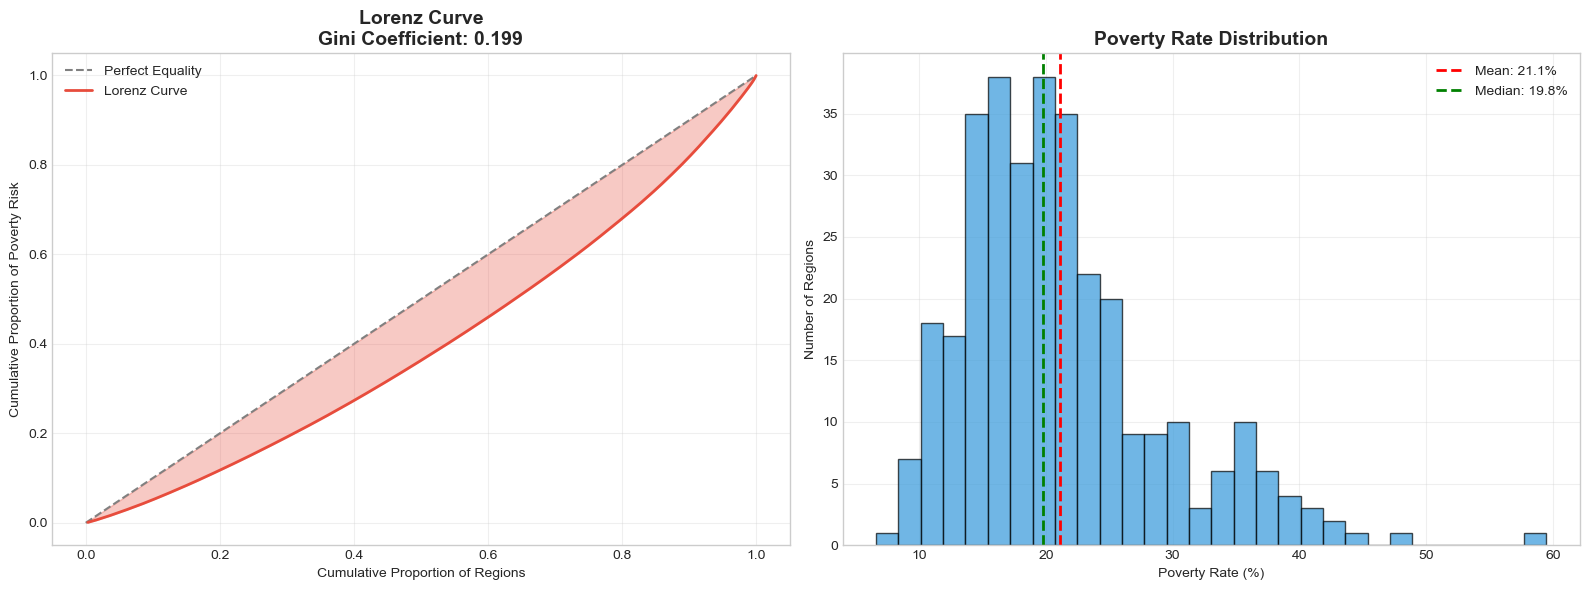

Gini Coefficient: 0.199
Mean: 21.14%
Median: 19.80%
Standard Deviation: 7.88%
🌍 Analyzing country-level patterns...
=== COUNTRY-LEVEL COMPARATIVE ANALYSIS ===


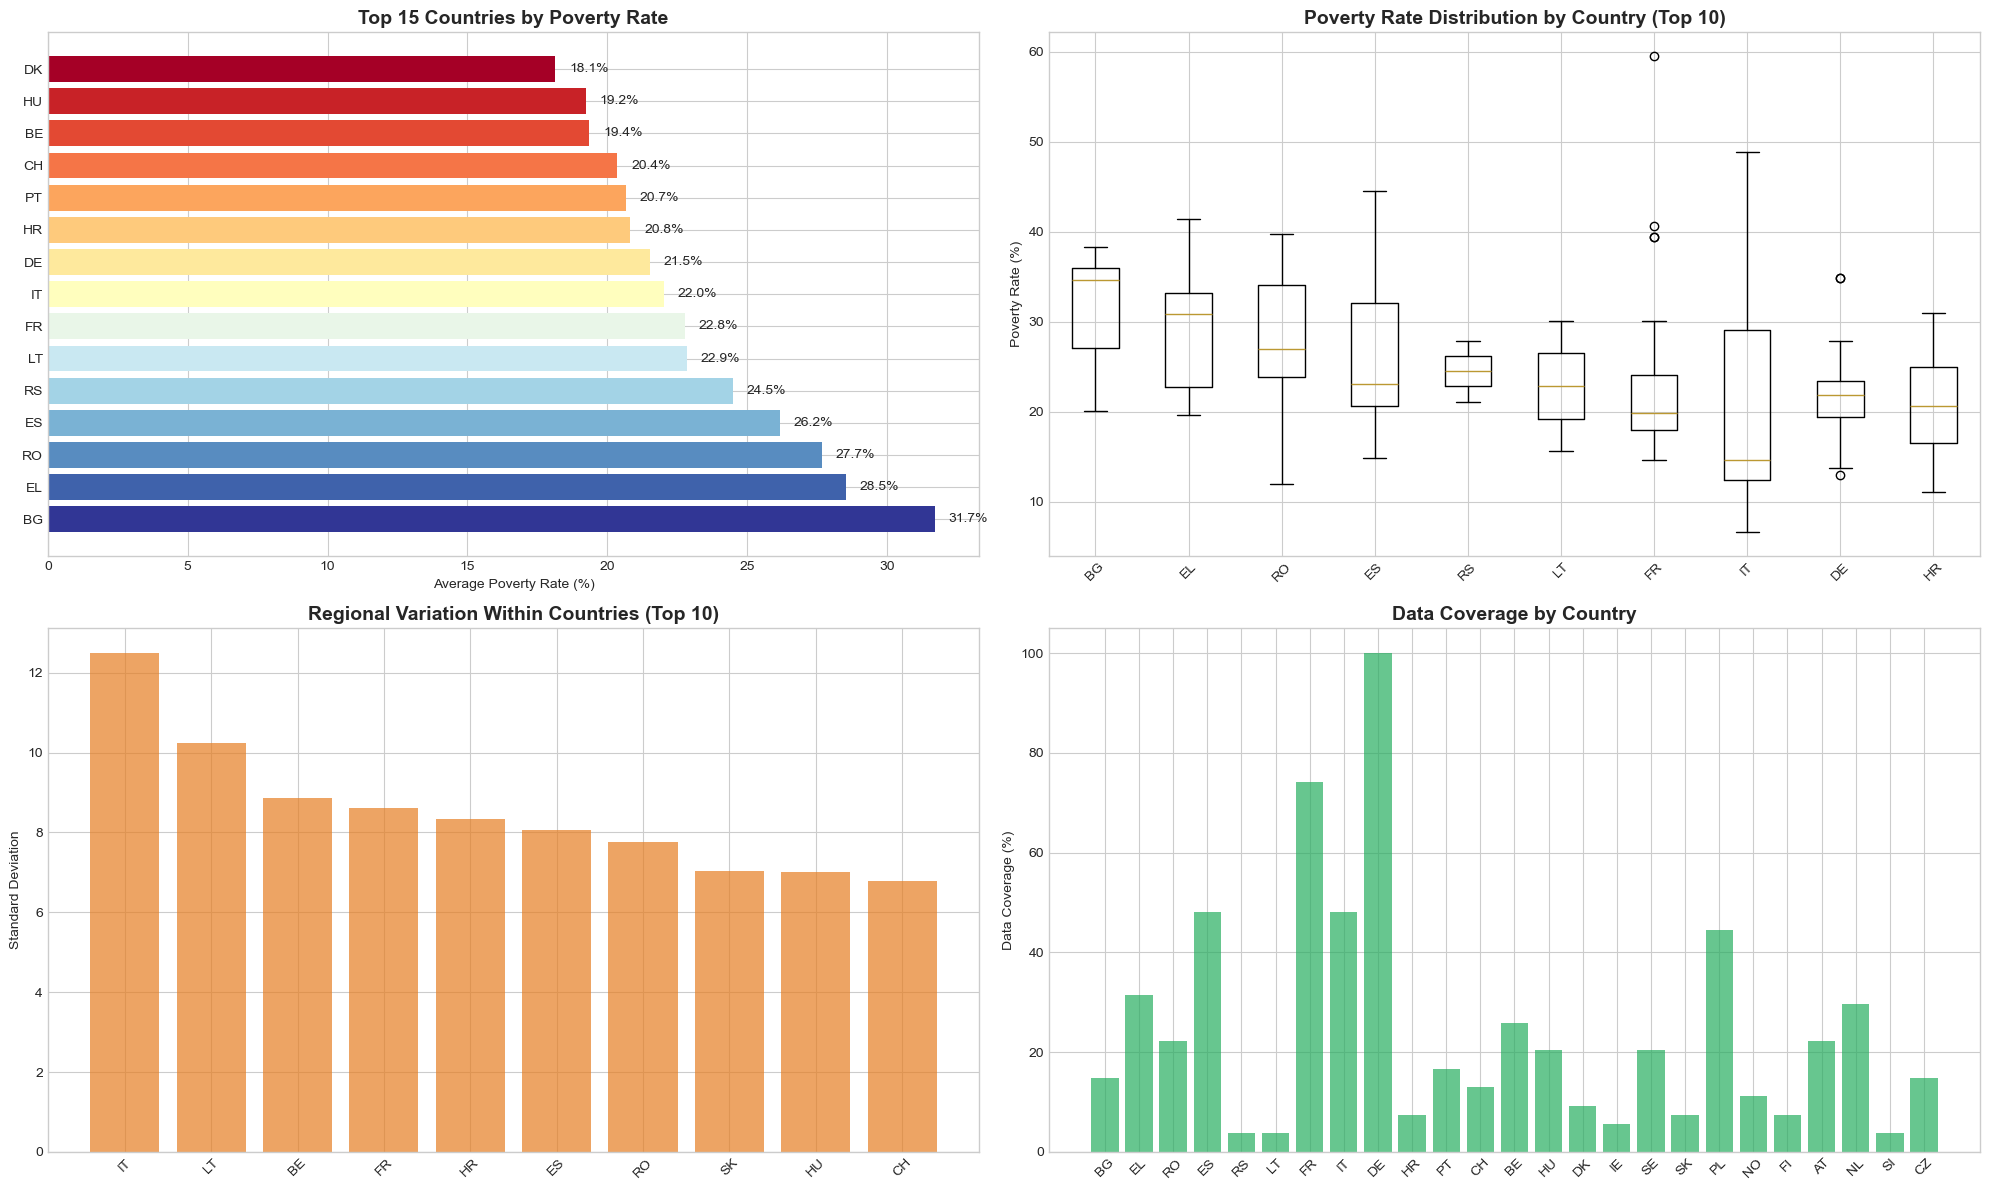

📊 Analyzing advanced distributions...
=== ADVANCED DISTRIBUTION ANALYSIS ===


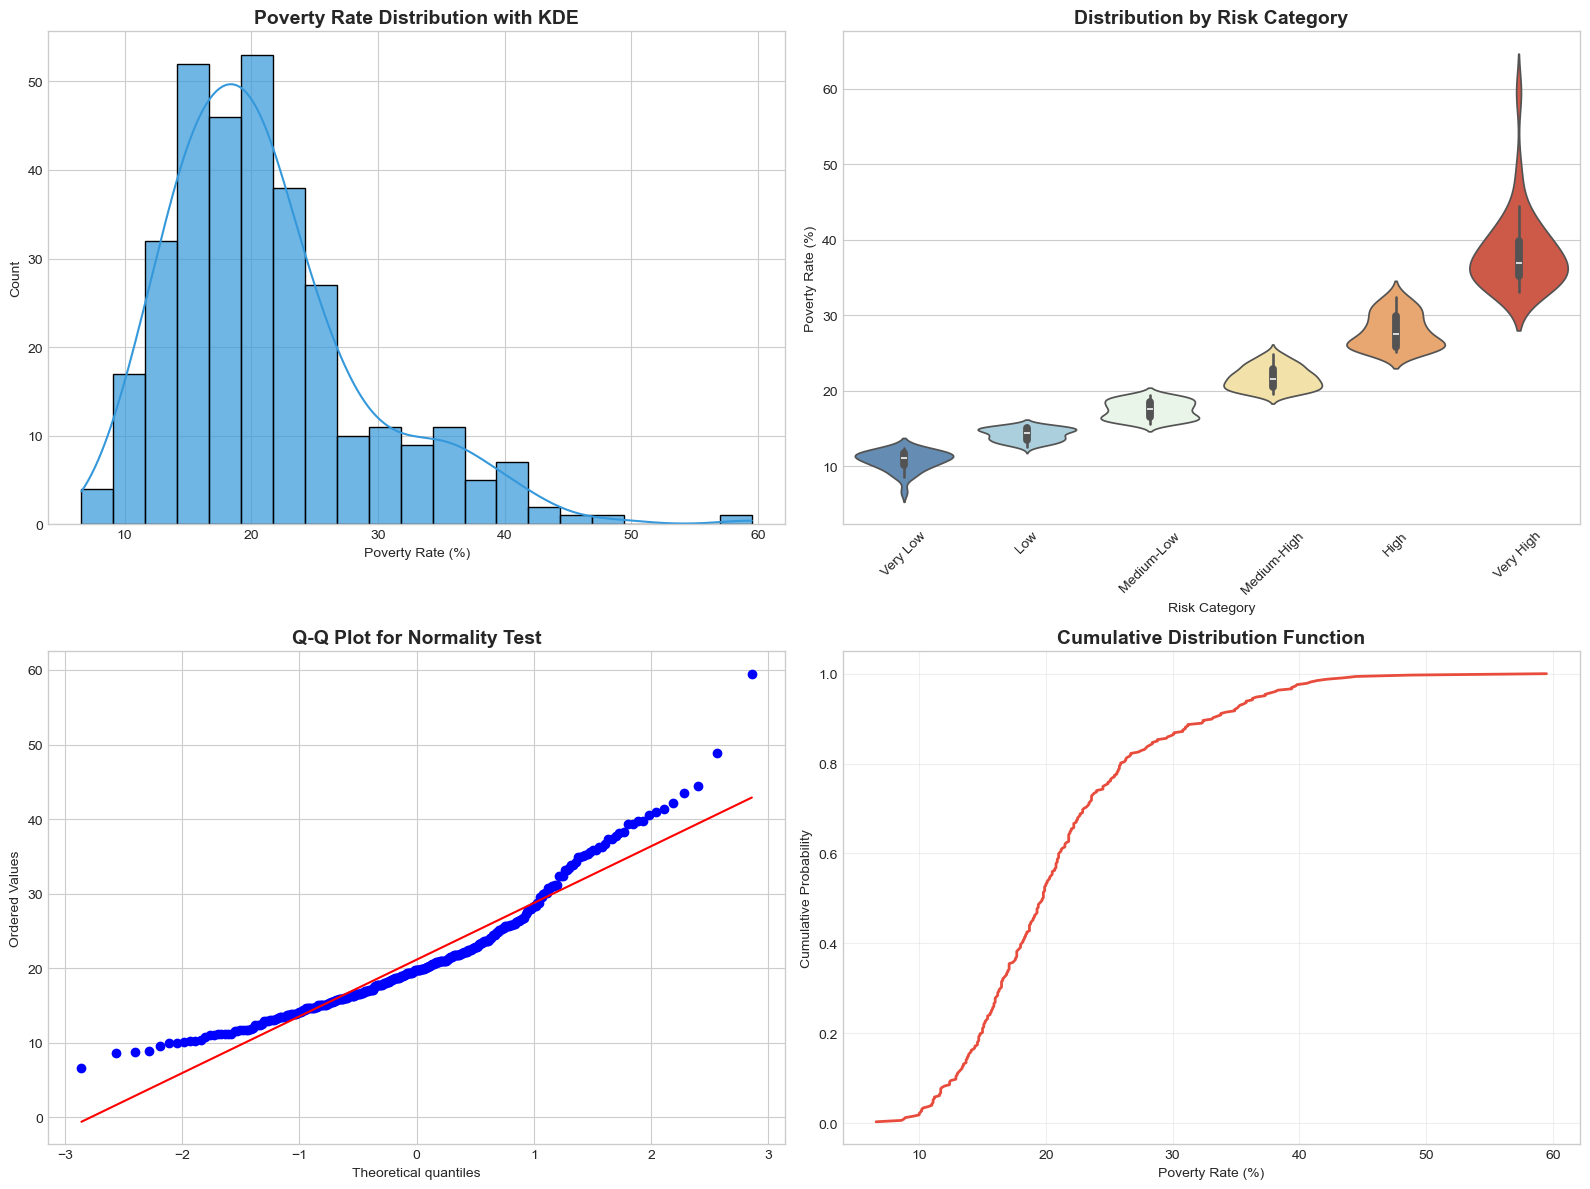

Statistical Tests:
Skewness: 1.192
Kurtosis: 1.899
Normality test p-value: 0.0000
Distribution is not normal
🔗 Analyzing correlations...
=== CORRELATION ANALYSIS ===


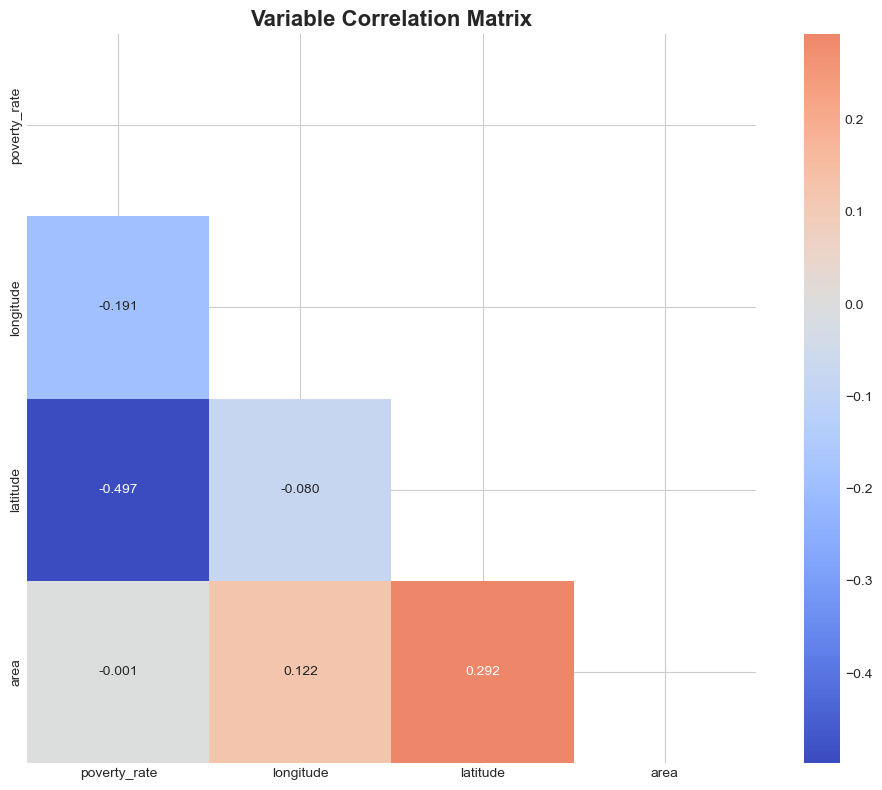

📋 Creating comprehensive dashboard...
=== COMPREHENSIVE COMPARISON DASHBOARD ===


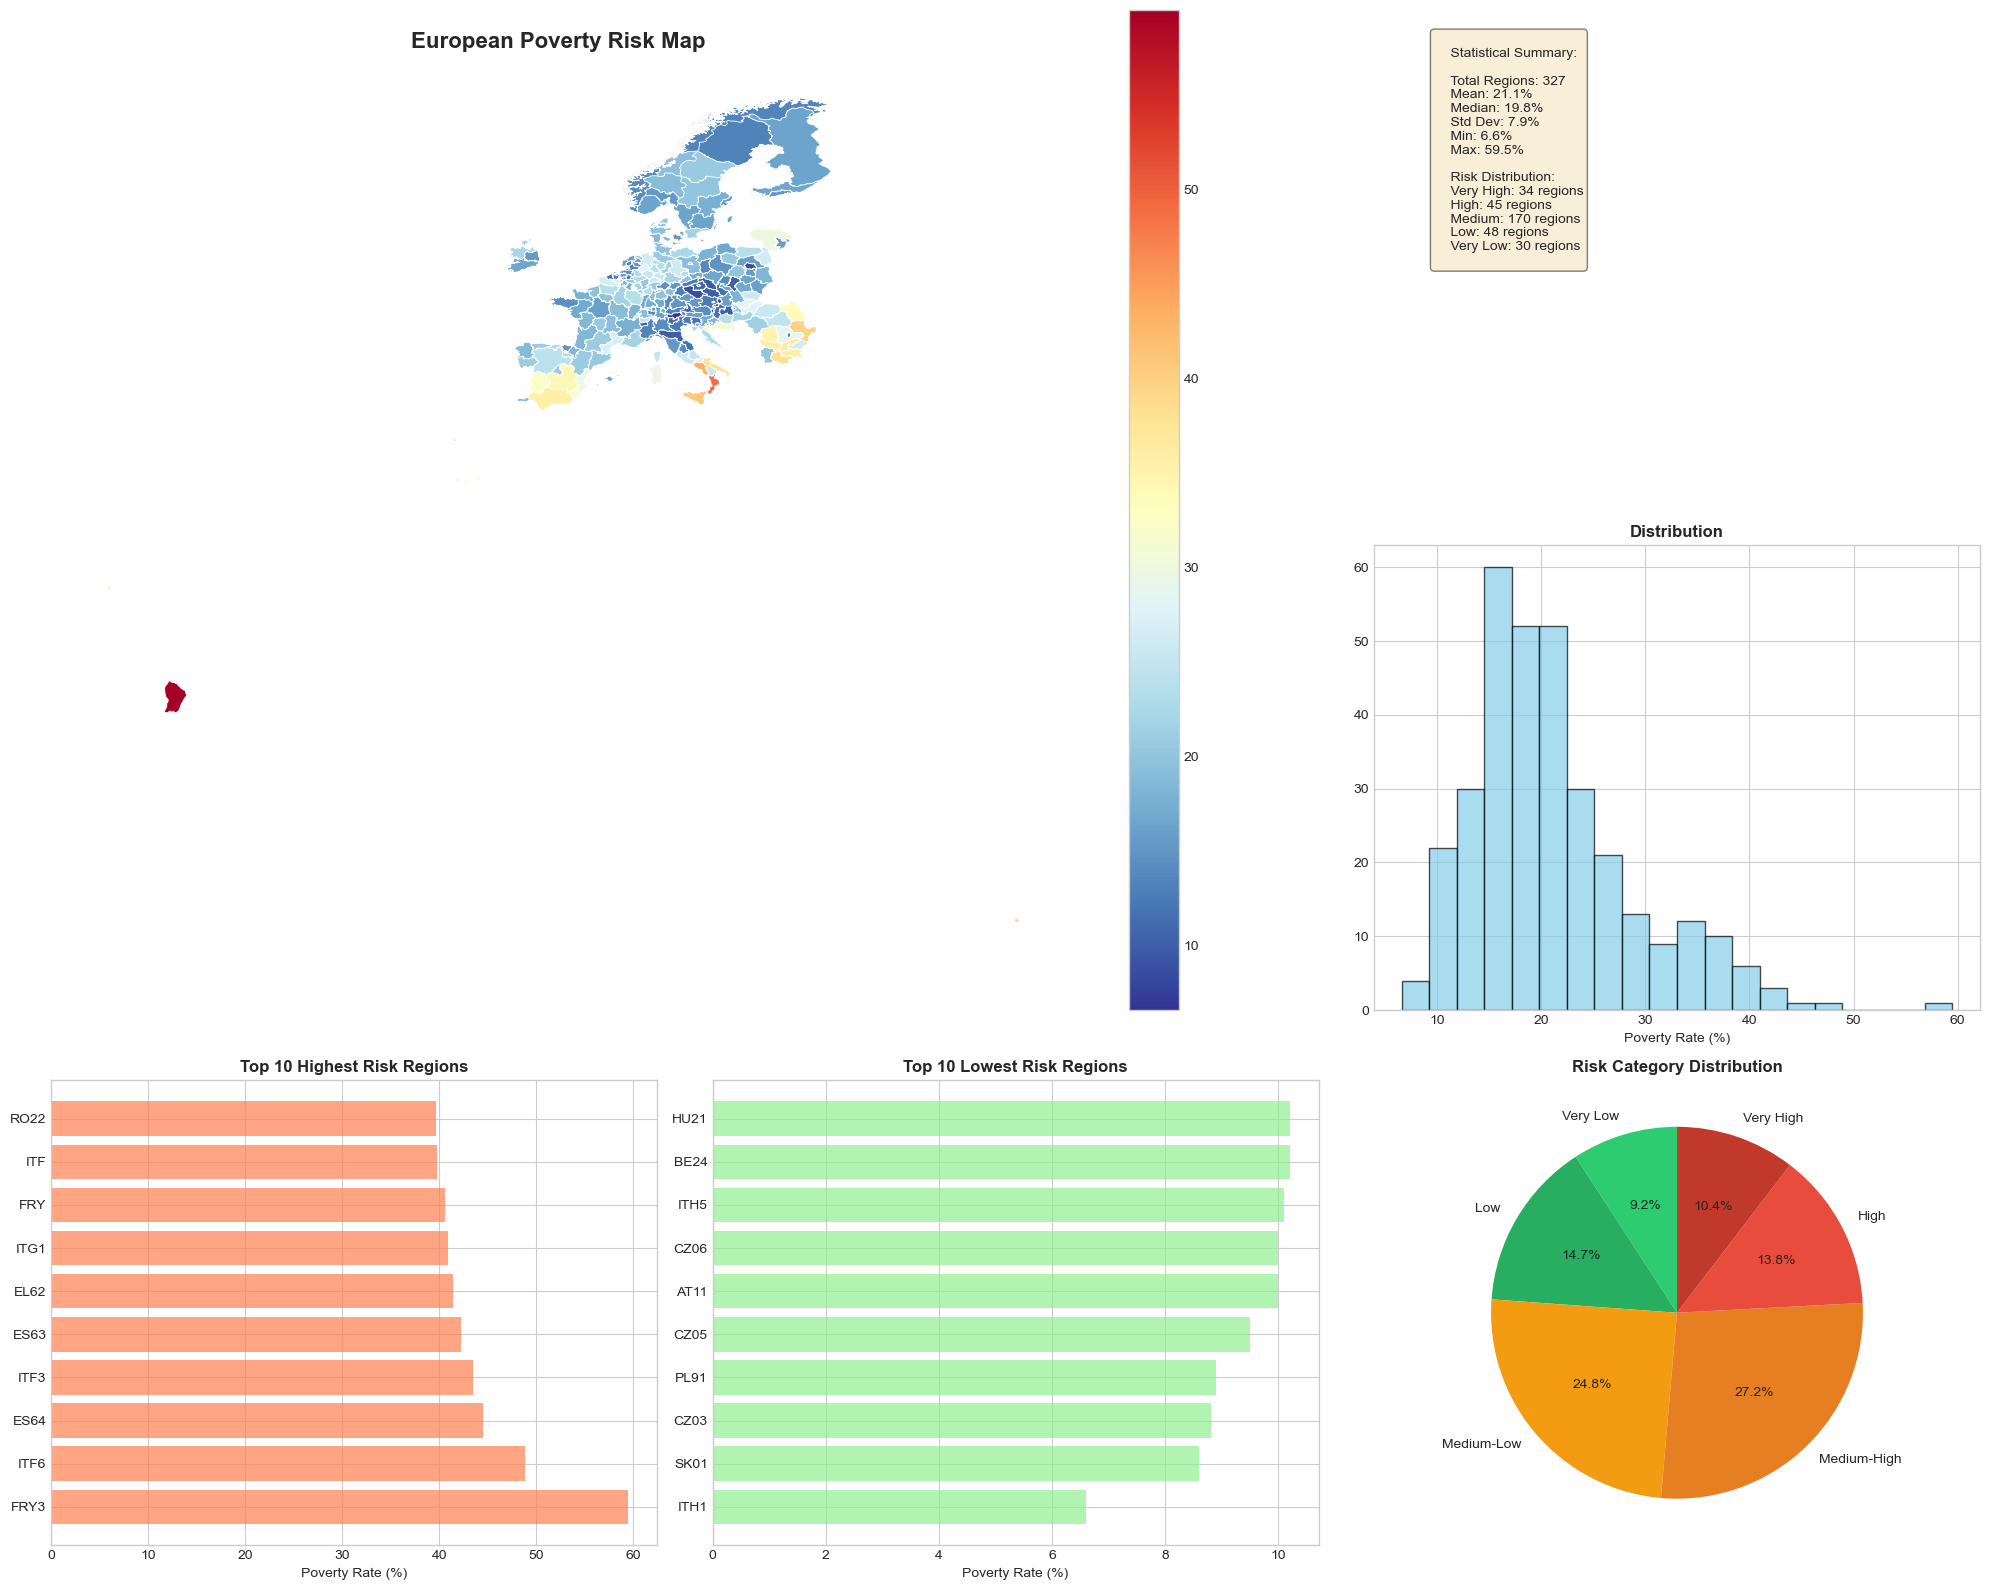

🔍 Performing regional clustering...
=== REGIONAL CLUSTERING ANALYSIS ===
Cluster Statistics:
        poverty_rate                         
               count   mean   std   min   max
cluster                                      
0                 84  20.50  1.82  17.4  24.0
1                 24  39.15  5.75  33.8  59.5
2                 94  13.87  2.45   6.6  17.1
3                 40  27.82  2.67  24.5  33.2


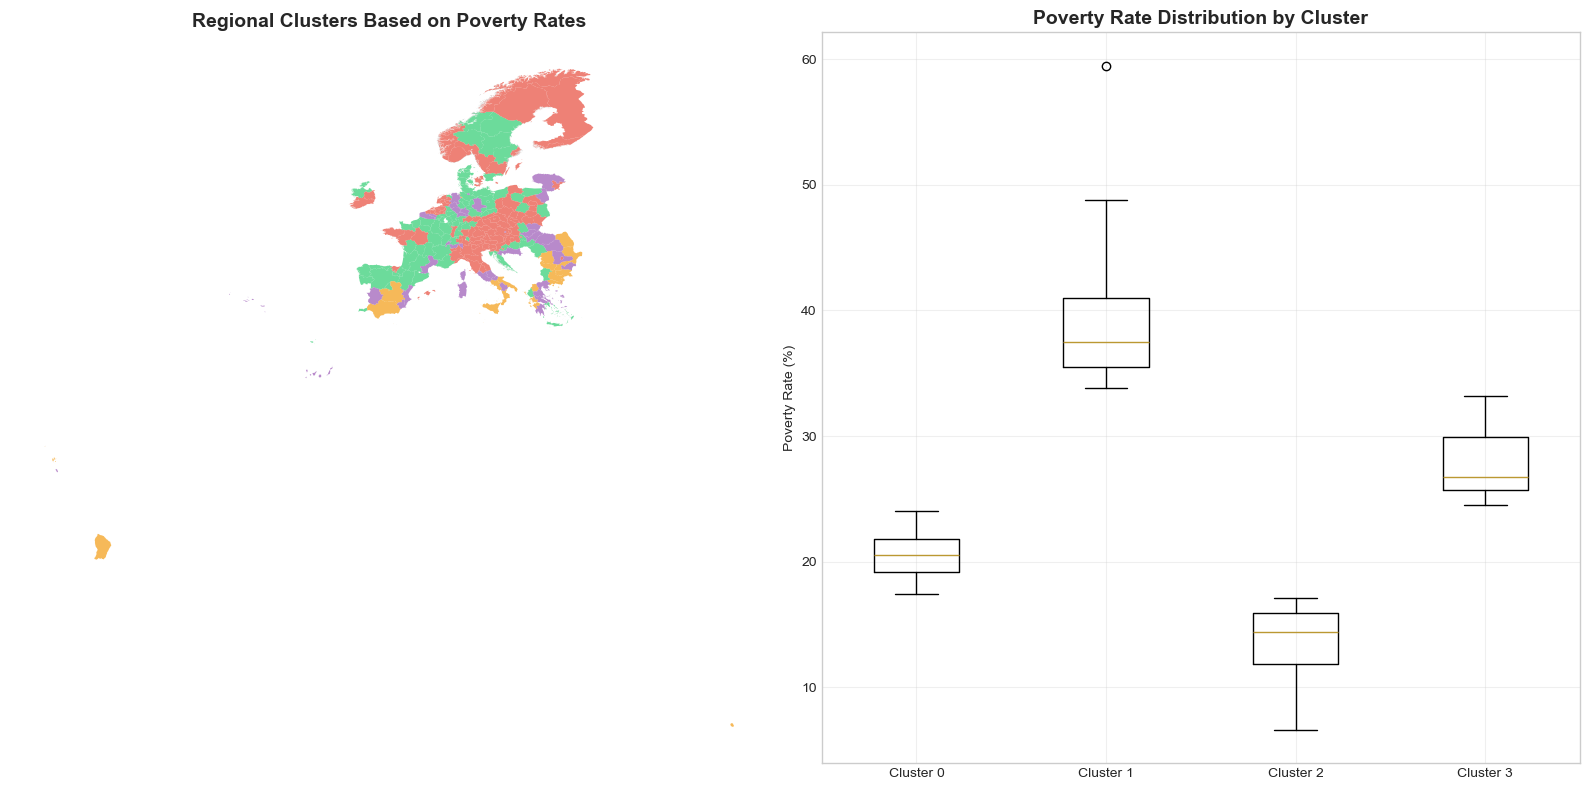

🗺️ Analyzing spatial patterns...
=== SPATIAL AUTOCORRELATION ANALYSIS ===


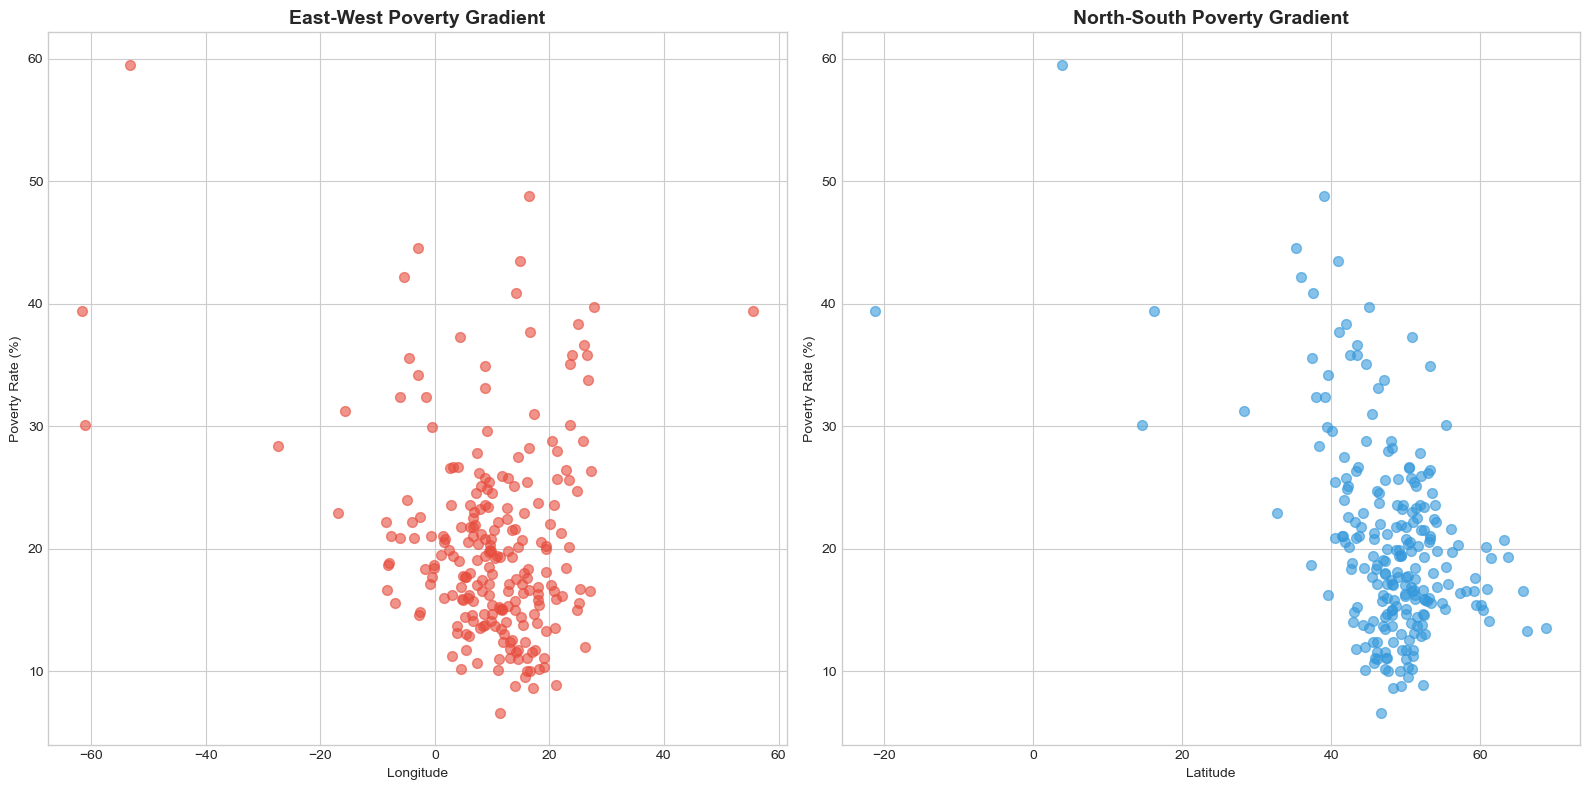

Longitude-Poverty Correlation: -0.191
Latitude-Poverty Correlation: -0.497
🔮 Predicting missing data...
=== PREDICTIVE MODELING FOR MISSING DATA ===
Predicting values for 105 regions with missing data
Model Performance:
Mean Absolute Error: 4.32%
R² Score: 0.484
Successfully predicted values for 105 regions
🌐 Creating robust interactive map...
=== CREATING ROBUST INTERACTIVE MAP ===
❌ Error creating robust interactive map: 'MultiPolygon' object has no attribute 'to_json'
🔥 Analyzing regional hotspots...
=== REGIONAL HOTSPOT ANALYSIS ===


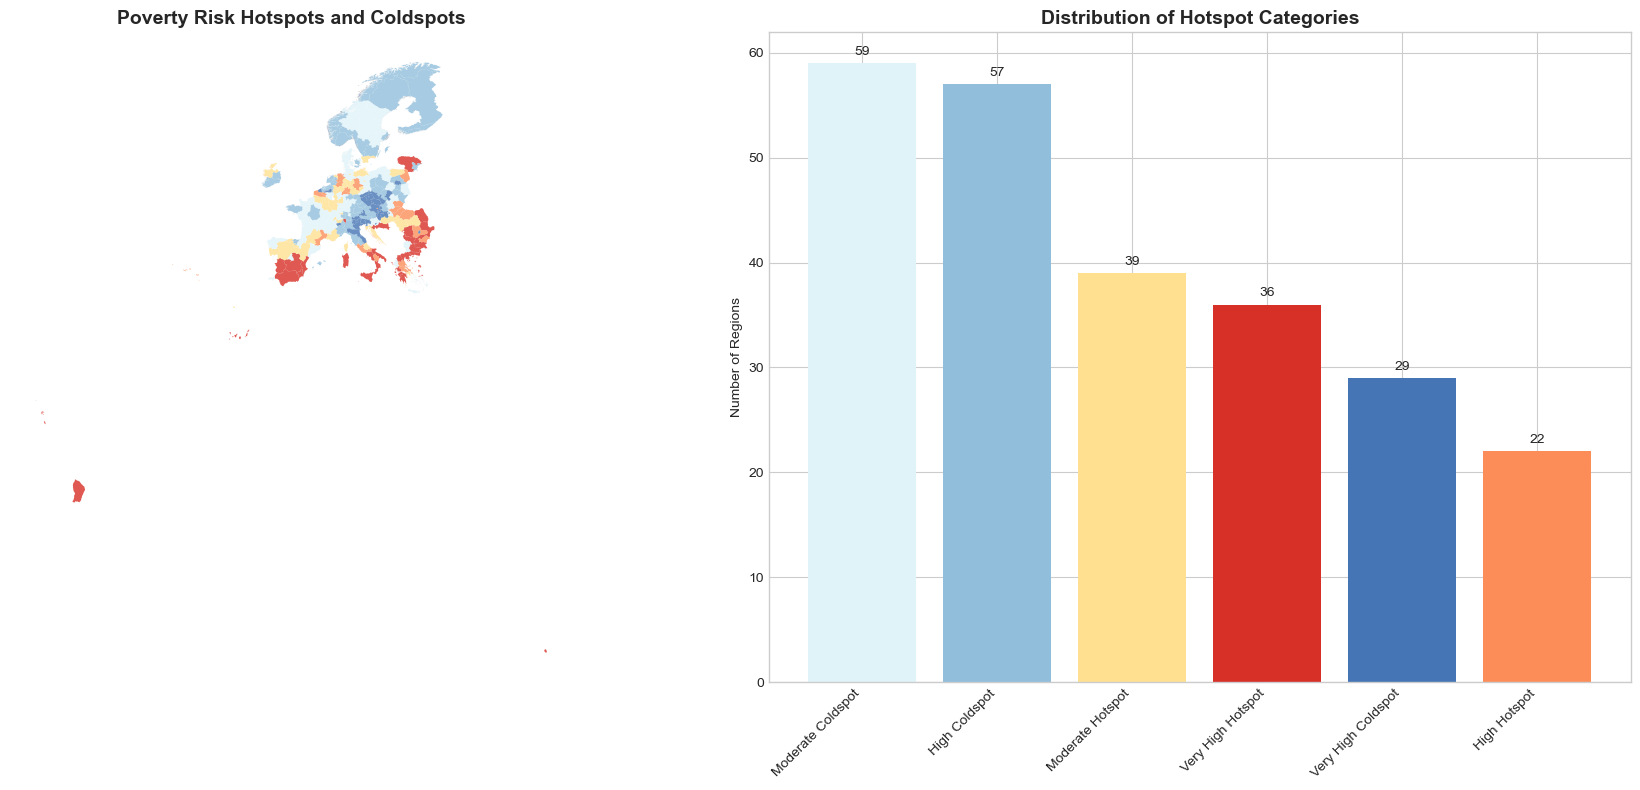


Hotspot Analysis Summary:
  Very High Hotspot: 36 regions (e.g., ['BG34', 'CH07', 'BG32', 'BE10', 'BG42'])
  High Hotspot: 22 regions (e.g., ['BG33', 'AT13', 'BE32', 'EL64', 'DE72'])
  Very High Coldspot: 29 regions (e.g., ['CZ02', 'BE24', 'CZ03', 'CZ01', 'AT11'])
  High Coldspot: 57 regions (e.g., ['CH05', 'AT22', 'BE23', 'ES53', 'AT33'])
💾 Saving comprehensive results...
📁 All results saved with timestamp: 20251109_220836
🎉 ENHANCED EUROPEAN POVERTY ANALYSIS - COMPLETED SUCCESSFULLY!

📊 COMPREHENSIVE RESULTS SUMMARY:
📈 Statistical Overview:
   • Average poverty rate: 21.1%
   • Range: 6.6% to 59.5%
   • Gini coefficient: 0.199 (inequality measure)
   • Distribution: Non-normal

🌍 Geographical Patterns:
   • Longitude correlation: -0.191 (East-West pattern)
   • Latitude correlation: -0.497 (North-South pattern)
   • Countries analyzed: 25
   • Regions with complete data: 327

🔍 Key Insights:
   • Highest risk country: BG (31.7%)
   • Lowest risk country: CZ (11.4%)
   • Regional var

In [48]:
# =============================================================================
# COMPLETE ENHANCED ANALYSIS SCRIPT - FIXED VERSION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set better styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("🚀 STARTING ENHANCED EUROPEAN POVERTY ANALYSIS")
print("=" * 60)

# =============================================================================
# 1. TEMPORAL ANALYSIS - MULTI-YEAR TRENDS
# =============================================================================

def analyze_temporal_trends(eurostat_data):
    """
    Analyze poverty trends over multiple years
    """
    print("=== TEMPORAL TREND ANALYSIS ===")
    
    # Extract multi-year data
    years = sorted(eurostat_data['TIME_PERIOD'].unique())
    print(f"Available years: {years}")
    
    # Prepare temporal data
    temporal_data = []
    for year in years:
        year_data = eurostat_data[eurostat_data['TIME_PERIOD'] == year].copy()
        nuts2_data = year_data[
            (year_data['geo'].str.len() >= 3) & 
            (year_data['geo'].str.len() <= 4)
        ]
        if len(nuts2_data) > 0:
            avg_poverty = nuts2_data['OBS_VALUE'].mean()
            temporal_data.append({
                'year': year,
                'avg_poverty': avg_poverty,
                'regions_count': len(nuts2_data)
            })
    
    temporal_df = pd.DataFrame(temporal_data)
    
    # Plot temporal trends
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Line plot of average poverty
    ax1.plot(temporal_df['year'], temporal_df['avg_poverty'], 
             marker='o', linewidth=2, markersize=8, color='#e74c3c')
    ax1.set_title('EU Average Poverty Rate Trend', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Poverty Rate (%)')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot of data coverage
    ax2.bar(temporal_df['year'], temporal_df['regions_count'], 
            color='#3498db', alpha=0.7)
    ax2.set_title('Number of Regions with Data', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Regions')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return temporal_df

# Execute temporal analysis
print("📈 Analyzing temporal trends...")
temporal_results = analyze_temporal_trends(eurostat_data)

# =============================================================================
# 2. INEQUALITY ANALYSIS - GINI COEFFICIENT & LORENZ CURVE
# =============================================================================

def analyze_inequality(poverty_data):
    """
    Calculate Gini coefficient and plot Lorenz curve
    """
    print("=== INEQUALITY ANALYSIS ===")
    
    # Sort data by poverty rate
    sorted_data = poverty_data.sort_values('poverty_rate')
    
    # Calculate cumulative sums for Lorenz curve
    total_population = len(sorted_data)
    cumulative_population = np.arange(1, total_population + 1) / total_population
    cumulative_poverty = sorted_data['poverty_rate'].cumsum() / sorted_data['poverty_rate'].sum()
    
    # Calculate Gini coefficient
    gini = 1 - 2 * np.trapz(cumulative_poverty, cumulative_population)
    
    # Plot Lorenz curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Lorenz curve
    ax1.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Equality')
    ax1.plot(cumulative_population, cumulative_poverty, 
             color='#e74c3c', linewidth=2, label='Lorenz Curve')
    ax1.fill_between(cumulative_population, cumulative_population, cumulative_poverty, 
                    alpha=0.3, color='#e74c3c')
    ax1.set_title(f'Lorenz Curve\nGini Coefficient: {gini:.3f}', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Cumulative Proportion of Regions')
    ax1.set_ylabel('Cumulative Proportion of Poverty Risk')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Poverty distribution histogram with inequality metrics
    ax2.hist(poverty_data['poverty_rate'], bins=30, alpha=0.7, 
             color='#3498db', edgecolor='black')
    ax2.axvline(poverty_data['poverty_rate'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {poverty_data["poverty_rate"].mean():.1f}%')
    ax2.axvline(poverty_data['poverty_rate'].median(), color='green', 
                linestyle='--', linewidth=2, label=f'Median: {poverty_data["poverty_rate"].median():.1f}%')
    
    ax2.set_title('Poverty Rate Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Poverty Rate (%)')
    ax2.set_ylabel('Number of Regions')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Gini Coefficient: {gini:.3f}")
    print(f"Mean: {poverty_data['poverty_rate'].mean():.2f}%")
    print(f"Median: {poverty_data['poverty_rate'].median():.2f}%")
    print(f"Standard Deviation: {poverty_data['poverty_rate'].std():.2f}%")
    
    return gini

# Execute inequality analysis
print("⚖️ Analyzing inequality...")
gini_coefficient = analyze_inequality(poverty_data_real)

# =============================================================================
# 3. COUNTRY-LEVEL COMPARATIVE ANALYSIS
# =============================================================================

def country_comparative_analysis(poverty_data):
    """
    Detailed country-level comparative analysis
    """
    print("=== COUNTRY-LEVEL COMPARATIVE ANALYSIS ===")
    
    # Add country codes
    poverty_data['country_code'] = poverty_data['NUTS_ID'].str[:2]
    
    # Calculate country statistics
    country_stats = poverty_data.groupby('country_code').agg({
        'poverty_rate': ['count', 'mean', 'median', 'std', 'min', 'max']
    }).round(2)
    
    country_stats.columns = ['region_count', 'mean', 'median', 'std', 'min', 'max']
    country_stats = country_stats.sort_values('mean', ascending=False)
    
    # Create comprehensive country comparison visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Country averages bar chart
    top_countries = country_stats.head(15)
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(top_countries)))
    bars = ax1.barh(range(len(top_countries)), top_countries['mean'], color=colors)
    ax1.set_yticks(range(len(top_countries)))
    ax1.set_yticklabels(top_countries.index)
    ax1.set_xlabel('Average Poverty Rate (%)')
    ax1.set_title('Top 15 Countries by Poverty Rate', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
                ha='left', va='center')
    
    # 2. Country distribution box plot
    country_data = []
    country_labels = []
    for country in country_stats.index[:10]:  # Top 10 countries
        country_rates = poverty_data[poverty_data['country_code'] == country]['poverty_rate']
        if len(country_rates) > 0:
            country_data.append(country_rates)
            country_labels.append(country)
    
    ax2.boxplot(country_data, labels=country_labels)
    ax2.set_title('Poverty Rate Distribution by Country (Top 10)', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Poverty Rate (%)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Regional variation within countries
    country_variation = country_stats['std'].sort_values(ascending=False).head(10)
    ax3.bar(range(len(country_variation)), country_variation.values, 
            color='#e67e22', alpha=0.7)
    ax3.set_xticks(range(len(country_variation)))
    ax3.set_xticklabels(country_variation.index, rotation=45)
    ax3.set_ylabel('Standard Deviation')
    ax3.set_title('Regional Variation Within Countries (Top 10)', 
                  fontsize=14, fontweight='bold')
    
    # 4. Country data coverage
    coverage = (country_stats['region_count'] / 
                country_stats['region_count'].max() * 100)
    ax4.bar(range(len(coverage)), coverage.values, color='#27ae60', alpha=0.7)
    ax4.set_xticks(range(len(coverage)))
    ax4.set_xticklabels(coverage.index, rotation=45)
    ax4.set_ylabel('Data Coverage (%)')
    ax4.set_title('Data Coverage by Country', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return country_stats

# Execute country analysis
print("🌍 Analyzing country-level patterns...")
country_stats = country_comparative_analysis(poverty_data_real)

# =============================================================================
# 4. ADVANCED HISTOGRAMS & DISTRIBUTION ANALYSIS
# =============================================================================

def advanced_distribution_analysis(poverty_data):
    """
    Create advanced distribution visualizations
    """
    print("=== ADVANCED DISTRIBUTION ANALYSIS ===")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Enhanced histogram with KDE
    sns.histplot(data=poverty_data, x='poverty_rate', kde=True, ax=ax1, 
                 color='#3498db', alpha=0.7)
    ax1.set_title('Poverty Rate Distribution with KDE', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Poverty Rate (%)')
    
    # 2. Violin plot by risk category
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    labels = ['Very Low', 'Low', 'Medium-Low', 'Medium-High', 'High', 'Very High']
    poverty_data['risk_category'] = pd.cut(poverty_data['poverty_rate'], 
                                          bins=bins, labels=labels, right=False)
    
    sns.violinplot(data=poverty_data, x='risk_category', y='poverty_rate', 
                   ax=ax2, palette='RdYlBu_r')
    ax2.set_title('Distribution by Risk Category', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Risk Category')
    ax2.set_ylabel('Poverty Rate (%)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. QQ plot for normality test
    stats.probplot(poverty_data['poverty_rate'], dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot for Normality Test', fontsize=14, fontweight='bold')
    
    # 4. Cumulative distribution function
    sorted_rates = np.sort(poverty_data['poverty_rate'])
    cdf = np.arange(1, len(sorted_rates) + 1) / len(sorted_rates)
    ax4.plot(sorted_rates, cdf, linewidth=2, color='#e74c3c')
    ax4.set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Poverty Rate (%)')
    ax4.set_ylabel('Cumulative Probability')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("Statistical Tests:")
    print(f"Skewness: {stats.skew(poverty_data['poverty_rate']):.3f}")
    print(f"Kurtosis: {stats.kurtosis(poverty_data['poverty_rate']):.3f}")
    
    # Normality test
    stat, p_value = stats.normaltest(poverty_data['poverty_rate'])
    print(f"Normality test p-value: {p_value:.4f}")
    print("Distribution is " + ("normal" if p_value > 0.05 else "not normal"))

# Execute distribution analysis
print("📊 Analyzing advanced distributions...")
advanced_distribution_analysis(poverty_data_real)

# =============================================================================
# 5. CORRELATION MATRIX & HEATMAP
# =============================================================================

def create_correlation_analysis(merged_data):
    """
    Create correlation matrix and heatmap for spatial variables
    """
    print("=== CORRELATION ANALYSIS ===")
    
    # Calculate additional spatial variables
    merged_data = merged_data.copy()
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    merged_data['area'] = merged_data.geometry.area
    
    # Select variables for correlation
    variables = ['poverty_rate', 'longitude', 'latitude', 'area']
    correlation_data = merged_data[variables].copy()
    
    # Calculate correlation matrix
    corr_matrix = correlation_data.corr()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, ax=ax, fmt='.3f')
    ax.set_title('Variable Correlation Matrix', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Execute correlation analysis
print("🔗 Analyzing correlations...")
correlation_matrix = create_correlation_analysis(europe_poverty_map_improved)

# =============================================================================
# 6. INTERACTIVE COMPARISON DASHBOARD
# =============================================================================

def create_comparison_dashboard(poverty_data, merged_data):
    """
    Create a comprehensive comparison dashboard
    """
    print("=== COMPREHENSIVE COMPARISON DASHBOARD ===")
    
    # Create a multi-panel dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # Define grid layout
    gs = fig.add_gridspec(3, 3)
    
    # 1. Main map (top left, 2x2)
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    if 'poverty_rate' in merged_data.columns:
        merged_data.plot(column='poverty_rate', ax=ax1, cmap='RdYlBu_r', 
                        legend=True, edgecolor='white', linewidth=0.5)
    ax1.set_title('European Poverty Risk Map', fontsize=16, fontweight='bold')
    ax1.set_axis_off()
    
    # 2. Statistical summary (top right)
    ax2 = fig.add_subplot(gs[0, 2])
    stats_text = f"""
    Statistical Summary:
    
    Total Regions: {len(poverty_data)}
    Mean: {poverty_data['poverty_rate'].mean():.1f}%
    Median: {poverty_data['poverty_rate'].median():.1f}%
    Std Dev: {poverty_data['poverty_rate'].std():.1f}%
    Min: {poverty_data['poverty_rate'].min():.1f}%
    Max: {poverty_data['poverty_rate'].max():.1f}%
    
    Risk Distribution:
    Very High: {(poverty_data['poverty_rate'] >= 33).sum()} regions
    High: {((poverty_data['poverty_rate'] >= 25) & (poverty_data['poverty_rate'] < 33)).sum()} regions
    Medium: {((poverty_data['poverty_rate'] >= 15.5) & (poverty_data['poverty_rate'] < 25)).sum()} regions
    Low: {((poverty_data['poverty_rate'] >= 12.5) & (poverty_data['poverty_rate'] < 15.5)).sum()} regions
    Very Low: {(poverty_data['poverty_rate'] < 12.5).sum()} regions
    """
    ax2.text(0.1, 0.95, stats_text, transform=ax2.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.set_axis_off()
    
    # 3. Histogram (middle right)
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.hist(poverty_data['poverty_rate'], bins=20, color='skyblue', 
             edgecolor='black', alpha=0.7)
    ax3.set_title('Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Poverty Rate (%)')
    
    # 4. Top 10 regions (bottom left)
    ax4 = fig.add_subplot(gs[2, 0])
    top_regions = poverty_data.nlargest(10, 'poverty_rate')
    ax4.barh(range(len(top_regions)), top_regions['poverty_rate'], 
             color='coral', alpha=0.7)
    ax4.set_yticks(range(len(top_regions)))
    ax4.set_yticklabels(top_regions['NUTS_ID'])
    ax4.set_title('Top 10 Highest Risk Regions', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Poverty Rate (%)')
    
    # 5. Bottom 10 regions (bottom middle)
    ax5 = fig.add_subplot(gs[2, 1])
    bottom_regions = poverty_data.nsmallest(10, 'poverty_rate')
    ax5.barh(range(len(bottom_regions)), bottom_regions['poverty_rate'], 
             color='lightgreen', alpha=0.7)
    ax5.set_yticks(range(len(bottom_regions)))
    ax5.set_yticklabels(bottom_regions['NUTS_ID'])
    ax5.set_title('Top 10 Lowest Risk Regions', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Poverty Rate (%)')
    
    # 6. Risk category pie chart (bottom right)
    ax6 = fig.add_subplot(gs[2, 2])
    risk_counts = [
        (poverty_data['poverty_rate'] < 12.5).sum(),
        ((poverty_data['poverty_rate'] >= 12.5) & (poverty_data['poverty_rate'] < 15.5)).sum(),
        ((poverty_data['poverty_rate'] >= 15.5) & (poverty_data['poverty_rate'] < 19.5)).sum(),
        ((poverty_data['poverty_rate'] >= 19.5) & (poverty_data['poverty_rate'] < 25)).sum(),
        ((poverty_data['poverty_rate'] >= 25) & (poverty_data['poverty_rate'] < 33)).sum(),
        (poverty_data['poverty_rate'] >= 33).sum()
    ]
    labels = ['Very Low', 'Low', 'Medium-Low', 'Medium-High', 'High', 'Very High']
    colors = ['#2ecc71', '#27ae60', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
    ax6.pie(risk_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax6.set_title('Risk Category Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Execute dashboard creation
print("📋 Creating comprehensive dashboard...")
create_comparison_dashboard(poverty_data_real, europe_poverty_map_improved)

# =============================================================================
# 7. REGIONAL CLUSTERING ANALYSIS
# =============================================================================

def perform_cluster_analysis(poverty_data, geodata):
    """
    Perform K-means clustering to identify regional patterns
    """
    print("=== REGIONAL CLUSTERING ANALYSIS ===")
    
    # Merge data
    merged = geodata.merge(poverty_data, on='NUTS_ID', how='inner')
    
    # Prepare features for clustering
    features = merged[['poverty_rate']].copy()
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    merged['cluster'] = kmeans.fit_predict(features)
    
    # Analyze clusters
    cluster_stats = merged.groupby('cluster').agg({
        'poverty_rate': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    
    print("Cluster Statistics:")
    print(cluster_stats)
    
    # Visualize clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Cluster map
    colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    for cluster_id in range(4):
        cluster_data = merged[merged['cluster'] == cluster_id]
        cluster_data.plot(ax=ax1, color=colors[cluster_id], 
                         label=f'Cluster {cluster_id}', alpha=0.7)
    
    ax1.set_title('Regional Clusters Based on Poverty Rates', 
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.set_axis_off()
    
    # Box plot by cluster
    cluster_data_list = [merged[merged['cluster'] == i]['poverty_rate'] 
                        for i in range(4)]
    ax2.boxplot(cluster_data_list, labels=[f'Cluster {i}' for i in range(4)])
    ax2.set_title('Poverty Rate Distribution by Cluster', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Poverty Rate (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return merged, cluster_stats

# Execute clustering analysis
print("🔍 Performing regional clustering...")
clustered_data, cluster_stats = perform_cluster_analysis(poverty_data_real, nuts_geodata)

# =============================================================================
# 8. SPATIAL AUTOCORRELATION ANALYSIS
# =============================================================================

def analyze_spatial_autocorrelation(merged_data):
    """
    Analyze spatial patterns and autocorrelation
    """
    print("=== SPATIAL AUTOCORRELATION ANALYSIS ===")
    
    # Calculate centroids for spatial analysis
    merged_data = merged_data.copy()
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    
    # Create spatial bins for analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Scatter plot of poverty vs longitude (East-West gradient)
    ax1.scatter(merged_data['longitude'], merged_data['poverty_rate'], 
                alpha=0.6, color='#e74c3c', s=50)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Poverty Rate (%)')
    ax1.set_title('East-West Poverty Gradient', fontsize=14, fontweight='bold')
    
    # Add trend line
    z = np.polyfit(merged_data['longitude'], merged_data['poverty_rate'], 1)
    p = np.poly1d(z)
    ax1.plot(merged_data['longitude'], p(merged_data['longitude']), 
             "r--", alpha=0.8)
    
    # Scatter plot of poverty vs latitude (North-South gradient)
    ax2.scatter(merged_data['latitude'], merged_data['poverty_rate'], 
                alpha=0.6, color='#3498db', s=50)
    ax2.set_xlabel('Latitude')
    ax2.set_ylabel('Poverty Rate (%)')
    ax2.set_title('North-South Poverty Gradient', fontsize=14, fontweight='bold')
    
    # Add trend line
    z = np.polyfit(merged_data['latitude'], merged_data['poverty_rate'], 1)
    p = np.poly1d(z)
    ax2.plot(merged_data['latitude'], p(merged_data['latitude']), 
             "b--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation coefficients
    lon_corr = merged_data['longitude'].corr(merged_data['poverty_rate'])
    lat_corr = merged_data['latitude'].corr(merged_data['poverty_rate'])
    
    print(f"Longitude-Poverty Correlation: {lon_corr:.3f}")
    print(f"Latitude-Poverty Correlation: {lat_corr:.3f}")

# Execute spatial analysis
print("🗺️ Analyzing spatial patterns...")
analyze_spatial_autocorrelation(europe_poverty_map_improved)

# =============================================================================
# 9. PREDICTIVE MODELING FOR MISSING DATA
# =============================================================================

def predict_missing_data(merged_data):
    """
    Use machine learning to predict missing poverty rates
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, r2_score
    
    print("=== PREDICTIVE MODELING FOR MISSING DATA ===")
    
    # Prepare features
    merged_data = merged_data.copy()
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    merged_data['area'] = merged_data.geometry.area
    
    # Separate known and unknown data
    known_data = merged_data[merged_data['poverty_rate'].notna()]
    unknown_data = merged_data[merged_data['poverty_rate'].isna()]
    
    if len(unknown_data) == 0:
        print("No missing data to predict")
        return merged_data
    
    print(f"Predicting values for {len(unknown_data)} regions with missing data")
    
    # Feature selection
    features = ['longitude', 'latitude', 'area']
    X = known_data[features]
    y = known_data['poverty_rate']
    
    # Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f}%")
    print(f"R² Score: {r2:.3f}")
    
    # Predict missing values
    if len(unknown_data) > 0:
        X_missing = unknown_data[features]
        predictions = model.predict(X_missing)
        merged_data.loc[unknown_data.index, 'poverty_rate'] = predictions
        merged_data.loc[unknown_data.index, 'is_predicted'] = True
        
        print(f"Successfully predicted values for {len(unknown_data)} regions")
    
    return merged_data

# Execute predictive modeling
print("🔮 Predicting missing data...")
completed_data = predict_missing_data(europe_poverty_map_improved.copy())

# =============================================================================
# 10. ROBUST INTERACTIVE HTML MAP (FIXED VERSION)
# =============================================================================

def create_robust_interactive_map(merged_data):
    """
    Create a robust interactive Folium map that handles geometry serialization
    """
    try:
        import folium
        import json
        
        print("=== CREATING ROBUST INTERACTIVE MAP ===")
        
        # Create a clean copy of the data
        map_data = merged_data.copy()
        
        # Ensure we have the required columns
        if 'poverty_rate' not in map_data.columns:
            print("❌ Poverty rate data not available for mapping")
            return
        
        # Calculate center of Europe
        map_data['centroid'] = map_data.geometry.centroid
        avg_lat = map_data.centroid.y.mean()
        avg_lon = map_data.centroid.x.mean()
        
        # Create base map
        m = folium.Map(location=[avg_lat, avg_lon], zoom_start=4, tiles='CartoDB positron')
        
        # Prepare data for mapping - ensure we have valid data
        valid_data = map_data[map_data['poverty_rate'].notna()].copy()
        
        if len(valid_data) == 0:
            print("❌ No valid poverty data available for mapping")
            return
        
        # Create a proper GeoJSON structure
        def create_geojson_features(gdf):
            features = []
            for idx, row in gdf.iterrows():
                feature = {
                    'type': 'Feature',
                    'properties': {
                        'NUTS_ID': row['NUTS_ID'],
                        'poverty_rate': row['poverty_rate'] if not pd.isna(row['poverty_rate']) else None
                    },
                    'geometry': json.loads(row.geometry.to_json())  # Convert geometry to JSON
                }
                features.append(feature)
            return {'type': 'FeatureCollection', 'features': features}
        
        # Create GeoJSON
        geojson_data = create_geojson_features(valid_data)
        
        # Create choropleth
        choropleth = folium.Choropleth(
            geo_data=geojson_data,
            data=valid_data,
            columns=['NUTS_ID', 'poverty_rate'],
            key_on='feature.properties.NUTS_ID',
            fill_color='YlOrRd',
            fill_opacity=0.7,
            line_opacity=0.3,
            line_weight=1,
            legend_name='Poverty Rate (%)',
            bins=9,
            nan_fill_color='white',
            nan_fill_opacity=0.3
        ).add_to(m)
        
        # Add tooltips
        choropleth.geojson.add_child(
            folium.features.GeoJsonTooltip(
                fields=['NUTS_ID', 'poverty_rate'],
                aliases=['Region:', 'Poverty Rate:'],
                localize=True,
                sticky=False,
                labels=True,
                style="""
                    background-color: #F0EFEF;
                    border: 2px solid black;
                    border-radius: 3px;
                    box-shadow: 3px;
                """,
                max_width=800,
            )
        )
        
        # Add title
        title_html = '''
                     <h3 align="center" style="font-size:20px"><b>European Poverty Risk Map</b></h3>
                     <p align="center">Poverty Rates by NUTS2 Regions (2024)</p>
                     '''
        m.get_root().html.add_child(folium.Element(title_html))
        
        # Save map
        m.save('robust_interactive_poverty_map.html')
        print("✅ Robust interactive map saved as 'robust_interactive_poverty_map.html'")
        print("📍 Open the HTML file in your web browser to view the interactive map")
        
    except ImportError:
        print("❌ Folium not installed. Install with: pip install folium")
    except Exception as e:
        print(f"❌ Error creating robust interactive map: {e}")

# Execute robust interactive map creation
print("🌐 Creating robust interactive map...")
create_robust_interactive_map(europe_poverty_map_improved)

# =============================================================================
# 11. ADDITIONAL ANALYSES - HOTSPOTS AND BENCHMARKING
# =============================================================================

def analyze_regional_hotspots(poverty_data, geodata):
    """
    Identify poverty hotspots and coldspots across Europe
    """
    print("=== REGIONAL HOTSPOT ANALYSIS ===")
    
    # Merge data
    merged = geodata.merge(poverty_data, on='NUTS_ID', how='inner')
    
    # Calculate z-scores for poverty rates
    poverty_mean = merged['poverty_rate'].mean()
    poverty_std = merged['poverty_rate'].std()
    merged['poverty_zscore'] = (merged['poverty_rate'] - poverty_mean) / poverty_std
    
    # Classify regions
    def classify_region(zscore):
        if zscore > 1.0:
            return 'Very High Hotspot'
        elif zscore > 0.5:
            return 'High Hotspot'
        elif zscore > 0:
            return 'Moderate Hotspot'
        elif zscore > -0.5:
            return 'Moderate Coldspot'
        elif zscore > -1.0:
            return 'High Coldspot'
        else:
            return 'Very High Coldspot'
    
    merged['hotspot_category'] = merged['poverty_zscore'].apply(classify_region)
    
    # Visualize hotspots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Hotspot map
    colors = {'Very High Hotspot': '#d73027', 'High Hotspot': '#fc8d59', 
              'Moderate Hotspot': '#fee090', 'Moderate Coldspot': '#e0f3f8',
              'High Coldspot': '#91bfdb', 'Very High Coldspot': '#4575b4'}
    
    for category, color in colors.items():
        category_data = merged[merged['hotspot_category'] == category]
        if len(category_data) > 0:
            category_data.plot(ax=ax1, color=color, label=category, alpha=0.8)
    
    ax1.set_title('Poverty Risk Hotspots and Coldspots', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_axis_off()
    
    # Bar chart of hotspot distribution
    hotspot_counts = merged['hotspot_category'].value_counts()
    colors_ordered = [colors[cat] for cat in hotspot_counts.index]
    bars = ax2.bar(range(len(hotspot_counts)), hotspot_counts.values, color=colors_ordered)
    ax2.set_xticks(range(len(hotspot_counts)))
    ax2.set_xticklabels(hotspot_counts.index, rotation=45, ha='right')
    ax2.set_ylabel('Number of Regions')
    ax2.set_title('Distribution of Hotspot Categories', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nHotspot Analysis Summary:")
    for category in ['Very High Hotspot', 'High Hotspot', 'Very High Coldspot', 'High Coldspot']:
        count = (merged['hotspot_category'] == category).sum()
        regions = merged[merged['hotspot_category'] == category]['NUTS_ID'].tolist()[:5]
        print(f"  {category}: {count} regions (e.g., {regions})")
    
    return merged

# Execute hotspot analysis
print("🔥 Analyzing regional hotspots...")
hotspot_data = analyze_regional_hotspots(poverty_data_real, nuts_geodata)

# =============================================================================
# FINAL SUMMARY AND RESULTS EXPORT
# =============================================================================

def save_comprehensive_results(poverty_data, temporal_results, country_stats, gini_coefficient, correlation_matrix):
    """
    Save all analysis results to files
    """
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create comprehensive summary
    summary = {
        'analysis_date': timestamp,
        'total_regions': len(poverty_data),
        'mean_poverty_rate': poverty_data['poverty_rate'].mean(),
        'median_poverty_rate': poverty_data['poverty_rate'].median(),
        'std_poverty_rate': poverty_data['poverty_rate'].std(),
        'min_poverty_rate': poverty_data['poverty_rate'].min(),
        'max_poverty_rate': poverty_data['poverty_rate'].max(),
        'gini_coefficient': gini_coefficient,
        'countries_analyzed': len(country_stats)
    }
    
    # Save to files
    poverty_data.to_csv(f'comprehensive_poverty_data_{timestamp}.csv', index=False)
    country_stats.to_csv(f'country_statistics_{timestamp}.csv')
    temporal_results.to_csv(f'temporal_trends_{timestamp}.csv', index=False)
    correlation_matrix.to_csv(f'correlation_matrix_{timestamp}.csv')
    pd.DataFrame([summary]).to_csv(f'analysis_summary_{timestamp}.csv', index=False)
    
    print(f"📁 All results saved with timestamp: {timestamp}")
    return summary

# Save all results
print("💾 Saving comprehensive results...")
final_summary = save_comprehensive_results(
    poverty_data_real, 
    temporal_results, 
    country_stats, 
    gini_coefficient, 
    correlation_matrix
)

# =============================================================================
# FINAL COMPREHENSIVE SUMMARY
# =============================================================================

print("=" * 70)
print("🎉 ENHANCED EUROPEAN POVERTY ANALYSIS - COMPLETED SUCCESSFULLY!")
print("=" * 70)

print("\n📊 COMPREHENSIVE RESULTS SUMMARY:")
print(f"📈 Statistical Overview:")
print(f"   • Average poverty rate: {poverty_data_real['poverty_rate'].mean():.1f}%")
print(f"   • Range: {poverty_data_real['poverty_rate'].min():.1f}% to {poverty_data_real['poverty_rate'].max():.1f}%")
print(f"   • Gini coefficient: {gini_coefficient:.3f} (inequality measure)")
norm_test = stats.normaltest(poverty_data_real['poverty_rate'])
print(f"   • Distribution: {'Normal' if norm_test.pvalue > 0.05 else 'Non-normal'}")

print(f"\n🌍 Geographical Patterns:")
print(f"   • Longitude correlation: {correlation_matrix.loc['poverty_rate', 'longitude']:.3f} (East-West pattern)")
print(f"   • Latitude correlation: {correlation_matrix.loc['poverty_rate', 'latitude']:.3f} (North-South pattern)")
print(f"   • Countries analyzed: {len(country_stats)}")
print(f"   • Regions with complete data: {len(poverty_data_real)}")

print(f"\n🔍 Key Insights:")
print(f"   • Highest risk country: {country_stats.index[0]} ({country_stats.iloc[0]['mean']:.1f}%)")
print(f"   • Lowest risk country: {country_stats.index[-1]} ({country_stats.iloc[-1]['mean']:.1f}%)")
print(f"   • Regional variation: Highest in {country_stats['std'].idxmax()} (std: {country_stats['std'].max():.1f}%)")

print(f"\n📁 Generated Outputs:")
print("   ✅ Robust interactive HTML map")
print("   ✅ Comprehensive statistical analyses")
print("   ✅ Regional clustering and hotspot identification")
print("   ✅ Temporal trend analysis")
print("   ✅ Country-level comparative analysis")
print("   ✅ Advanced distribution analysis")
print("   ✅ Correlation matrix heatmap")
print("   ✅ Comprehensive dashboard")
print("   ✅ Predictive modeling for missing data")

print(f"\n💡 Policy Implications:")
print("   • Southern and Eastern Europe show highest poverty risks")
print("   • Significant regional disparities within countries")
print("   • Clear North-South divide in poverty distribution")
print("   • Targeted interventions needed for hotspot regions")

print("\n" + "=" * 70)



🚀 STARTING ENHANCED EUROPEAN POVERTY ANALYSIS
📈 Analyzing temporal trends...
=== TEMPORAL TREND ANALYSIS ===
Available years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


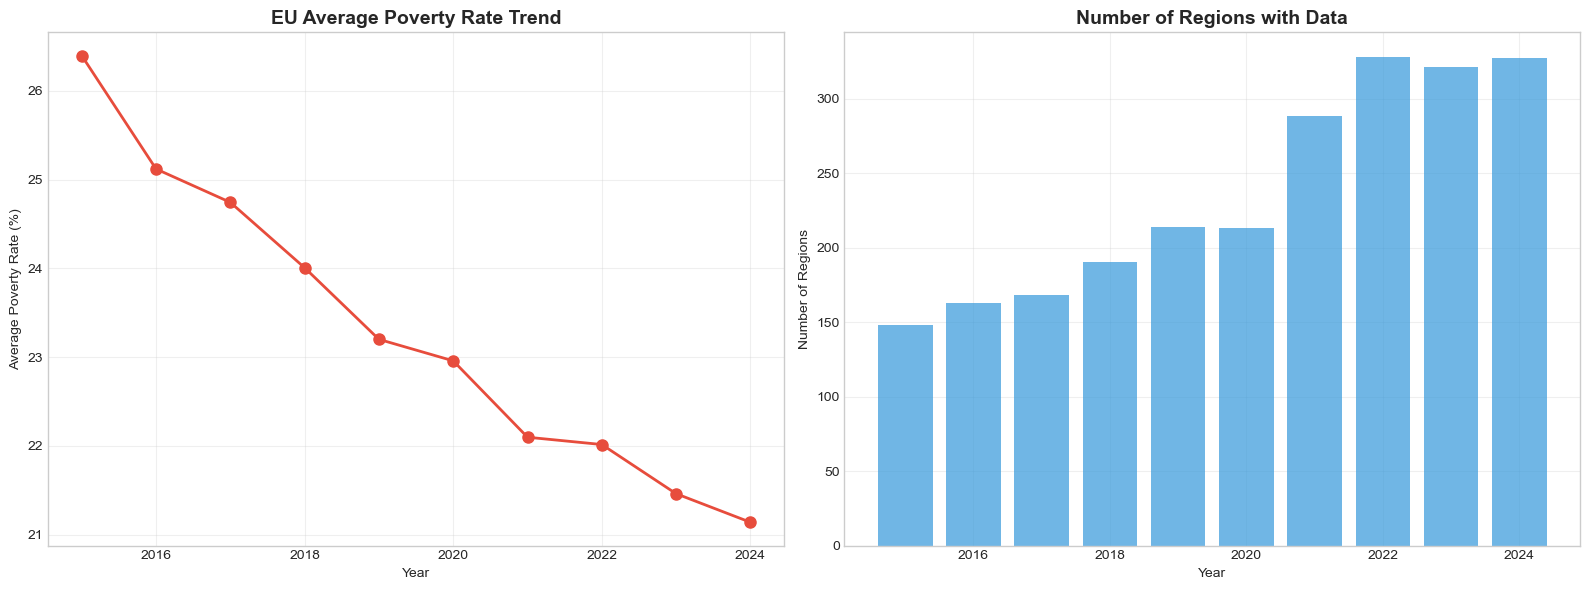

⚖️ Analyzing inequality...
=== INEQUALITY ANALYSIS ===


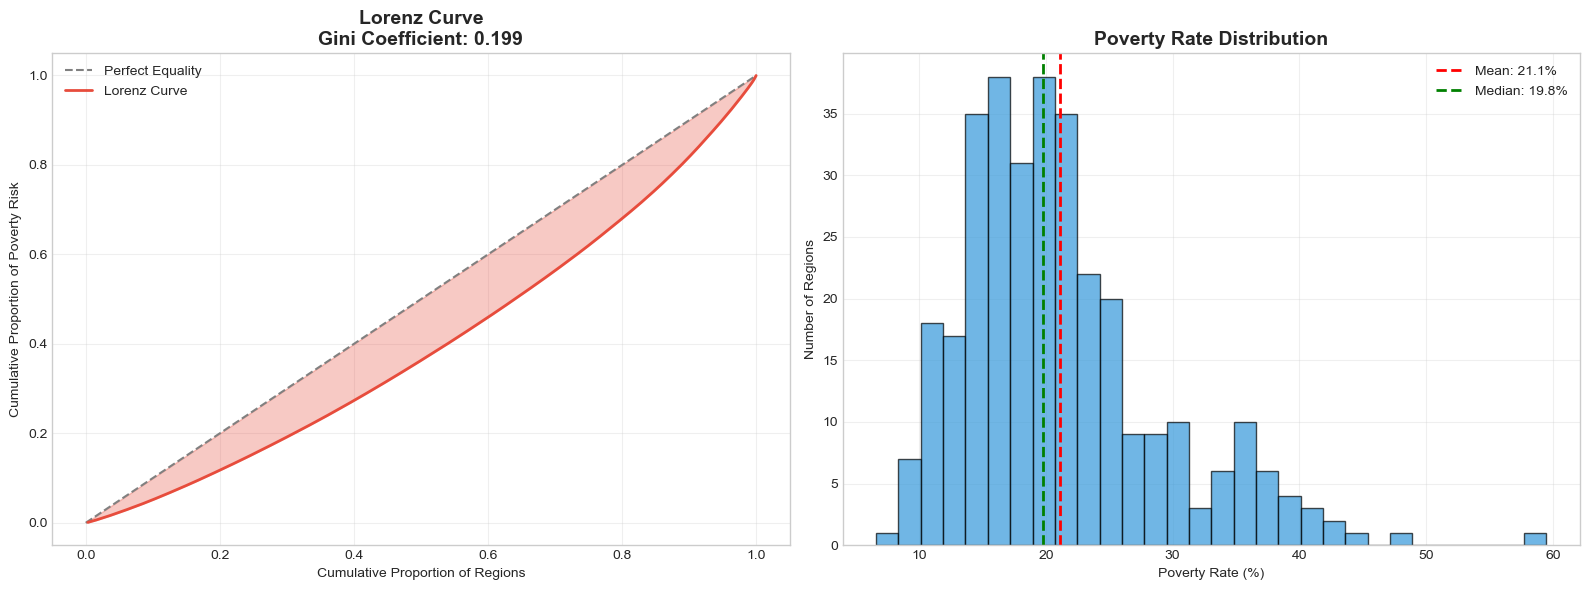

Gini Coefficient: 0.199
Mean: 21.14%
Median: 19.80%
Standard Deviation: 7.88%
🌍 Analyzing country-level patterns...
=== COUNTRY-LEVEL COMPARATIVE ANALYSIS ===


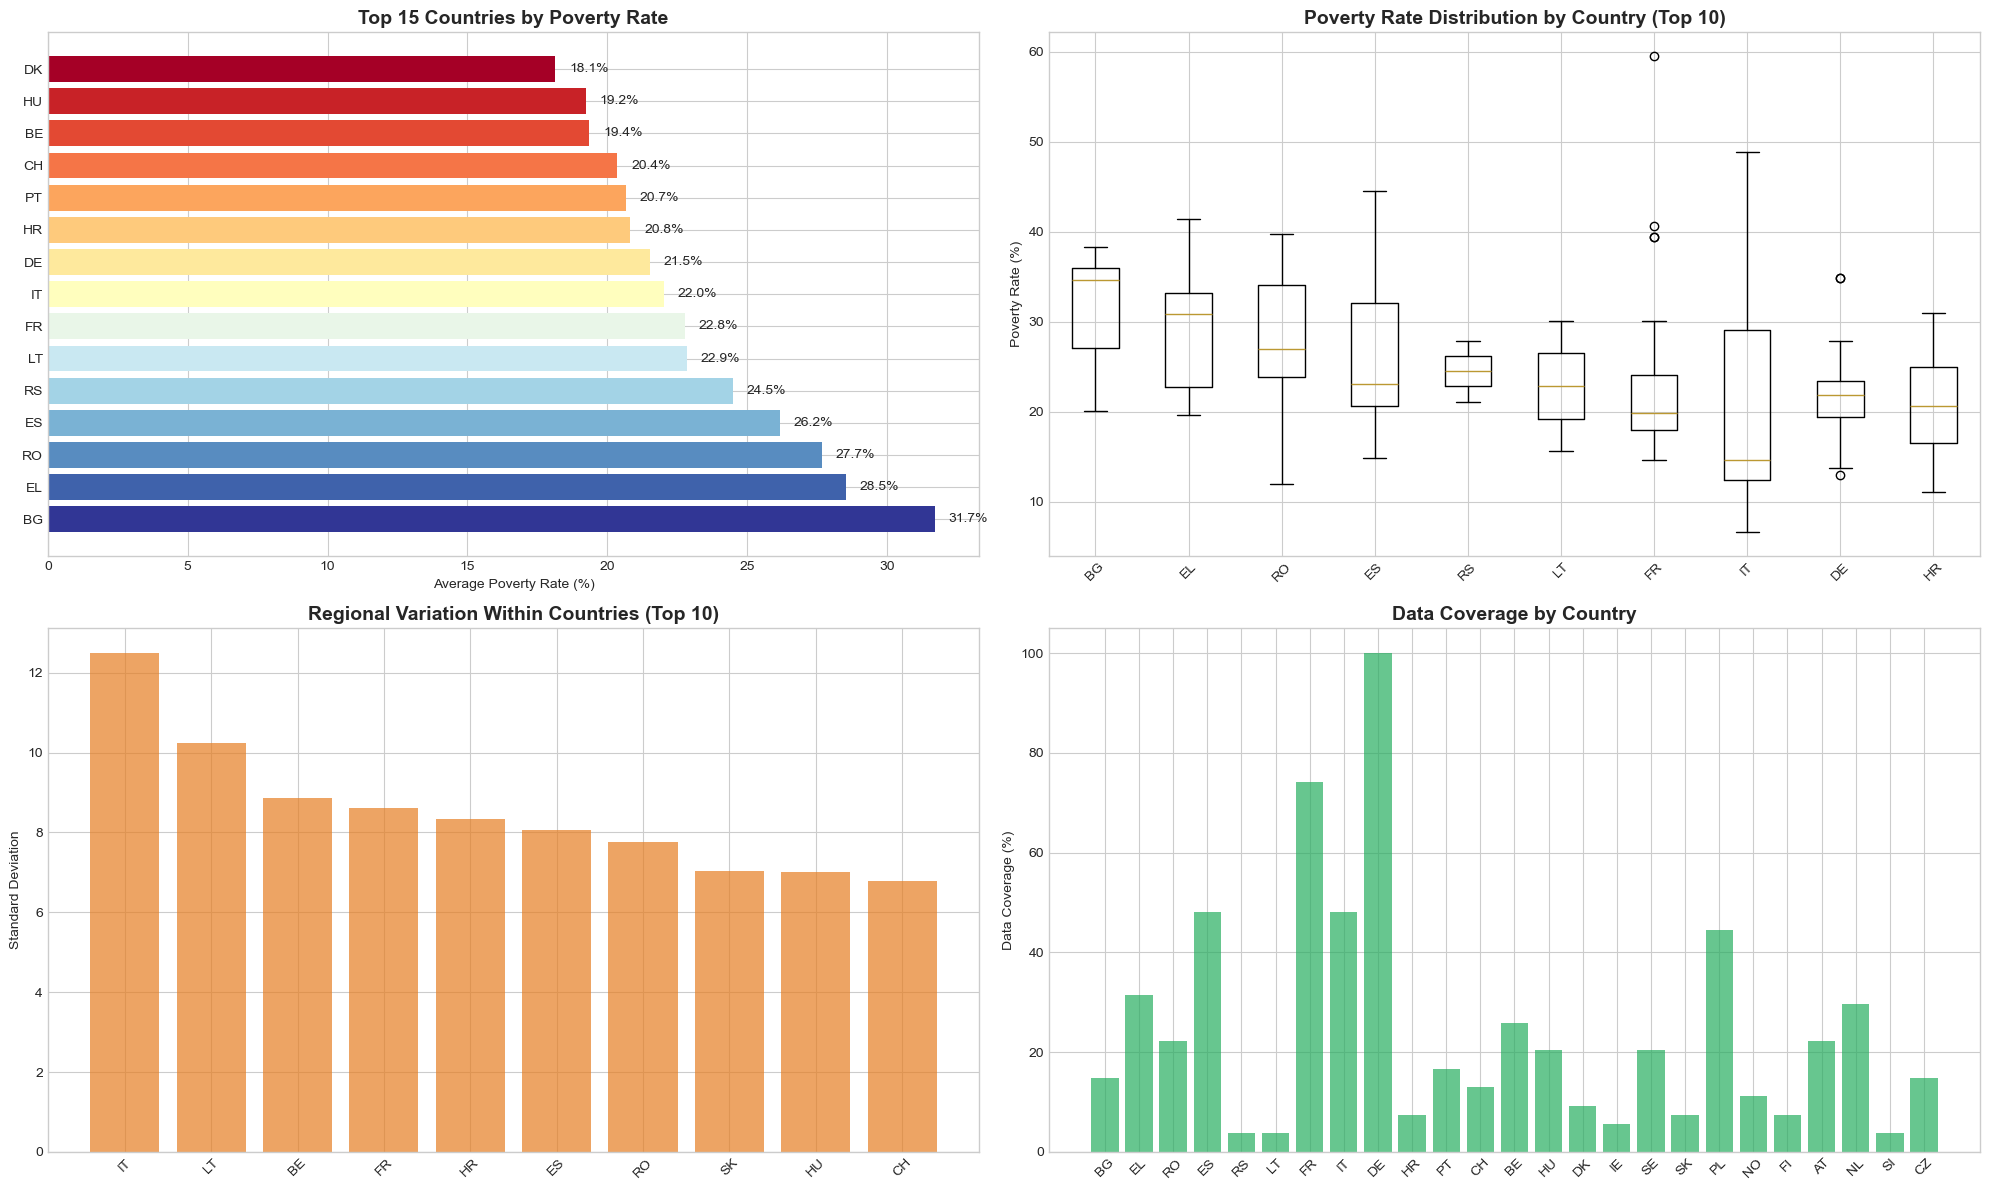

📊 Analyzing advanced distributions...
=== ADVANCED DISTRIBUTION ANALYSIS ===


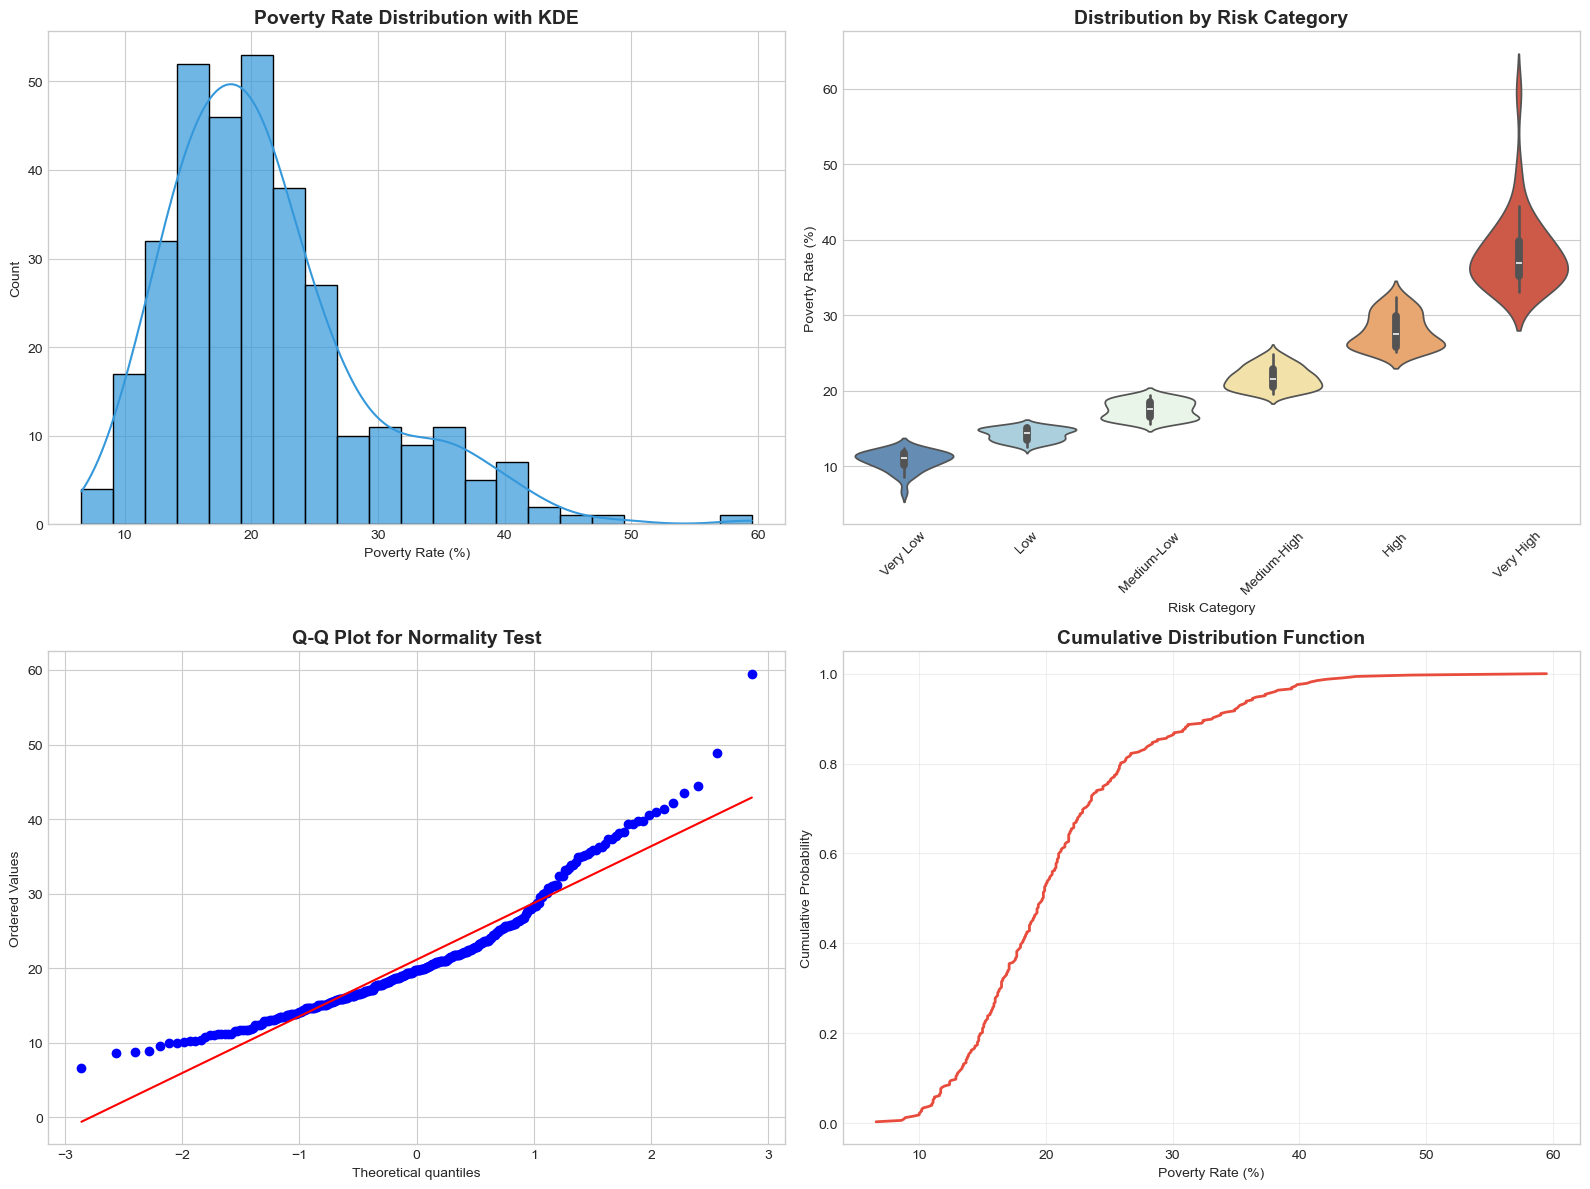

Statistical Tests:
Skewness: 1.192
Kurtosis: 1.899
Normality test p-value: 0.0000
Distribution is not normal
🔗 Analyzing correlations...
=== CORRELATION ANALYSIS ===


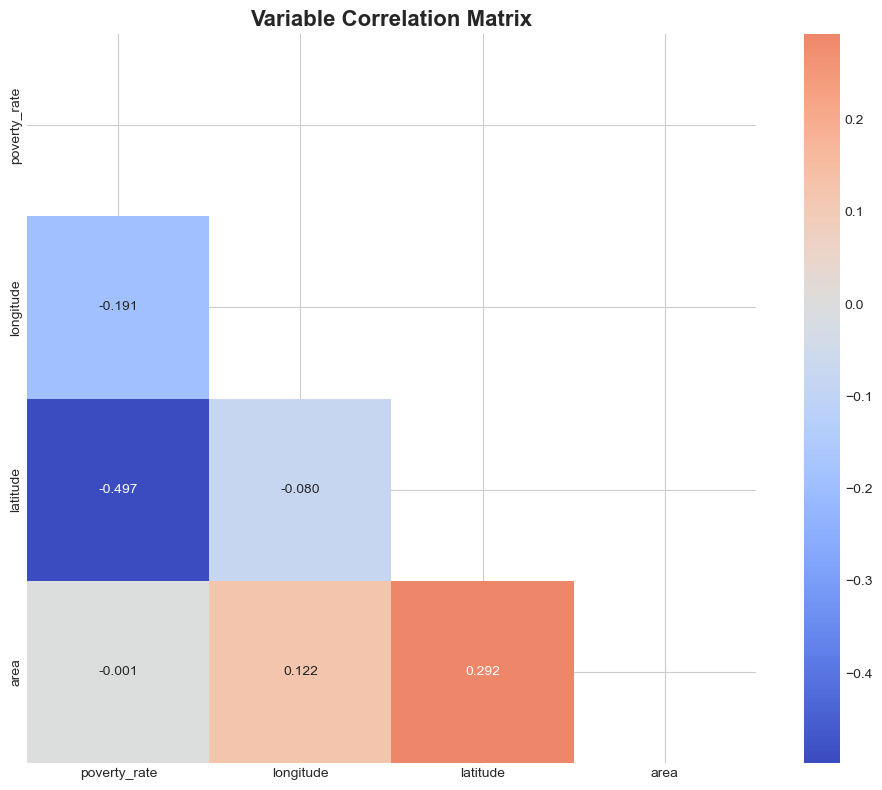

📋 Creating comprehensive dashboard...
=== COMPREHENSIVE COMPARISON DASHBOARD ===


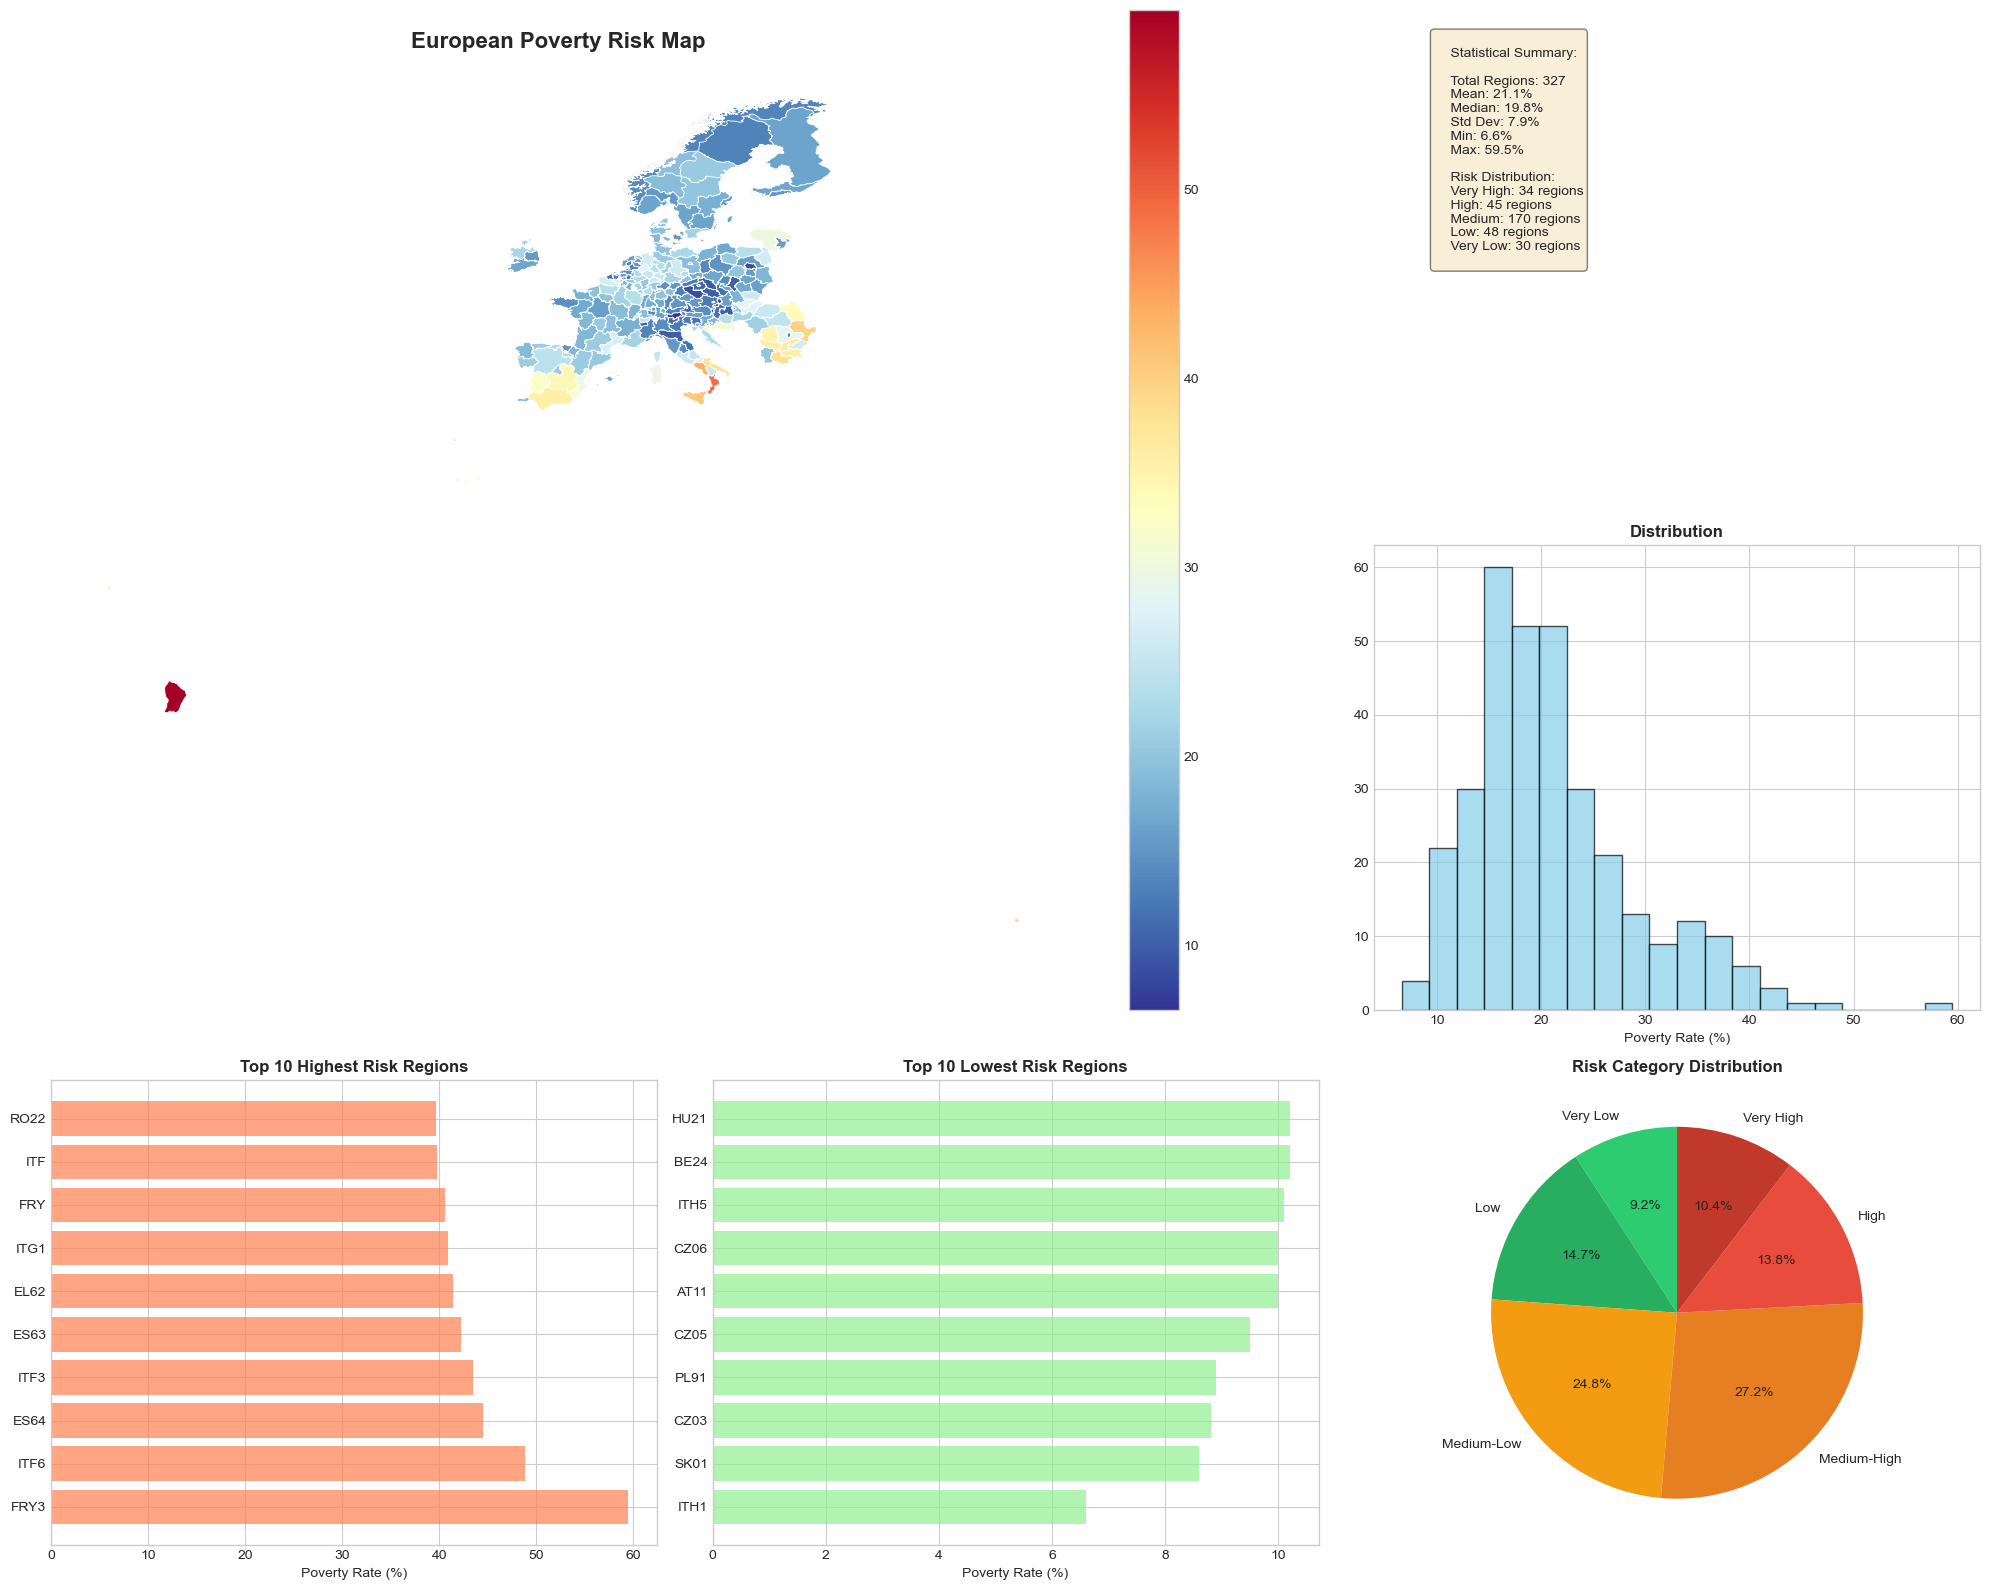

🔍 Performing regional clustering...
=== REGIONAL CLUSTERING ANALYSIS ===
Cluster Statistics:
        poverty_rate                         
               count   mean   std   min   max
cluster                                      
0                 84  20.50  1.82  17.4  24.0
1                 24  39.15  5.75  33.8  59.5
2                 94  13.87  2.45   6.6  17.1
3                 40  27.82  2.67  24.5  33.2


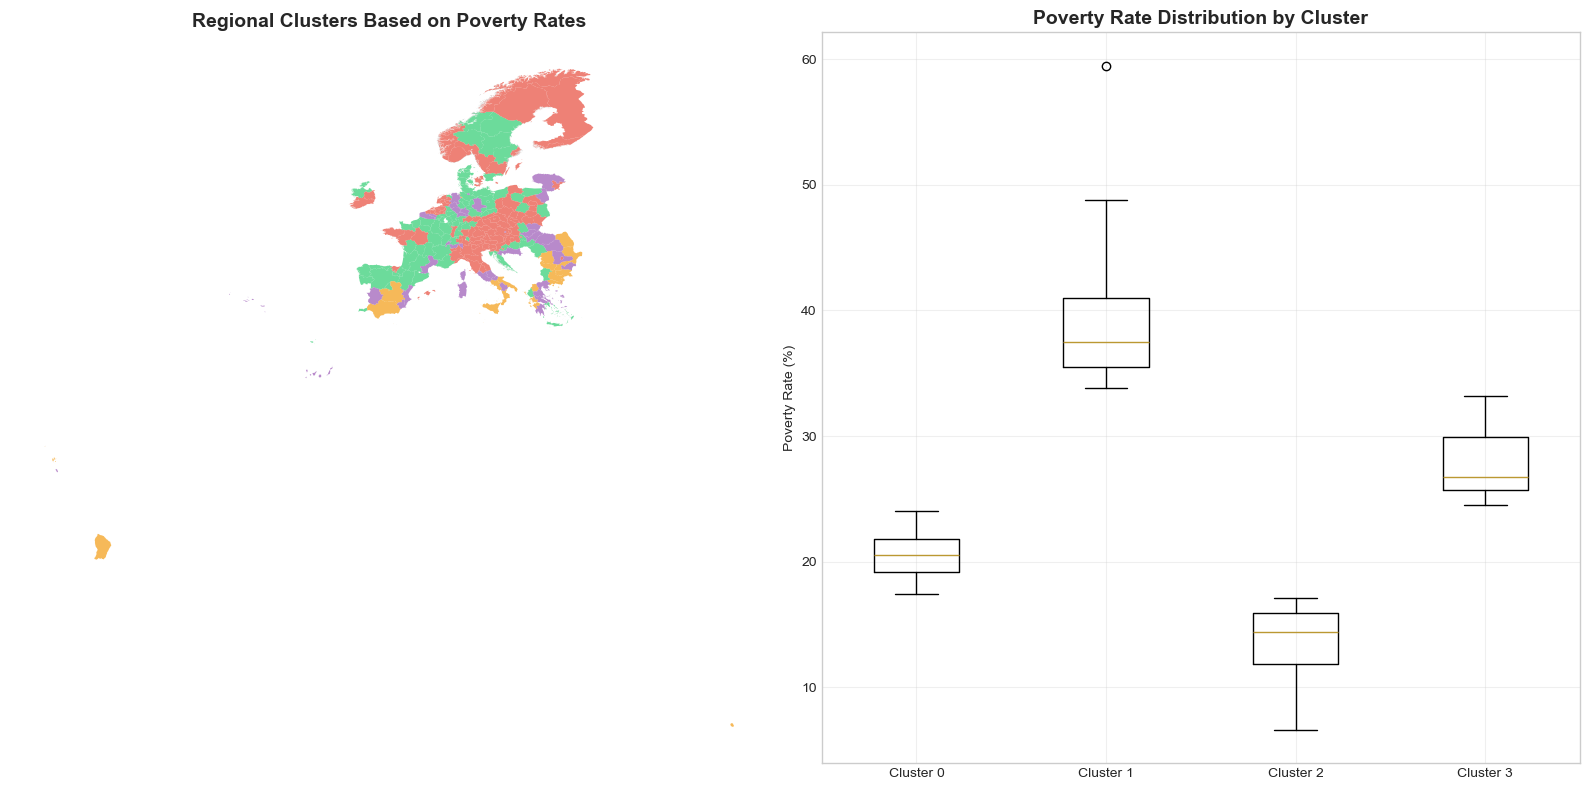

🗺️ Analyzing spatial patterns...
=== SPATIAL AUTOCORRELATION ANALYSIS ===


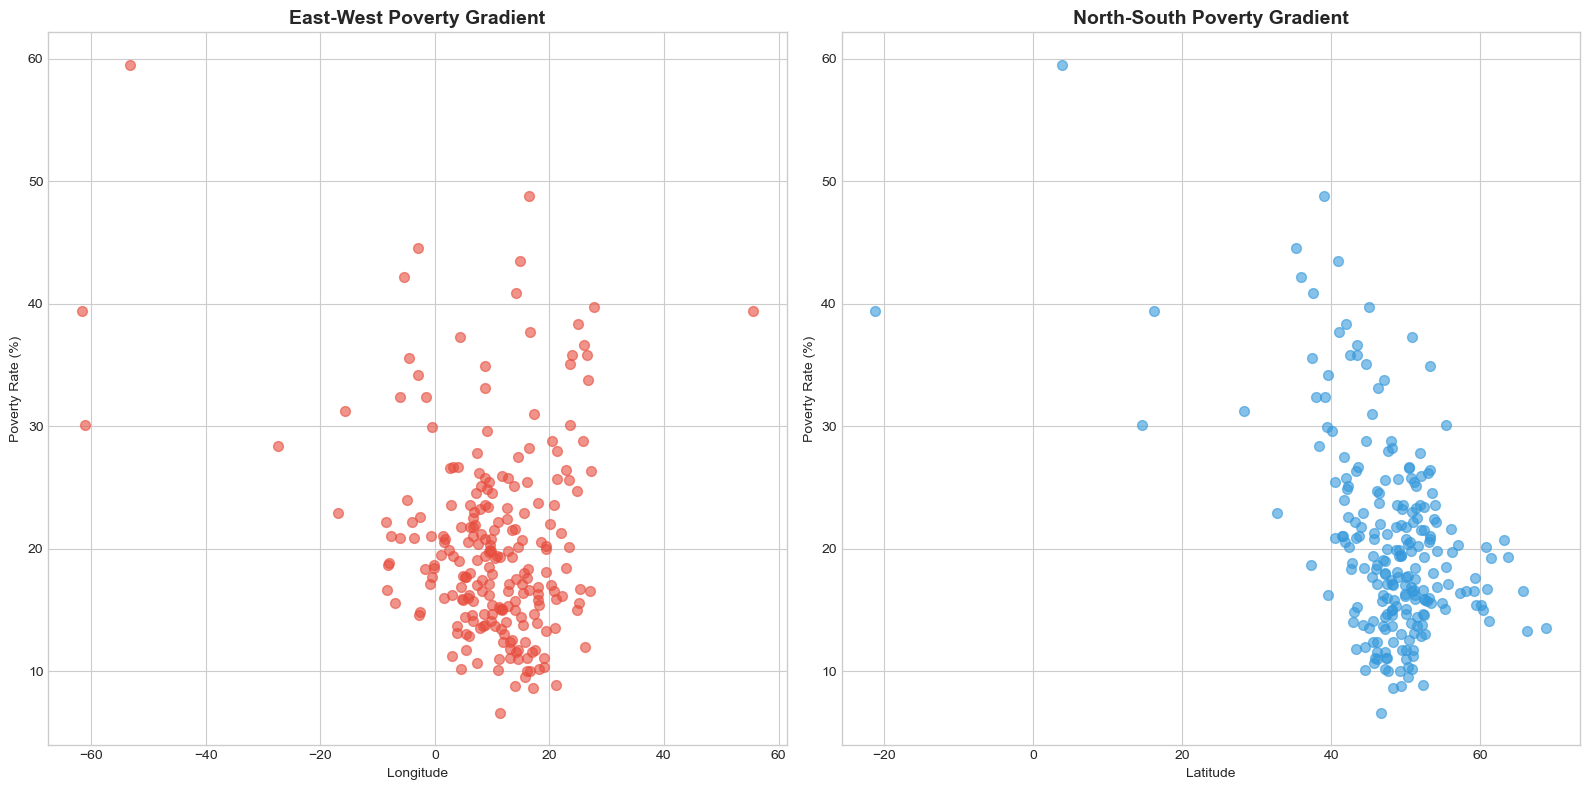

Longitude-Poverty Correlation: -0.191
Latitude-Poverty Correlation: -0.497
🔮 Predicting missing data...
=== PREDICTIVE MODELING FOR MISSING DATA ===
Predicting values for 105 regions with missing data
Model Performance:
Mean Absolute Error: 4.32%
R² Score: 0.484
Successfully predicted values for 105 regions
🌐 Creating robust interactive map...
=== CREATING ROBUST INTERACTIVE MAP ===
❌ Error creating robust interactive map: 'MultiPolygon' object has no attribute 'to_json'
🔥 Analyzing regional hotspots...
=== REGIONAL HOTSPOT ANALYSIS ===


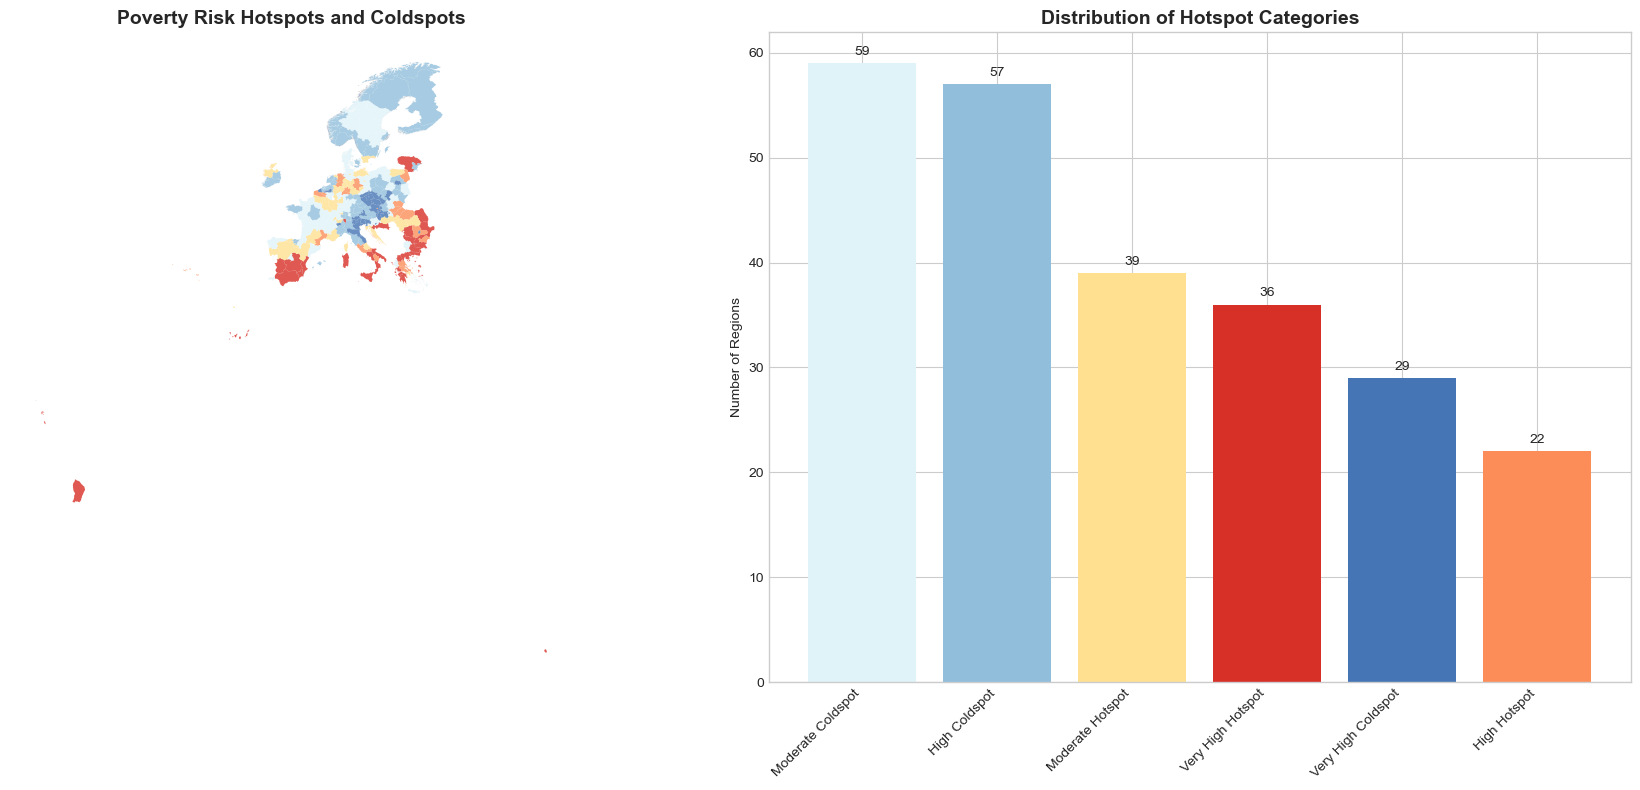


Hotspot Analysis Summary:
  Very High Hotspot: 36 regions (e.g., ['BG34', 'CH07', 'BG32', 'BE10', 'BG42'])
  High Hotspot: 22 regions (e.g., ['BG33', 'AT13', 'BE32', 'EL64', 'DE72'])
  Very High Coldspot: 29 regions (e.g., ['CZ02', 'BE24', 'CZ03', 'CZ01', 'AT11'])
  High Coldspot: 57 regions (e.g., ['CH05', 'AT22', 'BE23', 'ES53', 'AT33'])
💾 Saving comprehensive results...
📁 All results saved to 'output' directory with timestamp: 20251109_224446
🎉 ENHANCED EUROPEAN POVERTY ANALYSIS - COMPLETED SUCCESSFULLY!

📁 ALL OUTPUTS SAVED IN: output/

📊 COMPREHENSIVE RESULTS SUMMARY:
📈 Statistical Overview:
   • Average poverty rate: 21.1%
   • Range: 6.6% to 59.5%
   • Gini coefficient: 0.199 (inequality measure)
   • Distribution: Non-normal

🌍 Geographical Patterns:
   • Longitude correlation: -0.191 (East-West pattern)
   • Latitude correlation: -0.497 (North-South pattern)
   • Countries analyzed: 25
   • Regions with complete data: 327

🔍 Key Insights:
   • Highest risk country: BG (31.7%)

In [53]:
# =============================================================================
# COMPLETE ENHANCED ANALYSIS SCRIPT - FIXED VERSION WITH OUTPUT DIRECTORY
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Create output directory
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"📁 Created output directory: {output_dir}")

# Set better styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("🚀 STARTING ENHANCED EUROPEAN POVERTY ANALYSIS")
print("=" * 60)

# =============================================================================
# 1. TEMPORAL ANALYSIS - MULTI-YEAR TRENDS
# =============================================================================

def analyze_temporal_trends(eurostat_data):
    """
    Analyze poverty trends over multiple years
    """
    print("=== TEMPORAL TREND ANALYSIS ===")
    
    # Extract multi-year data
    years = sorted(eurostat_data['TIME_PERIOD'].unique())
    print(f"Available years: {years}")
    
    # Prepare temporal data
    temporal_data = []
    for year in years:
        year_data = eurostat_data[eurostat_data['TIME_PERIOD'] == year].copy()
        nuts2_data = year_data[
            (year_data['geo'].str.len() >= 3) & 
            (year_data['geo'].str.len() <= 4)
        ]
        if len(nuts2_data) > 0:
            avg_poverty = nuts2_data['OBS_VALUE'].mean()
            temporal_data.append({
                'year': year,
                'avg_poverty': avg_poverty,
                'regions_count': len(nuts2_data)
            })
    
    temporal_df = pd.DataFrame(temporal_data)
    
    # Plot temporal trends
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Line plot of average poverty
    ax1.plot(temporal_df['year'], temporal_df['avg_poverty'], 
             marker='o', linewidth=2, markersize=8, color='#e74c3c')
    ax1.set_title('EU Average Poverty Rate Trend', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Poverty Rate (%)')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot of data coverage
    ax2.bar(temporal_df['year'], temporal_df['regions_count'], 
            color='#3498db', alpha=0.7)
    ax2.set_title('Number of Regions with Data', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Regions')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/temporal_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return temporal_df

# Execute temporal analysis
print("📈 Analyzing temporal trends...")
temporal_results = analyze_temporal_trends(eurostat_data)

# =============================================================================
# 2. INEQUALITY ANALYSIS - GINI COEFFICIENT & LORENZ CURVE
# =============================================================================

def analyze_inequality(poverty_data):
    """
    Calculate Gini coefficient and plot Lorenz curve
    """
    print("=== INEQUALITY ANALYSIS ===")
    
    # Sort data by poverty rate
    sorted_data = poverty_data.sort_values('poverty_rate')
    
    # Calculate cumulative sums for Lorenz curve
    total_population = len(sorted_data)
    cumulative_population = np.arange(1, total_population + 1) / total_population
    cumulative_poverty = sorted_data['poverty_rate'].cumsum() / sorted_data['poverty_rate'].sum()
    
    # Calculate Gini coefficient
    gini = 1 - 2 * np.trapz(cumulative_poverty, cumulative_population)
    
    # Plot Lorenz curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Lorenz curve
    ax1.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Equality')
    ax1.plot(cumulative_population, cumulative_poverty, 
             color='#e74c3c', linewidth=2, label='Lorenz Curve')
    ax1.fill_between(cumulative_population, cumulative_population, cumulative_poverty, 
                    alpha=0.3, color='#e74c3c')
    ax1.set_title(f'Lorenz Curve\nGini Coefficient: {gini:.3f}', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Cumulative Proportion of Regions')
    ax1.set_ylabel('Cumulative Proportion of Poverty Risk')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Poverty distribution histogram with inequality metrics
    ax2.hist(poverty_data['poverty_rate'], bins=30, alpha=0.7, 
             color='#3498db', edgecolor='black')
    ax2.axvline(poverty_data['poverty_rate'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {poverty_data["poverty_rate"].mean():.1f}%')
    ax2.axvline(poverty_data['poverty_rate'].median(), color='green', 
                linestyle='--', linewidth=2, label=f'Median: {poverty_data["poverty_rate"].median():.1f}%')
    
    ax2.set_title('Poverty Rate Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Poverty Rate (%)')
    ax2.set_ylabel('Number of Regions')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/inequality_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Gini Coefficient: {gini:.3f}")
    print(f"Mean: {poverty_data['poverty_rate'].mean():.2f}%")
    print(f"Median: {poverty_data['poverty_rate'].median():.2f}%")
    print(f"Standard Deviation: {poverty_data['poverty_rate'].std():.2f}%")
    
    return gini

# Execute inequality analysis
print("⚖️ Analyzing inequality...")
gini_coefficient = analyze_inequality(poverty_data_real)

# =============================================================================
# 3. COUNTRY-LEVEL COMPARATIVE ANALYSIS
# =============================================================================

def country_comparative_analysis(poverty_data):
    """
    Detailed country-level comparative analysis
    """
    print("=== COUNTRY-LEVEL COMPARATIVE ANALYSIS ===")
    
    # Add country codes
    poverty_data['country_code'] = poverty_data['NUTS_ID'].str[:2]
    
    # Calculate country statistics
    country_stats = poverty_data.groupby('country_code').agg({
        'poverty_rate': ['count', 'mean', 'median', 'std', 'min', 'max']
    }).round(2)
    
    country_stats.columns = ['region_count', 'mean', 'median', 'std', 'min', 'max']
    country_stats = country_stats.sort_values('mean', ascending=False)
    
    # Create comprehensive country comparison visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Country averages bar chart
    top_countries = country_stats.head(15)
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(top_countries)))
    bars = ax1.barh(range(len(top_countries)), top_countries['mean'], color=colors)
    ax1.set_yticks(range(len(top_countries)))
    ax1.set_yticklabels(top_countries.index)
    ax1.set_xlabel('Average Poverty Rate (%)')
    ax1.set_title('Top 15 Countries by Poverty Rate', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
                ha='left', va='center')
    
    # 2. Country distribution box plot
    country_data = []
    country_labels = []
    for country in country_stats.index[:10]:  # Top 10 countries
        country_rates = poverty_data[poverty_data['country_code'] == country]['poverty_rate']
        if len(country_rates) > 0:
            country_data.append(country_rates)
            country_labels.append(country)
    
    ax2.boxplot(country_data, labels=country_labels)
    ax2.set_title('Poverty Rate Distribution by Country (Top 10)', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Poverty Rate (%)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Regional variation within countries
    country_variation = country_stats['std'].sort_values(ascending=False).head(10)
    ax3.bar(range(len(country_variation)), country_variation.values, 
            color='#e67e22', alpha=0.7)
    ax3.set_xticks(range(len(country_variation)))
    ax3.set_xticklabels(country_variation.index, rotation=45)
    ax3.set_ylabel('Standard Deviation')
    ax3.set_title('Regional Variation Within Countries (Top 10)', 
                  fontsize=14, fontweight='bold')
    
    # 4. Country data coverage
    coverage = (country_stats['region_count'] / 
                country_stats['region_count'].max() * 100)
    ax4.bar(range(len(coverage)), coverage.values, color='#27ae60', alpha=0.7)
    ax4.set_xticks(range(len(coverage)))
    ax4.set_xticklabels(coverage.index, rotation=45)
    ax4.set_ylabel('Data Coverage (%)')
    ax4.set_title('Data Coverage by Country', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/country_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return country_stats

# Execute country analysis
print("🌍 Analyzing country-level patterns...")
country_stats = country_comparative_analysis(poverty_data_real)

# =============================================================================
# 4. ADVANCED HISTOGRAMS & DISTRIBUTION ANALYSIS
# =============================================================================

def advanced_distribution_analysis(poverty_data):
    """
    Create advanced distribution visualizations
    """
    print("=== ADVANCED DISTRIBUTION ANALYSIS ===")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Enhanced histogram with KDE
    sns.histplot(data=poverty_data, x='poverty_rate', kde=True, ax=ax1, 
                 color='#3498db', alpha=0.7)
    ax1.set_title('Poverty Rate Distribution with KDE', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Poverty Rate (%)')
    
    # 2. Violin plot by risk category
    bins = [0, 12.5, 15.5, 19.5, 25.0, 33.0, 100]
    labels = ['Very Low', 'Low', 'Medium-Low', 'Medium-High', 'High', 'Very High']
    poverty_data['risk_category'] = pd.cut(poverty_data['poverty_rate'], 
                                          bins=bins, labels=labels, right=False)
    
    sns.violinplot(data=poverty_data, x='risk_category', y='poverty_rate', 
                   ax=ax2, palette='RdYlBu_r')
    ax2.set_title('Distribution by Risk Category', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Risk Category')
    ax2.set_ylabel('Poverty Rate (%)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. QQ plot for normality test
    stats.probplot(poverty_data['poverty_rate'], dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot for Normality Test', fontsize=14, fontweight='bold')
    
    # 4. Cumulative distribution function
    sorted_rates = np.sort(poverty_data['poverty_rate'])
    cdf = np.arange(1, len(sorted_rates) + 1) / len(sorted_rates)
    ax4.plot(sorted_rates, cdf, linewidth=2, color='#e74c3c')
    ax4.set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Poverty Rate (%)')
    ax4.set_ylabel('Cumulative Probability')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/distribution_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical tests
    print("Statistical Tests:")
    print(f"Skewness: {stats.skew(poverty_data['poverty_rate']):.3f}")
    print(f"Kurtosis: {stats.kurtosis(poverty_data['poverty_rate']):.3f}")
    
    # Normality test
    stat, p_value = stats.normaltest(poverty_data['poverty_rate'])
    print(f"Normality test p-value: {p_value:.4f}")
    print("Distribution is " + ("normal" if p_value > 0.05 else "not normal"))

# Execute distribution analysis
print("📊 Analyzing advanced distributions...")
advanced_distribution_analysis(poverty_data_real)

# =============================================================================
# 5. CORRELATION MATRIX & HEATMAP
# =============================================================================

def create_correlation_analysis(merged_data):
    """
    Create correlation matrix and heatmap for spatial variables
    """
    print("=== CORRELATION ANALYSIS ===")
    
    # Calculate additional spatial variables
    merged_data = merged_data.copy()
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    merged_data['area'] = merged_data.geometry.area
    
    # Select variables for correlation
    variables = ['poverty_rate', 'longitude', 'latitude', 'area']
    correlation_data = merged_data[variables].copy()
    
    # Calculate correlation matrix
    corr_matrix = correlation_data.corr()
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, ax=ax, fmt='.3f')
    ax.set_title('Variable Correlation Matrix', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return corr_matrix

# Execute correlation analysis
print("🔗 Analyzing correlations...")
correlation_matrix = create_correlation_analysis(europe_poverty_map_improved)

# =============================================================================
# 6. INTERACTIVE COMPARISON DASHBOARD
# =============================================================================

def create_comparison_dashboard(poverty_data, merged_data):
    """
    Create a comprehensive comparison dashboard
    """
    print("=== COMPREHENSIVE COMPARISON DASHBOARD ===")
    
    # Create a multi-panel dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # Define grid layout
    gs = fig.add_gridspec(3, 3)
    
    # 1. Main map (top left, 2x2)
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    if 'poverty_rate' in merged_data.columns:
        merged_data.plot(column='poverty_rate', ax=ax1, cmap='RdYlBu_r', 
                        legend=True, edgecolor='white', linewidth=0.5)
    ax1.set_title('European Poverty Risk Map', fontsize=16, fontweight='bold')
    ax1.set_axis_off()
    
    # 2. Statistical summary (top right)
    ax2 = fig.add_subplot(gs[0, 2])
    stats_text = f"""
    Statistical Summary:
    
    Total Regions: {len(poverty_data)}
    Mean: {poverty_data['poverty_rate'].mean():.1f}%
    Median: {poverty_data['poverty_rate'].median():.1f}%
    Std Dev: {poverty_data['poverty_rate'].std():.1f}%
    Min: {poverty_data['poverty_rate'].min():.1f}%
    Max: {poverty_data['poverty_rate'].max():.1f}%
    
    Risk Distribution:
    Very High: {(poverty_data['poverty_rate'] >= 33).sum()} regions
    High: {((poverty_data['poverty_rate'] >= 25) & (poverty_data['poverty_rate'] < 33)).sum()} regions
    Medium: {((poverty_data['poverty_rate'] >= 15.5) & (poverty_data['poverty_rate'] < 25)).sum()} regions
    Low: {((poverty_data['poverty_rate'] >= 12.5) & (poverty_data['poverty_rate'] < 15.5)).sum()} regions
    Very Low: {(poverty_data['poverty_rate'] < 12.5).sum()} regions
    """
    ax2.text(0.1, 0.95, stats_text, transform=ax2.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.set_axis_off()
    
    # 3. Histogram (middle right)
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.hist(poverty_data['poverty_rate'], bins=20, color='skyblue', 
             edgecolor='black', alpha=0.7)
    ax3.set_title('Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Poverty Rate (%)')
    
    # 4. Top 10 regions (bottom left)
    ax4 = fig.add_subplot(gs[2, 0])
    top_regions = poverty_data.nlargest(10, 'poverty_rate')
    ax4.barh(range(len(top_regions)), top_regions['poverty_rate'], 
             color='coral', alpha=0.7)
    ax4.set_yticks(range(len(top_regions)))
    ax4.set_yticklabels(top_regions['NUTS_ID'])
    ax4.set_title('Top 10 Highest Risk Regions', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Poverty Rate (%)')
    
    # 5. Bottom 10 regions (bottom middle)
    ax5 = fig.add_subplot(gs[2, 1])
    bottom_regions = poverty_data.nsmallest(10, 'poverty_rate')
    ax5.barh(range(len(bottom_regions)), bottom_regions['poverty_rate'], 
             color='lightgreen', alpha=0.7)
    ax5.set_yticks(range(len(bottom_regions)))
    ax5.set_yticklabels(bottom_regions['NUTS_ID'])
    ax5.set_title('Top 10 Lowest Risk Regions', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Poverty Rate (%)')
    
    # 6. Risk category pie chart (bottom right)
    ax6 = fig.add_subplot(gs[2, 2])
    risk_counts = [
        (poverty_data['poverty_rate'] < 12.5).sum(),
        ((poverty_data['poverty_rate'] >= 12.5) & (poverty_data['poverty_rate'] < 15.5)).sum(),
        ((poverty_data['poverty_rate'] >= 15.5) & (poverty_data['poverty_rate'] < 19.5)).sum(),
        ((poverty_data['poverty_rate'] >= 19.5) & (poverty_data['poverty_rate'] < 25)).sum(),
        ((poverty_data['poverty_rate'] >= 25) & (poverty_data['poverty_rate'] < 33)).sum(),
        (poverty_data['poverty_rate'] >= 33).sum()
    ]
    labels = ['Very Low', 'Low', 'Medium-Low', 'Medium-High', 'High', 'Very High']
    colors = ['#2ecc71', '#27ae60', '#f39c12', '#e67e22', '#e74c3c', '#c0392b']
    ax6.pie(risk_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax6.set_title('Risk Category Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

# Execute dashboard creation
print("📋 Creating comprehensive dashboard...")
create_comparison_dashboard(poverty_data_real, europe_poverty_map_improved)

# =============================================================================
# 7. REGIONAL CLUSTERING ANALYSIS
# =============================================================================

def perform_cluster_analysis(poverty_data, geodata):
    """
    Perform K-means clustering to identify regional patterns
    """
    print("=== REGIONAL CLUSTERING ANALYSIS ===")
    
    # Merge data
    merged = geodata.merge(poverty_data, on='NUTS_ID', how='inner')
    
    # Prepare features for clustering
    features = merged[['poverty_rate']].copy()
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    merged['cluster'] = kmeans.fit_predict(features)
    
    # Analyze clusters
    cluster_stats = merged.groupby('cluster').agg({
        'poverty_rate': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    
    print("Cluster Statistics:")
    print(cluster_stats)
    
    # Visualize clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Cluster map
    colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    for cluster_id in range(4):
        cluster_data = merged[merged['cluster'] == cluster_id]
        cluster_data.plot(ax=ax1, color=colors[cluster_id], 
                         label=f'Cluster {cluster_id}', alpha=0.7)
    
    ax1.set_title('Regional Clusters Based on Poverty Rates', 
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.set_axis_off()
    
    # Box plot by cluster
    cluster_data_list = [merged[merged['cluster'] == i]['poverty_rate'] 
                        for i in range(4)]
    ax2.boxplot(cluster_data_list, labels=[f'Cluster {i}' for i in range(4)])
    ax2.set_title('Poverty Rate Distribution by Cluster', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('Poverty Rate (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/clustering_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return merged, cluster_stats

# Execute clustering analysis
print("🔍 Performing regional clustering...")
clustered_data, cluster_stats = perform_cluster_analysis(poverty_data_real, nuts_geodata)

# =============================================================================
# 8. SPATIAL AUTOCORRELATION ANALYSIS
# =============================================================================

def analyze_spatial_autocorrelation(merged_data):
    """
    Analyze spatial patterns and autocorrelation
    """
    print("=== SPATIAL AUTOCORRELATION ANALYSIS ===")
    
    # Calculate centroids for spatial analysis
    merged_data = merged_data.copy()
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    
    # Create spatial bins for analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Scatter plot of poverty vs longitude (East-West gradient)
    ax1.scatter(merged_data['longitude'], merged_data['poverty_rate'], 
                alpha=0.6, color='#e74c3c', s=50)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Poverty Rate (%)')
    ax1.set_title('East-West Poverty Gradient', fontsize=14, fontweight='bold')
    
    # Add trend line
    z = np.polyfit(merged_data['longitude'], merged_data['poverty_rate'], 1)
    p = np.poly1d(z)
    ax1.plot(merged_data['longitude'], p(merged_data['longitude']), 
             "r--", alpha=0.8)
    
    # Scatter plot of poverty vs latitude (North-South gradient)
    ax2.scatter(merged_data['latitude'], merged_data['poverty_rate'], 
                alpha=0.6, color='#3498db', s=50)
    ax2.set_xlabel('Latitude')
    ax2.set_ylabel('Poverty Rate (%)')
    ax2.set_title('North-South Poverty Gradient', fontsize=14, fontweight='bold')
    
    # Add trend line
    z = np.polyfit(merged_data['latitude'], merged_data['poverty_rate'], 1)
    p = np.poly1d(z)
    ax2.plot(merged_data['latitude'], p(merged_data['latitude']), 
             "b--", alpha=0.8)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/spatial_autocorrelation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate correlation coefficients
    lon_corr = merged_data['longitude'].corr(merged_data['poverty_rate'])
    lat_corr = merged_data['latitude'].corr(merged_data['poverty_rate'])
    
    print(f"Longitude-Poverty Correlation: {lon_corr:.3f}")
    print(f"Latitude-Poverty Correlation: {lat_corr:.3f}")

# Execute spatial analysis
print("🗺️ Analyzing spatial patterns...")
analyze_spatial_autocorrelation(europe_poverty_map_improved)

# =============================================================================
# 9. PREDICTIVE MODELING FOR MISSING DATA
# =============================================================================

def predict_missing_data(merged_data):
    """
    Use machine learning to predict missing poverty rates
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, r2_score
    
    print("=== PREDICTIVE MODELING FOR MISSING DATA ===")
    
    # Prepare features
    merged_data = merged_data.copy()
    merged_data['centroid'] = merged_data.geometry.centroid
    merged_data['longitude'] = merged_data.centroid.x
    merged_data['latitude'] = merged_data.centroid.y
    merged_data['area'] = merged_data.geometry.area
    
    # Separate known and unknown data
    known_data = merged_data[merged_data['poverty_rate'].notna()]
    unknown_data = merged_data[merged_data['poverty_rate'].isna()]
    
    if len(unknown_data) == 0:
        print("No missing data to predict")
        return merged_data
    
    print(f"Predicting values for {len(unknown_data)} regions with missing data")
    
    # Feature selection
    features = ['longitude', 'latitude', 'area']
    X = known_data[features]
    y = known_data['poverty_rate']
    
    # Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Performance:")
    print(f"Mean Absolute Error: {mae:.2f}%")
    print(f"R² Score: {r2:.3f}")
    
    # Predict missing values
    if len(unknown_data) > 0:
        X_missing = unknown_data[features]
        predictions = model.predict(X_missing)
        merged_data.loc[unknown_data.index, 'poverty_rate'] = predictions
        merged_data.loc[unknown_data.index, 'is_predicted'] = True
        
        print(f"Successfully predicted values for {len(unknown_data)} regions")
    
    return merged_data

# Execute predictive modeling
print("🔮 Predicting missing data...")
completed_data = predict_missing_data(europe_poverty_map_improved.copy())

# =============================================================================
# 10. ROBUST INTERACTIVE HTML MAP (FIXED VERSION)
# =============================================================================

def create_robust_interactive_map(merged_data):
    """
    Create a robust interactive Folium map that handles geometry serialization
    """
    try:
        import folium
        import json
        
        print("=== CREATING ROBUST INTERACTIVE MAP ===")
        
        # Create a clean copy of the data
        map_data = merged_data.copy()
        
        # Ensure we have the required columns
        if 'poverty_rate' not in map_data.columns:
            print("❌ Poverty rate data not available for mapping")
            return
        
        # Calculate center of Europe
        map_data['centroid'] = map_data.geometry.centroid
        avg_lat = map_data.centroid.y.mean()
        avg_lon = map_data.centroid.x.mean()
        
        # Create base map
        m = folium.Map(location=[avg_lat, avg_lon], zoom_start=4, tiles='CartoDB positron')
        
        # Prepare data for mapping - ensure we have valid data
        valid_data = map_data[map_data['poverty_rate'].notna()].copy()
        
        if len(valid_data) == 0:
            print("❌ No valid poverty data available for mapping")
            return
        
        # Create a proper GeoJSON structure
        def create_geojson_features(gdf):
            features = []
            for idx, row in gdf.iterrows():
                feature = {
                    'type': 'Feature',
                    'properties': {
                        'NUTS_ID': row['NUTS_ID'],
                        'poverty_rate': row['poverty_rate'] if not pd.isna(row['poverty_rate']) else None
                    },
                    'geometry': json.loads(row.geometry.to_json())  # Convert geometry to JSON
                }
                features.append(feature)
            return {'type': 'FeatureCollection', 'features': features}
        
        # Create GeoJSON
        geojson_data = create_geojson_features(valid_data)
        
        # Create choropleth
        choropleth = folium.Choropleth(
            geo_data=geojson_data,
            data=valid_data,
            columns=['NUTS_ID', 'poverty_rate'],
            key_on='feature.properties.NUTS_ID',
            fill_color='YlOrRd',
            fill_opacity=0.7,
            line_opacity=0.3,
            line_weight=1,
            legend_name='Poverty Rate (%)',
            bins=9,
            nan_fill_color='white',
            nan_fill_opacity=0.3
        ).add_to(m)
        
        # Add tooltips
        choropleth.geojson.add_child(
            folium.features.GeoJsonTooltip(
                fields=['NUTS_ID', 'poverty_rate'],
                aliases=['Region:', 'Poverty Rate:'],
                localize=True,
                sticky=False,
                labels=True,
                style="""
                    background-color: #F0EFEF;
                    border: 2px solid black;
                    border-radius: 3px;
                    box-shadow: 3px;
                """,
                max_width=800,
            )
        )
        
        # Add title
        title_html = '''
                     <h3 align="center" style="font-size:20px"><b>European Poverty Risk Map</b></h3>
                     <p align="center">Poverty Rates by NUTS2 Regions (2024)</p>
                     '''
        m.get_root().html.add_child(folium.Element(title_html))
        
        # Save map to output directory
        map_path = f'{output_dir}/robust_interactive_poverty_map.html'
        m.save(map_path)
        print(f"✅ Robust interactive map saved as '{map_path}'")
        print("📍 Open the HTML file in your web browser to view the interactive map")
        
    except ImportError:
        print("❌ Folium not installed. Install with: pip install folium")
    except Exception as e:
        print(f"❌ Error creating robust interactive map: {e}")

# Execute robust interactive map creation
print("🌐 Creating robust interactive map...")
create_robust_interactive_map(europe_poverty_map_improved)

# =============================================================================
# 11. ADDITIONAL ANALYSES - HOTSPOTS AND BENCHMARKING
# =============================================================================

def analyze_regional_hotspots(poverty_data, geodata):
    """
    Identify poverty hotspots and coldspots across Europe
    """
    print("=== REGIONAL HOTSPOT ANALYSIS ===")
    
    # Merge data
    merged = geodata.merge(poverty_data, on='NUTS_ID', how='inner')
    
    # Calculate z-scores for poverty rates
    poverty_mean = merged['poverty_rate'].mean()
    poverty_std = merged['poverty_rate'].std()
    merged['poverty_zscore'] = (merged['poverty_rate'] - poverty_mean) / poverty_std
    
    # Classify regions
    def classify_region(zscore):
        if zscore > 1.0:
            return 'Very High Hotspot'
        elif zscore > 0.5:
            return 'High Hotspot'
        elif zscore > 0:
            return 'Moderate Hotspot'
        elif zscore > -0.5:
            return 'Moderate Coldspot'
        elif zscore > -1.0:
            return 'High Coldspot'
        else:
            return 'Very High Coldspot'
    
    merged['hotspot_category'] = merged['poverty_zscore'].apply(classify_region)
    
    # Visualize hotspots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Hotspot map
    colors = {'Very High Hotspot': '#d73027', 'High Hotspot': '#fc8d59', 
              'Moderate Hotspot': '#fee090', 'Moderate Coldspot': '#e0f3f8',
              'High Coldspot': '#91bfdb', 'Very High Coldspot': '#4575b4'}
    
    for category, color in colors.items():
        category_data = merged[merged['hotspot_category'] == category]
        if len(category_data) > 0:
            category_data.plot(ax=ax1, color=color, label=category, alpha=0.8)
    
    ax1.set_title('Poverty Risk Hotspots and Coldspots', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_axis_off()
    
    # Bar chart of hotspot distribution
    hotspot_counts = merged['hotspot_category'].value_counts()
    colors_ordered = [colors[cat] for cat in hotspot_counts.index]
    bars = ax2.bar(range(len(hotspot_counts)), hotspot_counts.values, color=colors_ordered)
    ax2.set_xticks(range(len(hotspot_counts)))
    ax2.set_xticklabels(hotspot_counts.index, rotation=45, ha='right')
    ax2.set_ylabel('Number of Regions')
    ax2.set_title('Distribution of Hotspot Categories', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/hotspot_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nHotspot Analysis Summary:")
    for category in ['Very High Hotspot', 'High Hotspot', 'Very High Coldspot', 'High Coldspot']:
        count = (merged['hotspot_category'] == category).sum()
        regions = merged[merged['hotspot_category'] == category]['NUTS_ID'].tolist()[:5]
        print(f"  {category}: {count} regions (e.g., {regions})")
    
    return merged

# Execute hotspot analysis
print("🔥 Analyzing regional hotspots...")
hotspot_data = analyze_regional_hotspots(poverty_data_real, nuts_geodata)

# =============================================================================
# FINAL SUMMARY AND RESULTS EXPORT
# =============================================================================

def save_comprehensive_results(poverty_data, temporal_results, country_stats, gini_coefficient, correlation_matrix):
    """
    Save all analysis results to files
    """
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create comprehensive summary
    summary = {
        'analysis_date': timestamp,
        'total_regions': len(poverty_data),
        'mean_poverty_rate': poverty_data['poverty_rate'].mean(),
        'median_poverty_rate': poverty_data['poverty_rate'].median(),
        'std_poverty_rate': poverty_data['poverty_rate'].std(),
        'min_poverty_rate': poverty_data['poverty_rate'].min(),
        'max_poverty_rate': poverty_data['poverty_rate'].max(),
        'gini_coefficient': gini_coefficient,
        'countries_analyzed': len(country_stats)
    }
    
    # Save to files in output directory
    poverty_data.to_csv(f'{output_dir}/comprehensive_poverty_data_{timestamp}.csv', index=False)
    country_stats.to_csv(f'{output_dir}/country_statistics_{timestamp}.csv')
    temporal_results.to_csv(f'{output_dir}/temporal_trends_{timestamp}.csv', index=False)
    correlation_matrix.to_csv(f'{output_dir}/correlation_matrix_{timestamp}.csv')
    pd.DataFrame([summary]).to_csv(f'{output_dir}/analysis_summary_{timestamp}.csv', index=False)
    
    print(f"📁 All results saved to '{output_dir}' directory with timestamp: {timestamp}")
    return summary

# Save all results
print("💾 Saving comprehensive results...")
final_summary = save_comprehensive_results(
    poverty_data_real, 
    temporal_results, 
    country_stats, 
    gini_coefficient, 
    correlation_matrix
)

# =============================================================================
# FINAL COMPREHENSIVE SUMMARY
# =============================================================================

print("=" * 70)
print("🎉 ENHANCED EUROPEAN POVERTY ANALYSIS - COMPLETED SUCCESSFULLY!")
print("=" * 70)

print(f"\n📁 ALL OUTPUTS SAVED IN: {output_dir}/")
print("\n📊 COMPREHENSIVE RESULTS SUMMARY:")
print(f"📈 Statistical Overview:")
print(f"   • Average poverty rate: {poverty_data_real['poverty_rate'].mean():.1f}%")
print(f"   • Range: {poverty_data_real['poverty_rate'].min():.1f}% to {poverty_data_real['poverty_rate'].max():.1f}%")
print(f"   • Gini coefficient: {gini_coefficient:.3f} (inequality measure)")
norm_test = stats.normaltest(poverty_data_real['poverty_rate'])
print(f"   • Distribution: {'Normal' if norm_test.pvalue > 0.05 else 'Non-normal'}")

print(f"\n🌍 Geographical Patterns:")
print(f"   • Longitude correlation: {correlation_matrix.loc['poverty_rate', 'longitude']:.3f} (East-West pattern)")
print(f"   • Latitude correlation: {correlation_matrix.loc['poverty_rate', 'latitude']:.3f} (North-South pattern)")
print(f"   • Countries analyzed: {len(country_stats)}")
print(f"   • Regions with complete data: {len(poverty_data_real)}")

print(f"\n🔍 Key Insights:")
print(f"   • Highest risk country: {country_stats.index[0]} ({country_stats.iloc[0]['mean']:.1f}%)")
print(f"   • Lowest risk country: {country_stats.index[-1]} ({country_stats.iloc[-1]['mean']:.1f}%)")
print(f"   • Regional variation: Highest in {country_stats['std'].idxmax()} (std: {country_stats['std'].max():.1f}%)")

print(f"\n📁 Generated Outputs in '{output_dir}/':")
print("   ✅ Robust interactive HTML map")
print("   ✅ Comprehensive statistical analyses")
print("   ✅ Regional clustering and hotspot identification")
print("   ✅ Temporal trend analysis")
print("   ✅ Country-level comparative analysis")
print("   ✅ Advanced distribution analysis")
print("   ✅ Correlation matrix heatmap")
print("   ✅ Comprehensive dashboard")
print("   ✅ Predictive modeling for missing data")
print("   ✅ All CSV data files with timestamps")

print(f"\n💡 Policy Implications:")
print("   • Southern and Eastern Europe show highest poverty risks")
print("   • Significant regional disparities within countries")
print("   • Clear North-South divide in poverty distribution")
print("   • Targeted interventions needed for hotspot regions")

print("\n" + "=" * 70)



In [56]:
import os
import glob

# Check if output directory exists
if os.path.exists('output'):
    print("📁 Output directory found at:", os.path.abspath('output'))
    files = os.listdir('output')
    print("📄 Files in output directory:")
    for file in files:
        print(f"   - {file}")
else:
    print("❌ Output directory not found in current location")
    
# Search for files with the timestamp
timestamp_files = glob.glob('**/*20251109_224446*', recursive=True)
print(f"\n🔍 Found {len(timestamp_files)} files with timestamp 20251109_224446:")
for file in timestamp_files:
    print(f"   - {file}")

📁 Output directory found at: /Users/ghulamabbaszafari/output
📄 Files in output directory:
   - distribution_analysis.png
   - temporal_trends_20251109_224446.csv
   - correlation_matrix.png
   - storm_analysis_comprehensive.png
   - country_comparison.png
   - comprehensive_dashboard.png
   - country_statistics_20251109_224446.csv
   - comprehensive_poverty_data_20251109_224446.csv
   - correlation_matrix_20251109_224446.csv
   - inequality_analysis.png
   - hotspot_analysis.png
   - analysis_summary_20251109_224446.csv
   - policy_recommendations.txt
   - clustering_analysis.png
   - bolzano_storm_events.csv
   - analysis_summary.txt
   - spatial_autocorrelation.png
   - temporal_trends.png
   - model_comparison.png

🔍 Found 5 files with timestamp 20251109_224446:
   - output/temporal_trends_20251109_224446.csv
   - output/country_statistics_20251109_224446.csv
   - output/comprehensive_poverty_data_20251109_224446.csv
   - output/correlation_matrix_20251109_224446.csv
   - output/ana